# Carbon Credit Projects in India: Descriptive Analysis

**Author:** Anvith  
**Date:** May 2025  
**Version:** 1.0

## Purpose
This notebook performs descriptive statistical analysis and visualization of both CDM and VCS project data in India. The goal is to identify patterns and relationships in project performance across different categories and regimes before conducting formal regression analysis.

## Input Data
- `combined_projects_categorized.csv`: Combined dataset with both CDM and VCS projects

## Output Files
- `descriptive_tech_summary.csv`: Summary statistics by technology type
- `descriptive_regime_summary.csv`: Summary statistics by regime
- `descriptive_factor_summary.csv`: Success indicator statistics by various factors
- `descriptive_analysis_report.txt`: Comprehensive descriptive analysis report
- Various visualization files (PNG format)

## Dependencies
- pandas
- numpy
- matplotlib
- seaborn
- scipy.stats

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import scipy.stats as stats

# Set matplotlib to display plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Create directories for outputs if they don't exist
os.makedirs('../output', exist_ok=True)
os.makedirs('../output/figures', exist_ok=True)
os.makedirs('../output/tables', exist_ok=True)

# Helper function for file paths
def get_path(file_name, directory=None):
    """
    Get standardized file path.
    
    Parameters:
    -----------
    file_name : str
        Name of the file
    directory : str or None
        Subdirectory (default: None, for root project directory)
        
    Returns:
    --------
    str
        Full file path
    """
    if directory is None:
        return file_name
    else:
        return os.path.join(directory, file_name)

# Progress tracking function
def log_progress(step, message):
    """Log progress with timestamp"""
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f"[{timestamp}] {step}: {message}")

In [15]:
###################
# PARAMETERS
###################

# File paths
DATA_DIR = '../output'  # Use output from notebook 1 as input
OUTPUT_DIR = '../output'  # Parent directory for output files
FIGURES_DIR = os.path.join(OUTPUT_DIR, 'figures')
TABLES_DIR = os.path.join(OUTPUT_DIR, 'tables')

# Input and output files
INPUT_FILE = os.path.join(DATA_DIR, 'combined_projects_categorized.csv')
TECH_SUMMARY_OUTPUT = os.path.join(TABLES_DIR, 'descriptive_tech_summary.csv')
REGIME_SUMMARY_OUTPUT = os.path.join(TABLES_DIR, 'descriptive_regime_summary.csv')
FACTOR_SUMMARY_OUTPUT = os.path.join(TABLES_DIR, 'descriptive_factor_summary.csv')
REPORT_OUTPUT = os.path.join(TABLES_DIR, 'descriptive_analysis_report.txt')

# Figure output paths with descriptive names
FIG_SUCCESS_BOXPLOT = os.path.join(FIGURES_DIR, 'success_boxplot.png')
FIG_SUCCESS_HIST = os.path.join(FIGURES_DIR, 'success_histogram.png')
FIG_SUCCESS_BY_TECH = os.path.join(FIGURES_DIR, 'success_by_technology.png')
FIG_SUCCESS_BY_SCALE = os.path.join(FIGURES_DIR, 'success_by_scale.png')
FIG_SUCCESS_BY_REGIME = os.path.join(FIGURES_DIR, 'success_by_regime.png')
FIG_SUCCESS_BY_INTL = os.path.join(FIGURES_DIR, 'success_by_international.png')
FIG_SUCCESS_VS_DURATION = os.path.join(FIGURES_DIR, 'success_vs_duration.png')
FIG_TECH_DIST = os.path.join(FIGURES_DIR, 'technology_distribution.png')
FIG_TECH_BY_REGIME = os.path.join(FIGURES_DIR, 'technology_by_regime.png')
FIG_TECH_BY_SCALE = os.path.join(FIGURES_DIR, 'technology_by_scale.png')
FIG_DURATION_DIST = os.path.join(FIGURES_DIR, 'duration_distribution.png')
FIG_DURATION_BY_REGIME = os.path.join(FIGURES_DIR, 'duration_by_regime.png')
FIG_CORRELATION_MATRIX = os.path.join(FIGURES_DIR, 'correlation_matrix.png')

# Analysis parameters
OUTLIER_THRESHOLD = 3.0  # Z-score threshold for identifying outliers
MIN_COUNT_FOR_CATEGORY = 5  # Minimum projects needed in a category for detailed analysis

# Technology color mapping
TECH_COLORS = {
    'Wind': '#1f77b4',
    'Solar': '#ff7f0e',
    'Hydro': '#2ca02c', 
    'Energy Efficiency': '#d62728',
    'Biomass and Waste': '#9467bd',
    'Industrial Gases': '#8c564b',
    'Other': '#7f7f7f',
    'Other Renewable': '#bcbd22'
}

# Regime color mapping
REGIME_COLORS = {
    'VCS': '#1f77b4',  # Blue
    'CDM': '#ff7f0e'   # Orange
}

# Visualization settings
plt.style.use('seaborn-v0_8')  # Use compatible style
sns.set_context("paper", font_scale=1.5)

## 1. Data Loading and Initial Exploration

This section loads the combined dataset and performs initial exploration of the success indicator and key variables, comparing CDM and VCS projects.

In [16]:
# Load the combined dataset
log_progress("Data Loading", "Starting to load combined dataset")
df = pd.read_csv(INPUT_FILE)
log_progress("Data Loading", f"Completed - loaded {len(df)} projects")

# Filter out projects without success indicators for analysis
df_valid = df.dropna(subset=['log_q_success_indicator'])
log_progress("Data Filtering", f"Filtered to {len(df_valid)} projects with valid success indicators")

# Add regime display names for better visualization labels
df_valid['Regime_Display'] = df_valid['Regime']
df_valid['Int_Participation'] = df_valid['Is_International'].map({0: 'Domestic Only', 1: 'International Participation'})

# Display basic information about the dataset
print(f"Combined dataset contains {len(df)} projects")
print(f"  VCS projects: {(df['Regime'] == 'VCS').sum()}")
print(f"  CDM projects: {(df['Regime'] == 'CDM').sum()}")
print(f"\nProjects with valid success indicators: {len(df_valid)}")
print(f"  VCS projects: {(df_valid['Regime'] == 'VCS').sum()}")
print(f"  CDM projects: {(df_valid['Regime'] == 'CDM').sum()}")

# Check for missing values in key analysis variables
key_vars = ['log_q_success_indicator', 't_actual_years', 'Total_Actual_VCUs_Issued', 
            'Technology_Category', 'Scale_Category', 'Is_International', 'Regime']
missing_vals = df[key_vars].isnull().sum()
print("\nMissing values in key variables:")
print(missing_vals)

# Display summary statistics for the success indicator
print("\nSuccess Indicator (log_q) Statistics:")
success_stats = df_valid['log_q_success_indicator'].describe()
print(success_stats)
print(f"Variance: {df_valid['log_q_success_indicator'].var():.4f}")

# Check for potential outliers
z_scores = np.abs((df_valid['log_q_success_indicator'] - df_valid['log_q_success_indicator'].mean()) / df_valid['log_q_success_indicator'].std())
outliers = df_valid[z_scores > OUTLIER_THRESHOLD]
print(f"\nPotential outliers (z-score > {OUTLIER_THRESHOLD}): {len(outliers)}")
if len(outliers) > 0:
    print("\nOutlier Projects:")
    print(outliers[['ID', 'Name', 'Technology_Category', 'Regime', 'log_q_success_indicator']].head())

# Compare regimes statistically
regime_stats = df_valid.groupby('Regime')['log_q_success_indicator'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(4)
print("\nSuccess Indicator by Regime:")
print(regime_stats)

# Perform t-test to compare means between regimes if enough data
if (regime_stats.loc['VCS', 'count'] >= 10) and (regime_stats.loc['CDM', 'count'] >= 10):
    vcs_data = df_valid[df_valid['Regime'] == 'VCS']['log_q_success_indicator']
    cdm_data = df_valid[df_valid['Regime'] == 'CDM']['log_q_success_indicator']
    
    # Perform Levene's test for equal variances
    levene_stat, levene_p = stats.levene(vcs_data, cdm_data)
    equal_var = levene_p > 0.05  # True if variances are equal
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(vcs_data, cdm_data, equal_var=equal_var)
    
    print("\nStatistical comparison between regimes:")
    print(f"Levene's test for equal variances: p-value = {levene_p:.4f} ({'Equal variances' if equal_var else 'Unequal variances'})")
    print(f"T-test for difference in means: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")
    if p_val < 0.05:
        print("The difference in success between VCS and CDM projects is statistically significant")
    else:
        print("No statistically significant difference in success between VCS and CDM projects")

[2025-05-09 22:32:05] Data Loading: Starting to load combined dataset
[2025-05-09 22:32:05] Data Loading: Completed - loaded 1978 projects
[2025-05-09 22:32:05] Data Filtering: Filtered to 792 projects with valid success indicators
Combined dataset contains 1978 projects
  VCS projects: 293
  CDM projects: 1685

Projects with valid success indicators: 792
  VCS projects: 293
  CDM projects: 499

Missing values in key variables:
log_q_success_indicator     1186
t_actual_years              1186
Total_Actual_VCUs_Issued     817
Technology_Category            0
Scale_Category                 0
Is_International               0
Regime                         0
dtype: int64

Success Indicator (log_q) Statistics:
count    792.000000
mean      -0.170984
std        1.227086
min      -11.275672
25%       -0.405012
50%       -0.064932
75%        0.215749
max        5.904794
Name: log_q_success_indicator, dtype: float64
Variance: 1.5057

Potential outliers (z-score > 3.0): 15

Outlier Projects:
   

C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\716567941.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Regime_Display'] = df_valid['Regime']
C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\716567941.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Int_Participation'] = df_valid['Is_International'].map({0: 'Domestic Only', 1: 'International Participation'})


## 2. Success Indicator Analysis

This section examines the distribution and patterns of the success indicator (log_q) across different categories, with special focus on comparing CDM and VCS projects.

[2025-05-09 22:32:05] Success Indicator Analysis: Starting


C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\310484223.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Regime_Display', y='log_q_success_indicator', data=df_valid,



Performance relative to estimates:
  Over-performance (log(q) > 0): 42.2%
  Under-performance (log(q) < 0): 57.8%
  As expected (log(q) = 0): 0.0%

Performance relative to estimates by regime:
        over_performance  under_performance  as_expected
Regime                                                  
CDM                 50.5               49.5          0.0
VCS                 28.0               72.0          0.0

Performance Categories:
Performance_Category
Significant Under-performance    160
Slight Under-performance         210
As Expected                      156
Slight Over-performance          156
Significant Over-performance     110
Name: count, dtype: int64
Percentage: Performance_Category
Significant Under-performance    20.2
Slight Under-performance         26.5
As Expected                      19.7
Slight Over-performance          19.7
Significant Over-performance     13.9
Name: count, dtype: float64

Performance Categories by Regime (%):
Performance_Category  Significa

C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\310484223.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Performance_Category'] = pd.cut(


[2025-05-09 22:32:07] Success Indicator Analysis: Completed


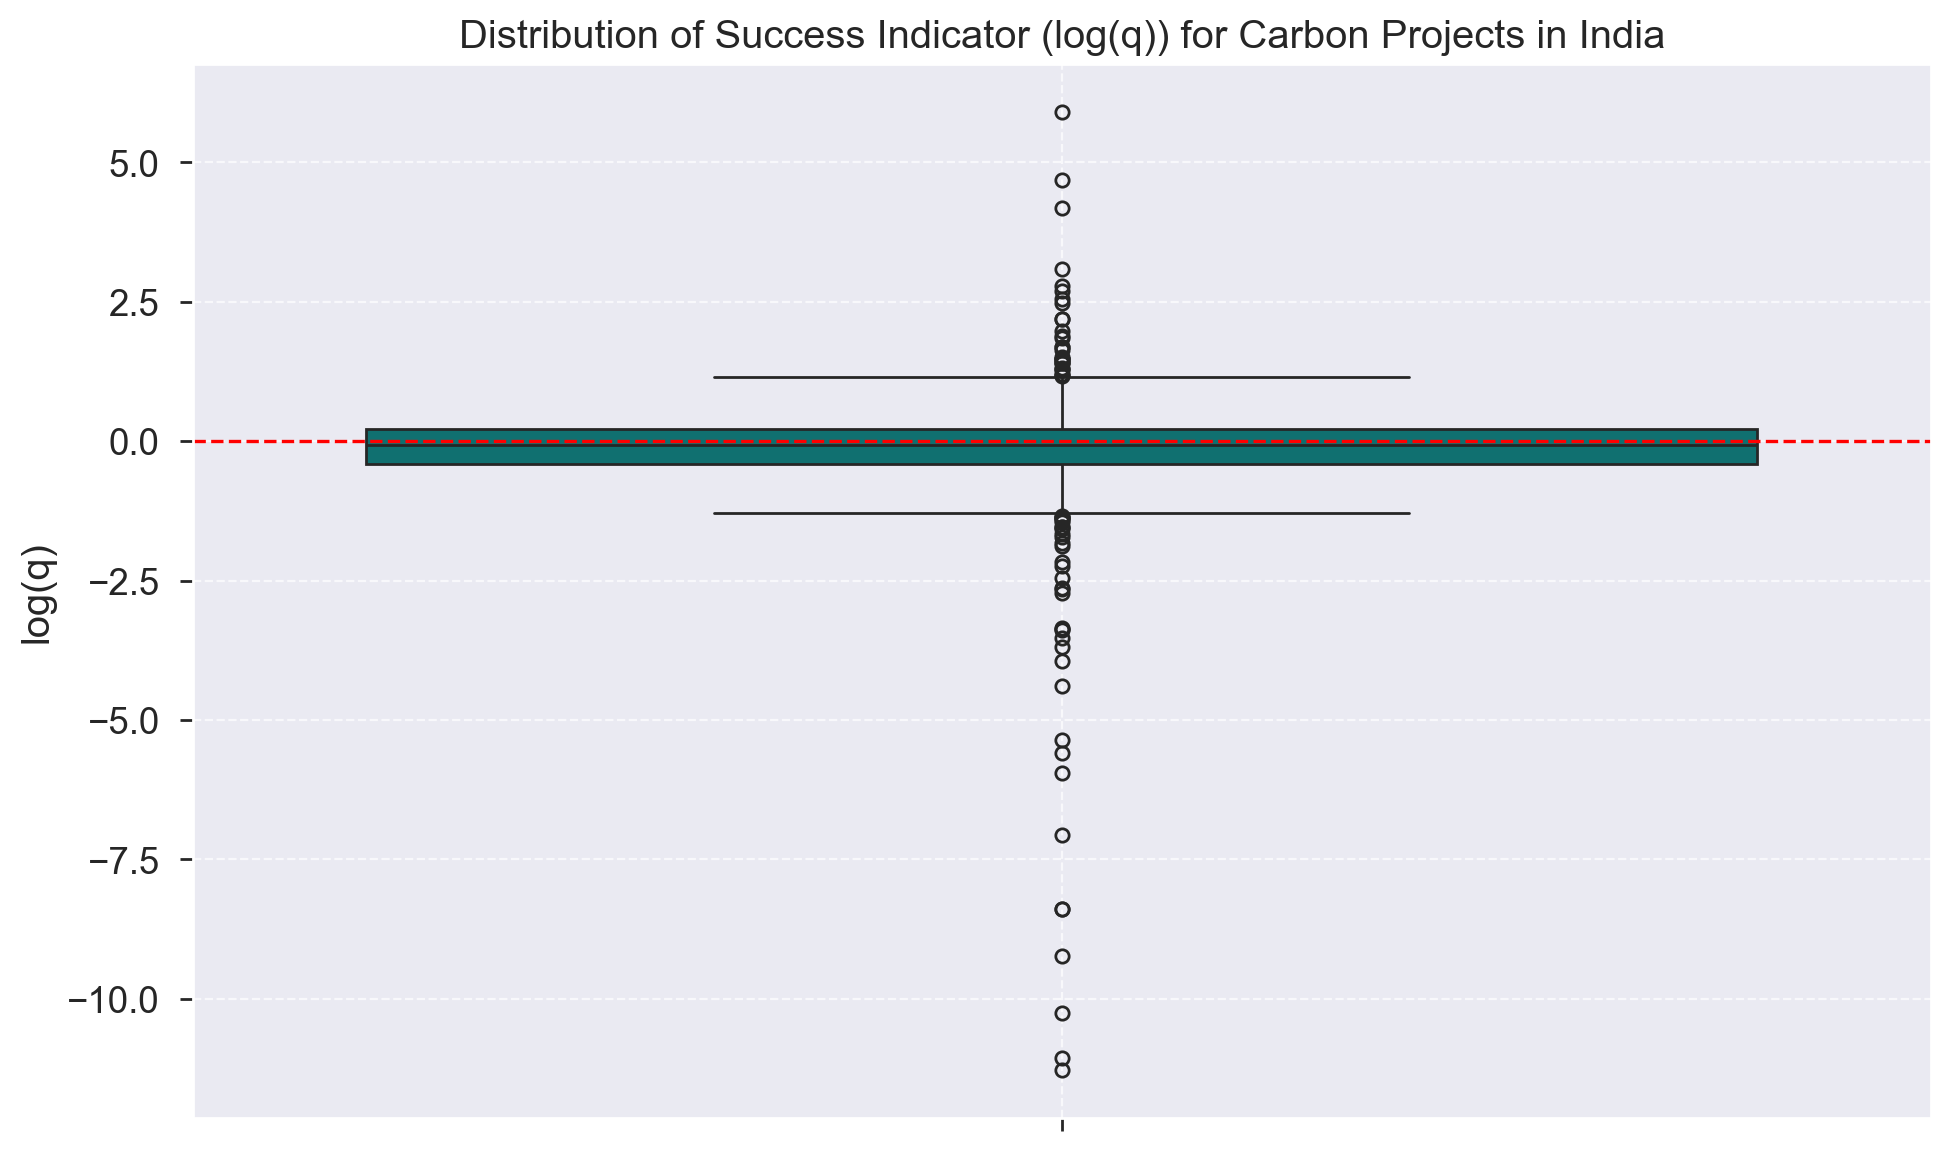

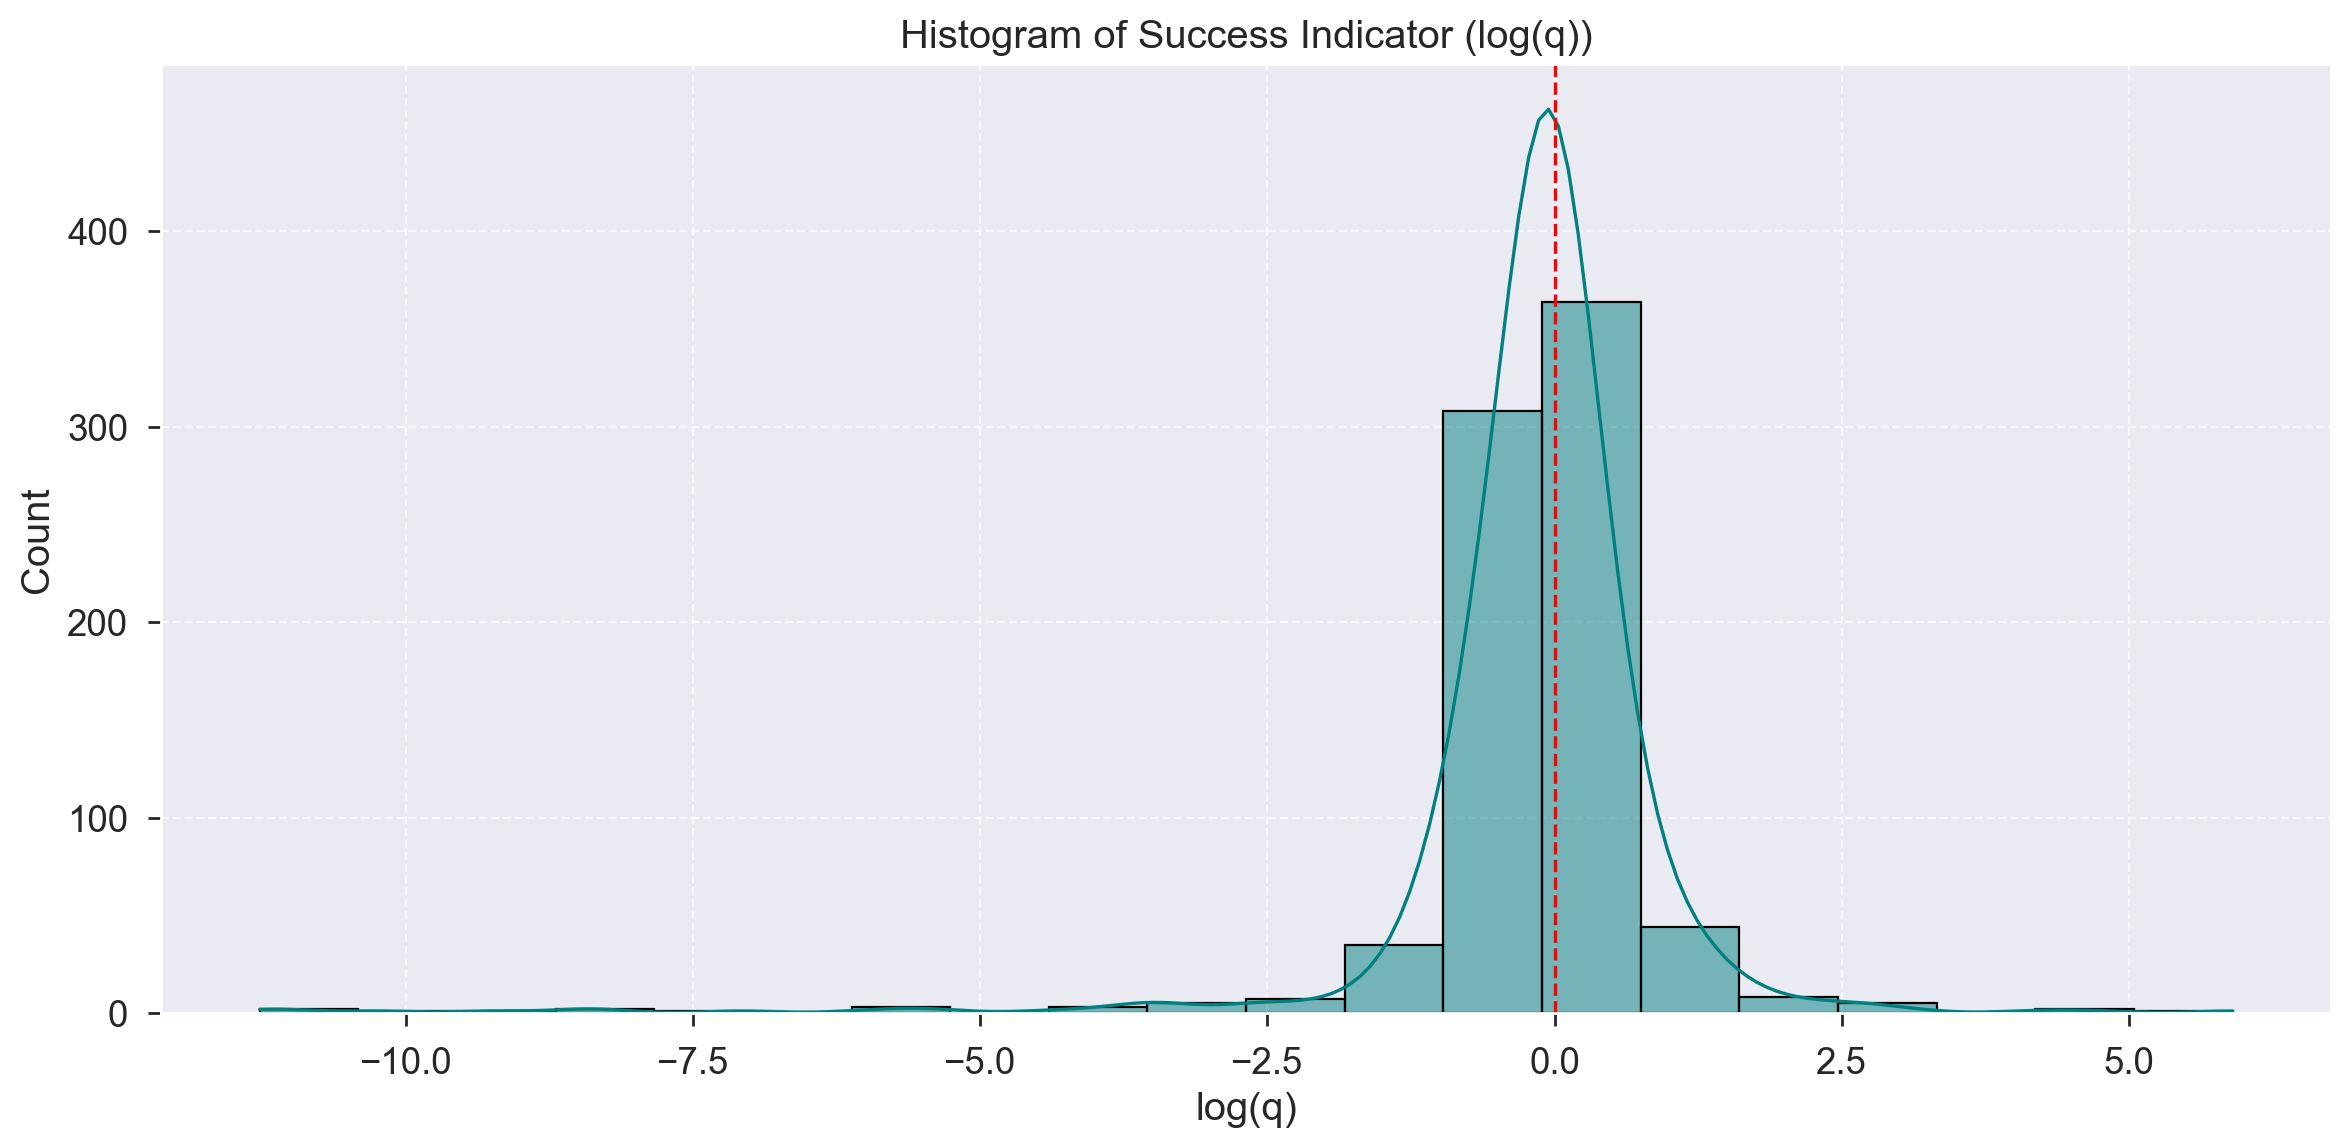

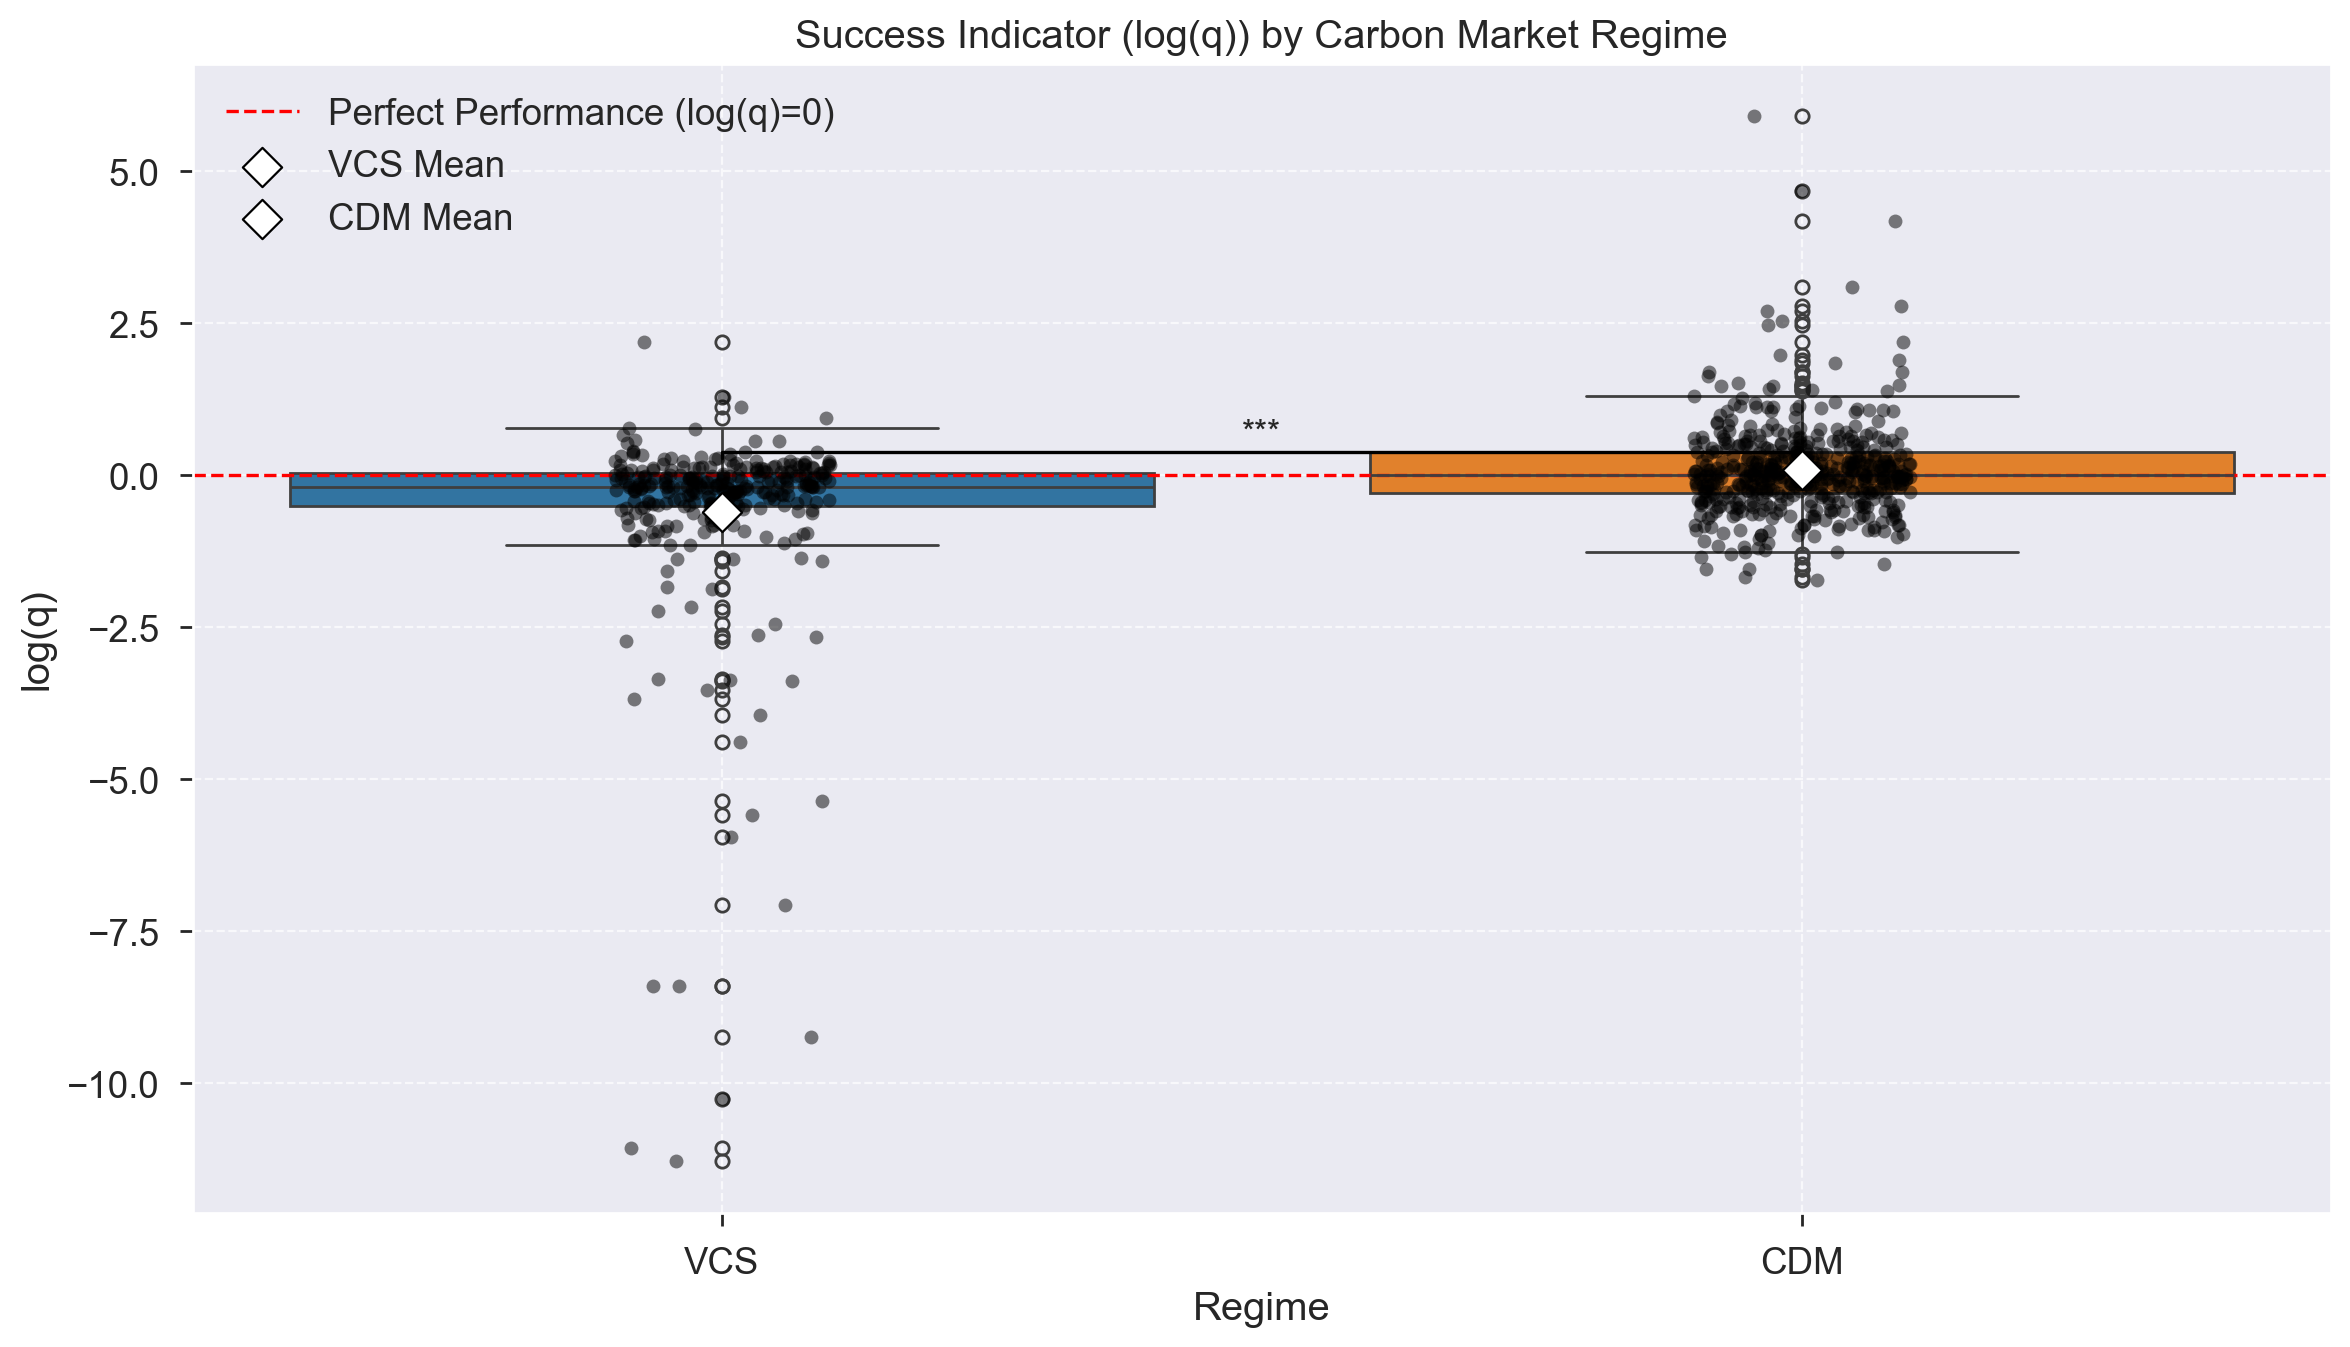

<Figure size 1200x700 with 0 Axes>

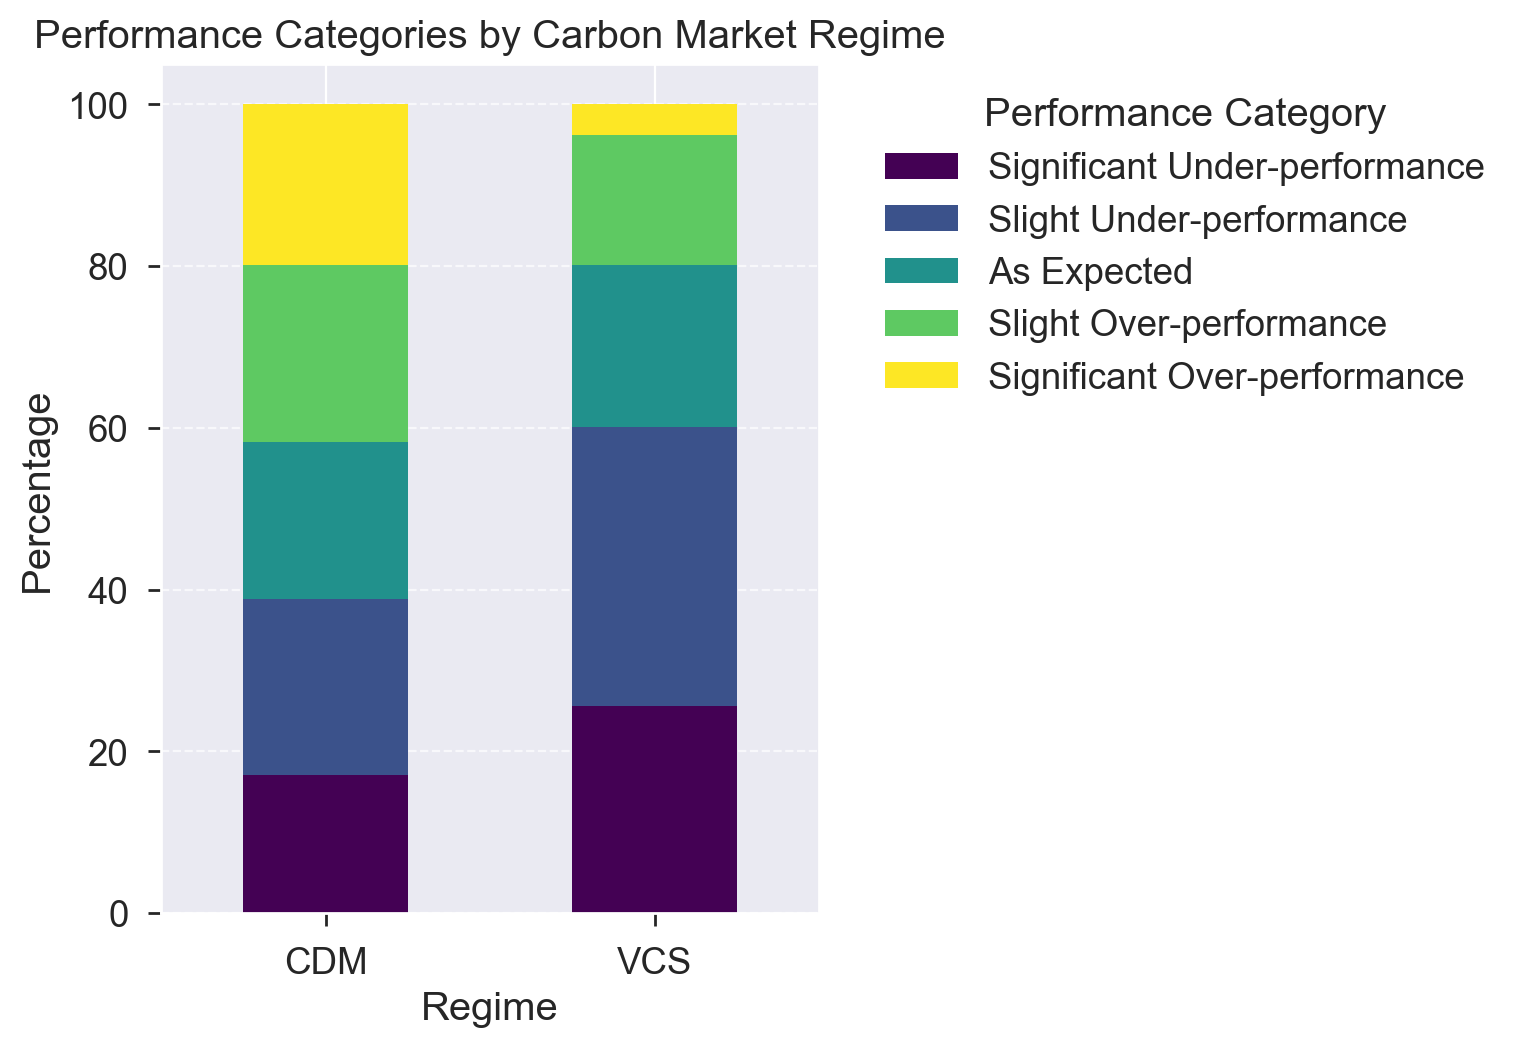

In [17]:
log_progress("Success Indicator Analysis", "Starting")

# Figure 1: Boxplot of Overall Success Indicator (log(q))
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_valid['log_q_success_indicator'], color='teal')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Distribution of Success Indicator (log(q)) for Carbon Projects in India')
plt.ylabel('log(q)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(FIG_SUCCESS_BOXPLOT, dpi=300)
plt.tight_layout()

# Create a histogram with KDE
plt.figure(figsize=(12, 6))
sns.histplot(df_valid['log_q_success_indicator'], kde=True, bins=20, color='teal')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Histogram of Success Indicator (log(q))')
plt.xlabel('log(q)')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(FIG_SUCCESS_HIST, dpi=300)
plt.tight_layout()

# Success distribution by regime with statistical annotation
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Regime_Display', y='log_q_success_indicator', data=df_valid, 
               palette=[REGIME_COLORS['VCS'], REGIME_COLORS['CDM']])
sns.stripplot(x='Regime_Display', y='log_q_success_indicator', data=df_valid, 
             color='black', alpha=0.5, jitter=True)
plt.axhline(y=0, color='r', linestyle='--', label='Perfect Performance (log(q)=0)')

# Add mean markers
means = df_valid.groupby('Regime')['log_q_success_indicator'].mean()
for i, regime in enumerate(REGIME_COLORS.keys()):
    if regime in means.index:
        plt.scatter(i, means[regime], marker='D', s=100, color='white', edgecolor='black', 
                   zorder=3, label=f'{regime} Mean')

# Add statistical annotation if possible
if 'p_val' in locals() and not np.isnan(p_val):
    if p_val < 0.001:
        sig_text = '***'
    elif p_val < 0.01:
        sig_text = '**'
    elif p_val < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    
    y_pos = max(means['VCS'], means['CDM']) + 0.2
    plt.plot([0, 0, 1, 1], [y_pos, y_pos + 0.1, y_pos + 0.1, y_pos], color='black')
    plt.text(0.5, y_pos + 0.15, sig_text, ha='center', va='bottom', fontsize=12)

plt.title('Success Indicator (log(q)) by Carbon Market Regime')
plt.xlabel('Regime')
plt.ylabel('log(q)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(FIG_SUCCESS_BY_REGIME, dpi=300)

# Analyze success distribution relative to baseline (log(q) = 0)
over_performance = (df_valid['log_q_success_indicator'] > 0).mean() * 100
under_performance = (df_valid['log_q_success_indicator'] < 0).mean() * 100
as_expected = (df_valid['log_q_success_indicator'] == 0).mean() * 100

print(f"\nPerformance relative to estimates:")
print(f"  Over-performance (log(q) > 0): {over_performance:.1f}%")
print(f"  Under-performance (log(q) < 0): {under_performance:.1f}%")
print(f"  As expected (log(q) = 0): {as_expected:.1f}%")

# Analyze success distribution by regime
regime_performance = df_valid.groupby('Regime').apply(
    lambda x: pd.Series({
        'over_performance': (x['log_q_success_indicator'] > 0).mean() * 100,
        'under_performance': (x['log_q_success_indicator'] < 0).mean() * 100,
        'as_expected': (x['log_q_success_indicator'] == 0).mean() * 100
    })
)
print("\nPerformance relative to estimates by regime:")
print(regime_performance.round(1))

# Create performance categories for further analysis
df_valid['Performance_Category'] = pd.cut(
    df_valid['log_q_success_indicator'],
    bins=[-float('inf'), -0.5, -0.1, 0.1, 0.5, float('inf')],
    labels=['Significant Under-performance', 'Slight Under-performance', 
            'As Expected', 'Slight Over-performance', 'Significant Over-performance']
)

# Show distribution of performance categories
perf_distribution = df_valid['Performance_Category'].value_counts().sort_index()
print("\nPerformance Categories:")
print(perf_distribution)
print(f"Percentage: {(perf_distribution / len(df_valid) * 100).round(1)}")

# Analyze performance categories by regime
perf_by_regime = pd.crosstab(
    df_valid['Regime'], 
    df_valid['Performance_Category'],
    normalize='index'
) * 100
print("\nPerformance Categories by Regime (%):")
print(perf_by_regime.round(1))

# Create stacked bar chart of performance categories by regime
plt.figure(figsize=(12, 7))
perf_by_regime.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Performance Categories by Carbon Market Regime')
plt.xlabel('Regime')
plt.ylabel('Percentage')
plt.legend(title='Performance Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'performance_category_by_regime.png'), dpi=300)

log_progress("Success Indicator Analysis", "Completed")

## 3. Technology Analysis

This section examines how project performance varies by technology type across both CDM and VCS regimes.

[2025-05-09 22:32:08] Technology Analysis: Starting


C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\189785454.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Technology_Category', y='log_q_success_indicator', data=df_valid,



Performance by Technology Category (sorted by mean):
                     count    mean     std      min     max  median  pct_over  \
Technology_Category                                                             
Solar                   18  0.1691  0.3593  -0.9168  0.5547  0.1951   72.2222   
Wind                   198  0.1387  0.7882  -1.2550  5.9048 -0.0085   48.9899   
Hydro                   58  0.0528  0.6236  -1.3465  1.8921  0.0441   55.1724   
Industrial Gases         9 -0.0382  0.5911  -1.0477  0.7456  0.0785   66.6667   
Biomass and Waste      134 -0.1849  1.6512 -11.0557  4.6839 -0.0133   47.0149   
Other                  203 -0.2867  1.1805 -11.2757  1.3942 -0.1084   35.4680   
Other Renewable        127 -0.3872  1.3526  -9.2353  1.9738 -0.1658   33.0709   
Energy Efficiency       45 -0.8108  1.6211  -5.9556  2.1909 -0.1913   20.0000   

                     variance  pct_under  
Technology_Category                       
Solar                  0.1291    27.7778  
Wind  

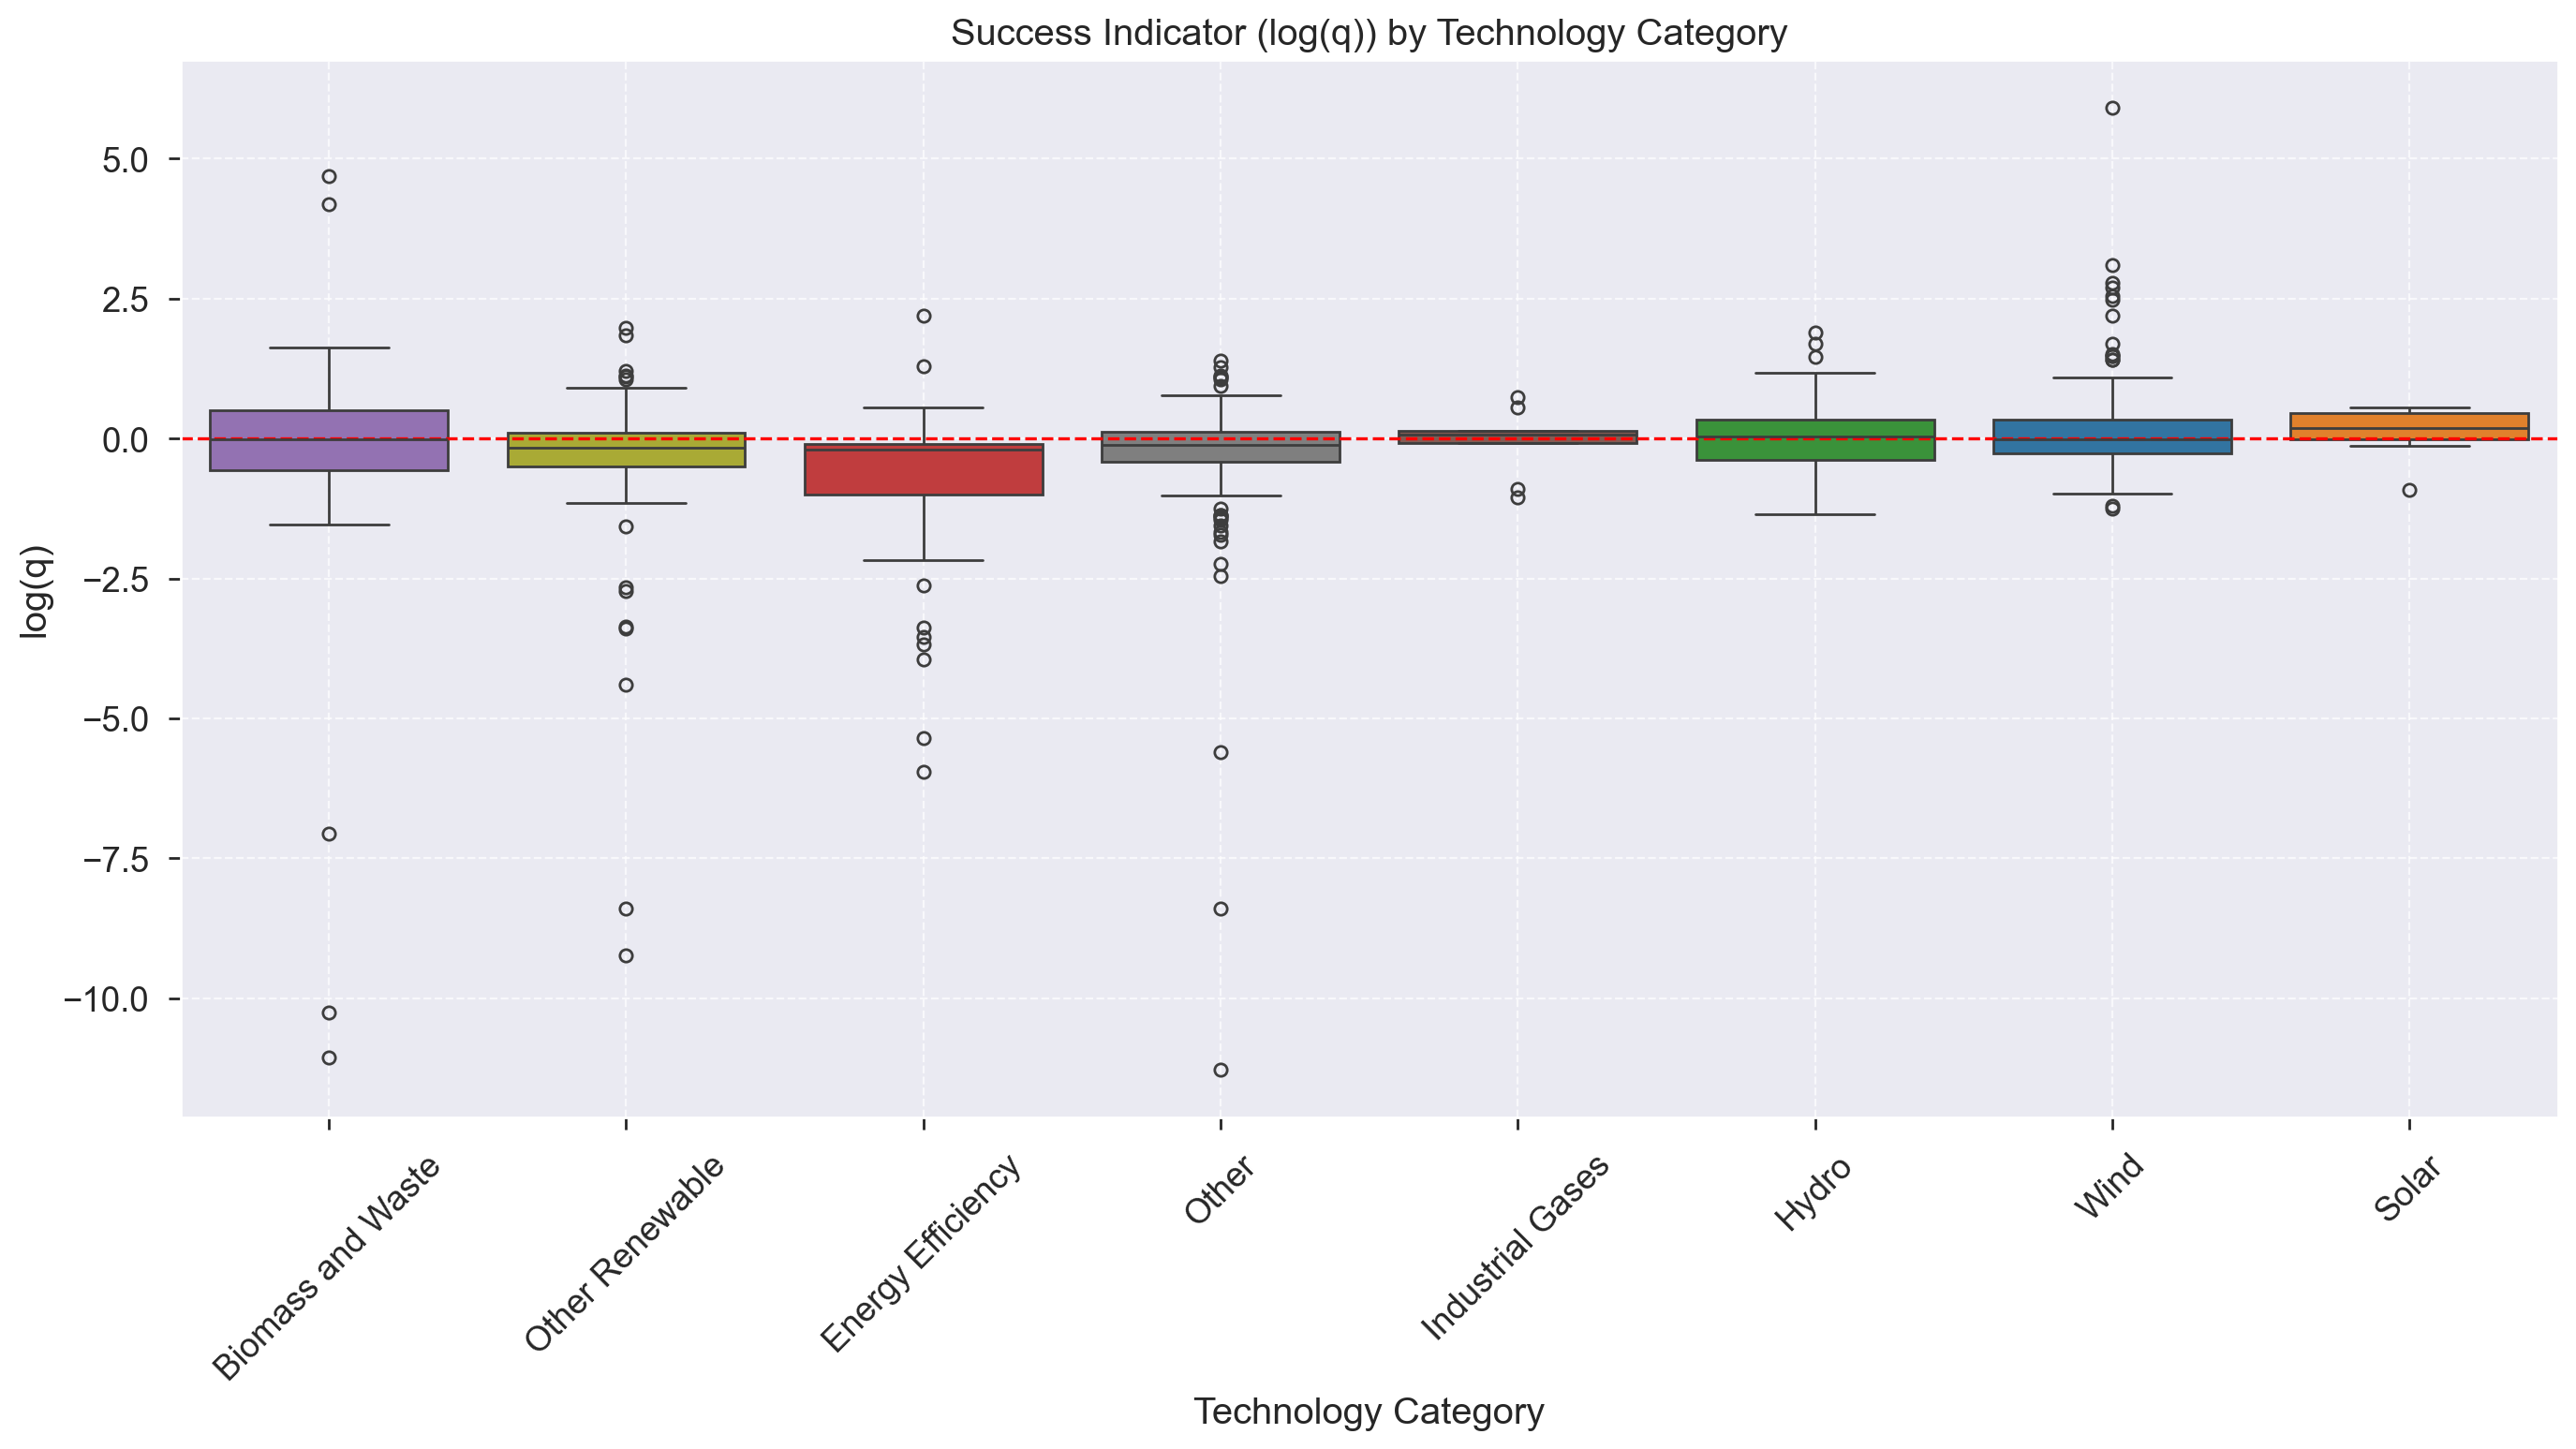

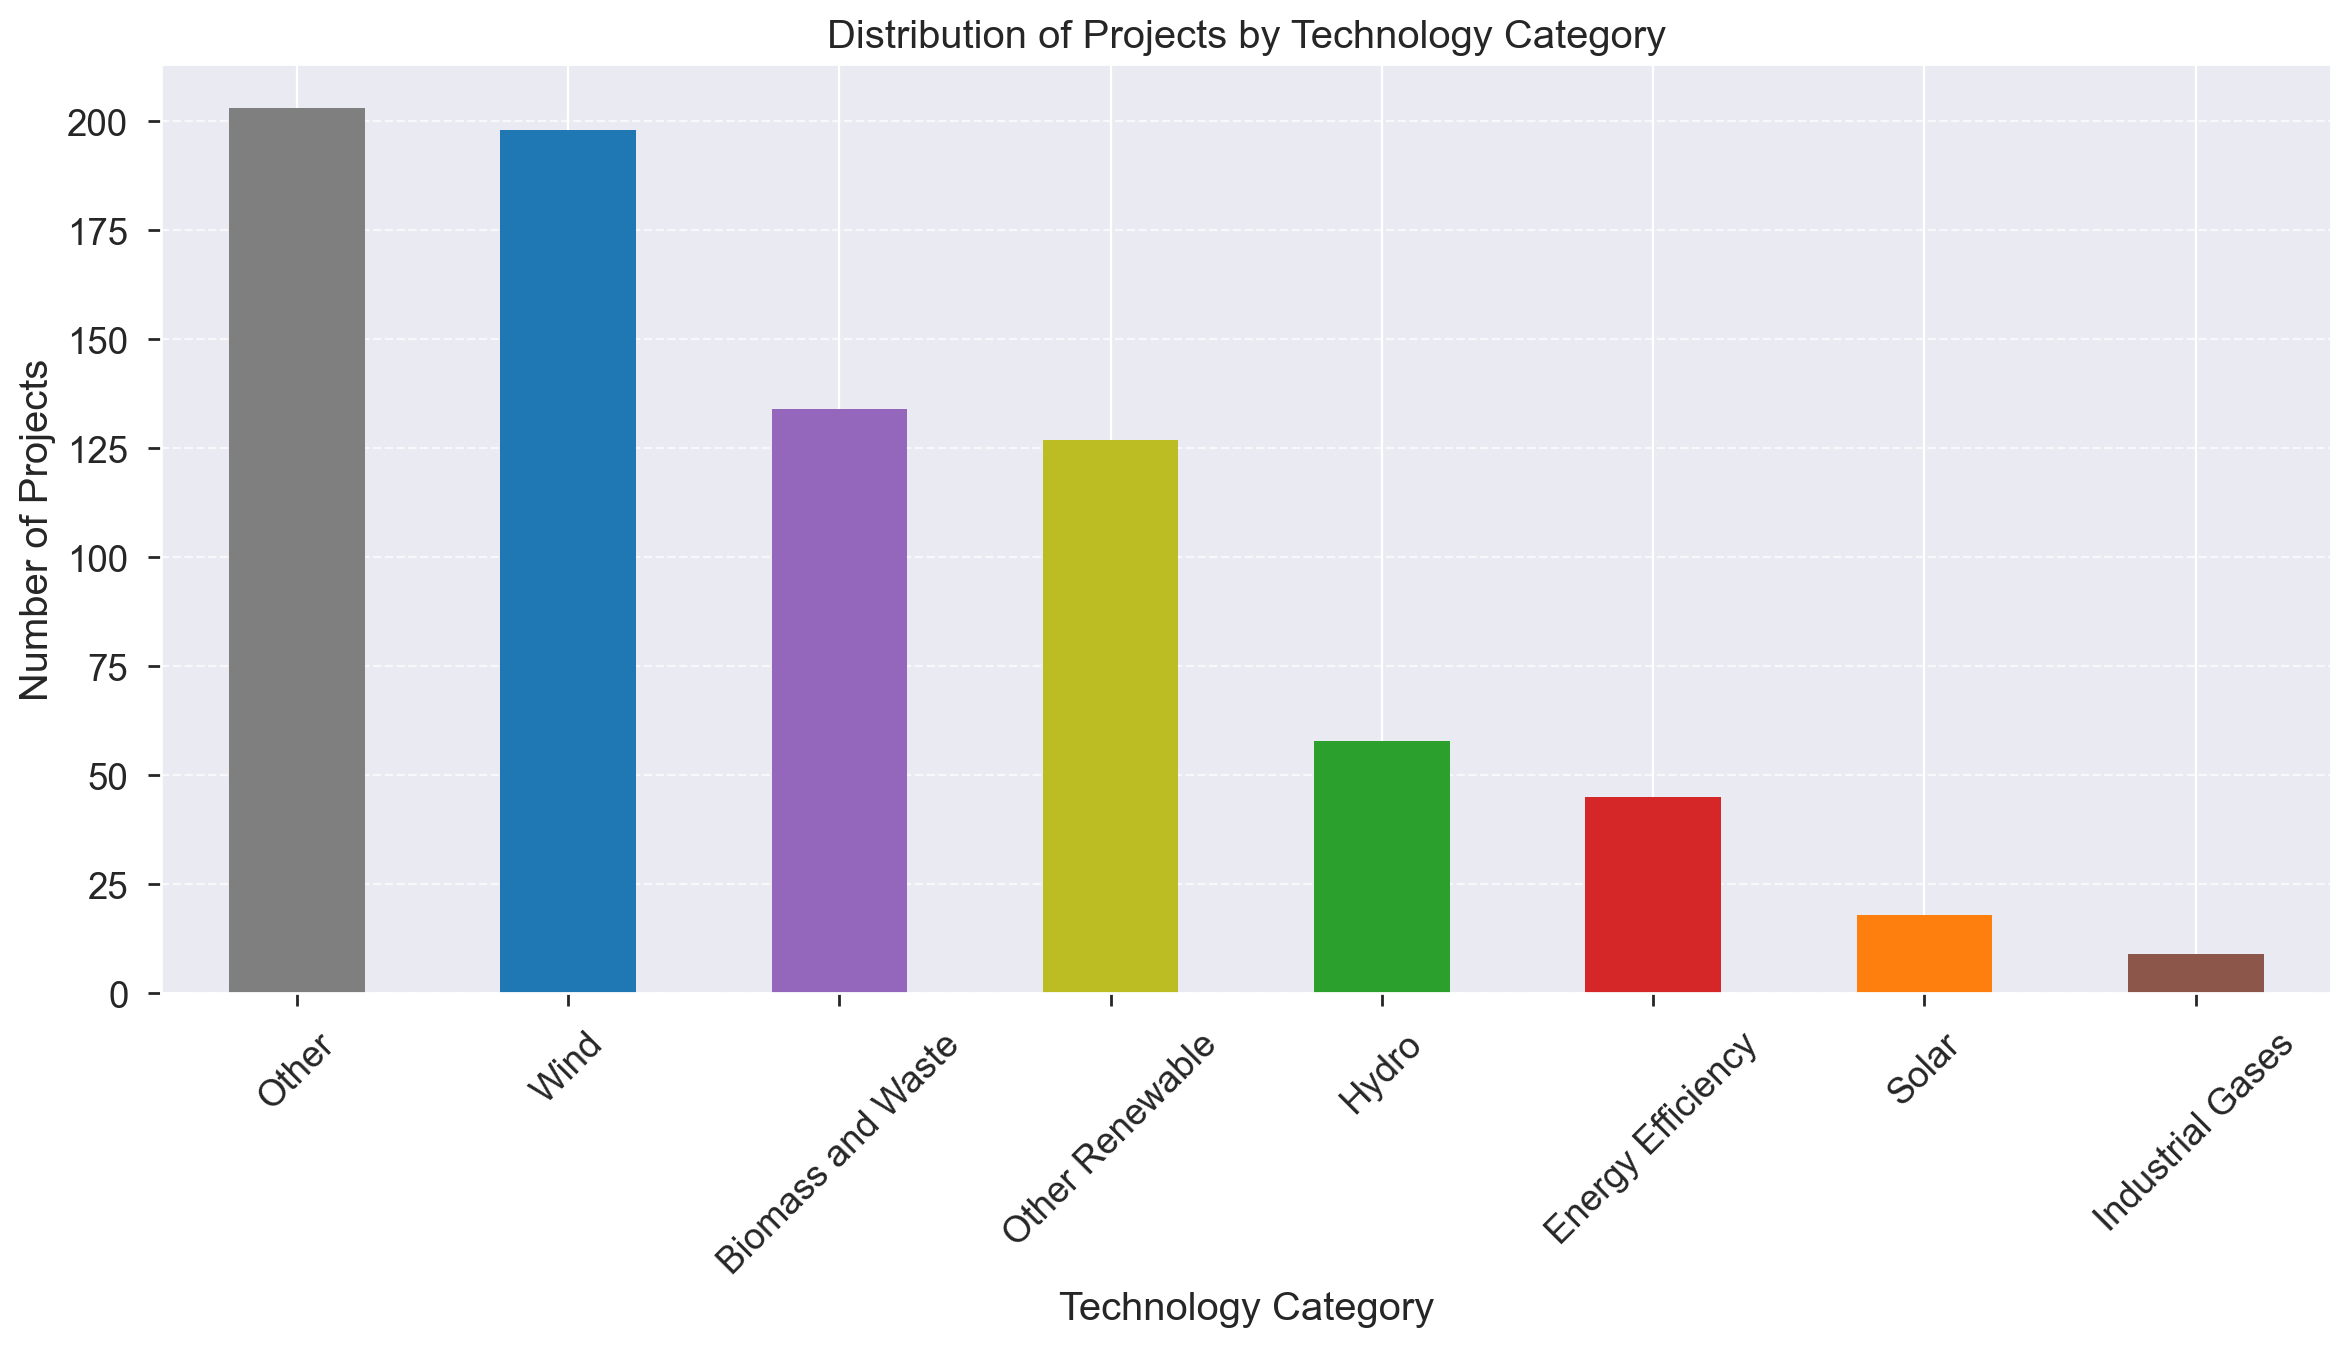

<Figure size 1400x800 with 0 Axes>

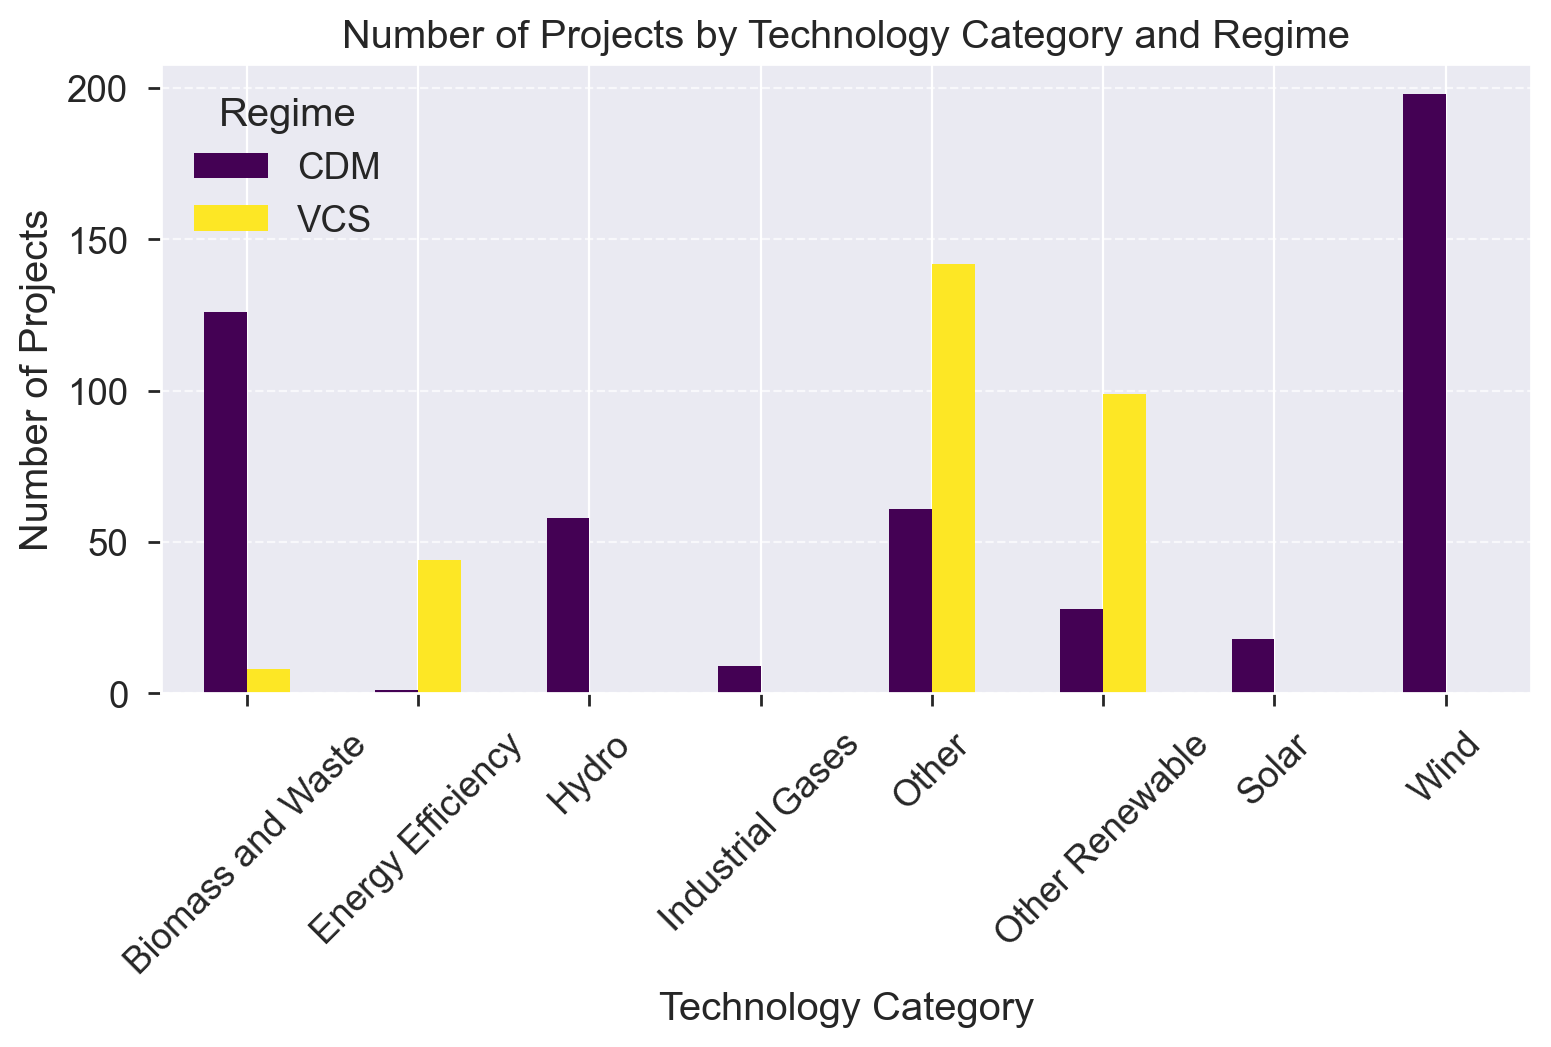

<Figure size 1200x800 with 0 Axes>

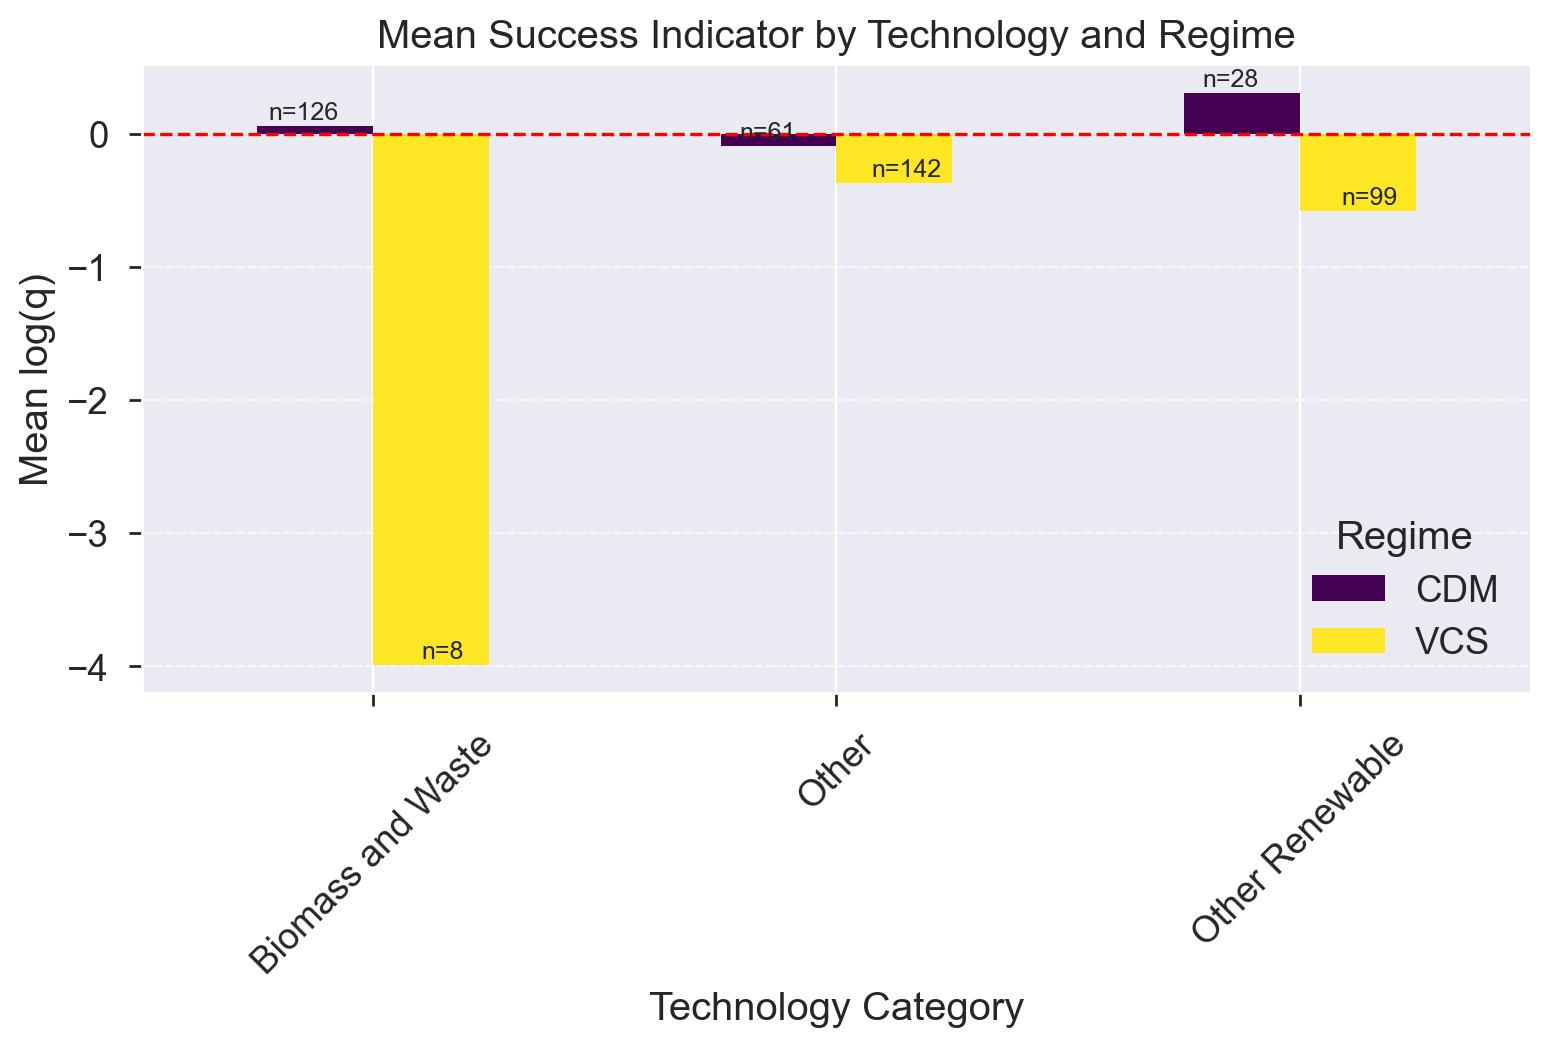

In [18]:
log_progress("Technology Analysis", "Starting")

# Figure: Success Indicator by Technology (Boxplot)
plt.figure(figsize=(14, 8))
sns.boxplot(x='Technology_Category', y='log_q_success_indicator', data=df_valid, 
           palette=[TECH_COLORS.get(tech, '#333333') for tech in df_valid['Technology_Category'].unique()])
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Success Indicator (log(q)) by Technology Category')
plt.xlabel('Technology Category')
plt.ylabel('log(q)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(FIG_SUCCESS_BY_TECH, dpi=300)

# Calculate summary statistics by technology
tech_summary = df_valid.groupby('Technology_Category')['log_q_success_indicator'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median',
    lambda x: (x > 0).mean() * 100  # % over-performing
]).rename(columns={'<lambda_0>': 'pct_over'})

# Add variance
tech_summary['variance'] = df_valid.groupby('Technology_Category')['log_q_success_indicator'].var()
tech_summary['pct_under'] = df_valid.groupby('Technology_Category')['log_q_success_indicator'].apply(
    lambda x: (x < 0).mean() * 100)

# Round values for better readability
tech_summary = tech_summary.round(4)

# Sort by mean performance
tech_summary_sorted = tech_summary.sort_values('mean', ascending=False)

print("\nPerformance by Technology Category (sorted by mean):")
print(tech_summary_sorted)

# Save the technology summary
tech_summary.to_csv(TECH_SUMMARY_OUTPUT)

# Technology distribution visualization
plt.figure(figsize=(12, 7))
tech_counts = df_valid['Technology_Category'].value_counts().sort_values(ascending=False)
tech_counts.plot(kind='bar', color=[TECH_COLORS.get(tech, '#333333') for tech in tech_counts.index])
plt.title('Distribution of Projects by Technology Category')
plt.xlabel('Technology Category')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(FIG_TECH_DIST, dpi=300)

# Technology distribution by regime
tech_by_regime = pd.crosstab(df_valid['Technology_Category'], df_valid['Regime'])
tech_by_regime_pct = pd.crosstab(df_valid['Technology_Category'], df_valid['Regime'], 
                                normalize='index') * 100

print("\nTechnology Distribution by Regime (count):")
print(tech_by_regime)
print("\nTechnology Distribution by Regime (%):")
print(tech_by_regime_pct.round(1))

# Plot technology distribution by regime
plt.figure(figsize=(14, 8))
tech_by_regime.plot(kind='bar', colormap='viridis')
plt.title('Number of Projects by Technology Category and Regime')
plt.xlabel('Technology Category')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.legend(title='Regime')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(FIG_TECH_BY_REGIME, dpi=300)

# Calculate success by technology and regime
tech_regime_success = df_valid.groupby(['Technology_Category', 'Regime'])['log_q_success_indicator'].agg([
    'count', 'mean', 'std'
]).reset_index()

# Create pivot tables for easier visualization
success_by_tech_regime = tech_regime_success.pivot(index='Technology_Category', 
                                                 columns='Regime', 
                                                 values='mean')
counts_by_tech_regime = tech_regime_success.pivot(index='Technology_Category', 
                                                columns='Regime', 
                                                values='count')

print("\nMean Success Indicator by Technology and Regime:")
print(success_by_tech_regime.round(4))
print("\nSample Sizes by Technology and Regime:")
print(counts_by_tech_regime)

# Plot success by technology and regime (for technologies with sufficient data in both)
valid_tech_mask = (counts_by_tech_regime['CDM'] >= MIN_COUNT_FOR_CATEGORY) & \
                  (counts_by_tech_regime['VCS'] >= MIN_COUNT_FOR_CATEGORY)
valid_techs = valid_tech_mask.index[valid_tech_mask]

if len(valid_techs) > 0:
    plt.figure(figsize=(12, 8))
    success_by_tech_regime.loc[valid_techs].plot(kind='bar', colormap='viridis')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Mean Success Indicator by Technology and Regime')
    plt.xlabel('Technology Category')
    plt.ylabel('Mean log(q)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Regime')
    
    # Add sample size annotations
    for i, tech in enumerate(valid_techs):
        for j, regime in enumerate(['CDM', 'VCS']):
            if regime in counts_by_tech_regime.columns and tech in counts_by_tech_regime.index:
                count = counts_by_tech_regime.loc[tech, regime]
                mean = success_by_tech_regime.loc[tech, regime]
                if not pd.isna(count) and not pd.isna(mean):
                    plt.text(i - 0.15 + j*0.3, mean + 0.05, f"n={int(count)}", 
                           ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'success_by_tech_and_regime.png'), dpi=300)
else:
    print("\nInsufficient data to compare technologies across both regimes")

# ANOVA test for technology differences if sufficient data
if len(tech_summary) >= 3:  # At least 3 technology categories
    from scipy.stats import f_oneway
    
    tech_groups = []
    tech_names = []
    
    # Collect data for each technology with sufficient sample size
    for tech, group_data in df_valid.groupby('Technology_Category'):
        if len(group_data) >= MIN_COUNT_FOR_CATEGORY:
            tech_groups.append(group_data['log_q_success_indicator'])
            tech_names.append(tech)
    
    if len(tech_groups) >= 2:  # Need at least 2 groups for ANOVA
        f_stat, p_val = f_oneway(*tech_groups)
        print("\nANOVA Test for Technology Differences:")
        print(f"F-statistic: {f_stat:.4f}, p-value: {p_val:.4f}")
        if p_val < 0.05:
            print("There are statistically significant differences in success between technology categories")
        else:
            print("No statistically significant differences in success between technology categories")
        
        # If significant, run post-hoc tests (Tukey's HSD)
        if p_val < 0.05:
            from statsmodels.stats.multicomp import pairwise_tukeyhsd
            
            # Prepare data for Tukey's test
            tukey_data = []
            tukey_groups = []
            
            for tech, group_data in df_valid.groupby('Technology_Category'):
                if len(group_data) >= MIN_COUNT_FOR_CATEGORY:
                    tukey_data.extend(group_data['log_q_success_indicator'].tolist())
                    tukey_groups.extend([tech] * len(group_data))
            
            # Run Tukey's test
            tukey_result = pairwise_tukeyhsd(tukey_data, tukey_groups, alpha=0.05)
            print("\nTukey's HSD Post-hoc Test Results:")
            print(tukey_result)

log_progress("Technology Analysis", "Completed")

## 4. Scale Analysis

This section examines how project performance relates to project scale (small vs. large) across both regimes.

[2025-05-09 22:32:12] Scale Analysis: Starting


C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\2400264483.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Scale_Category', y='log_q_success_indicator', data=df_valid, palette=['skyblue', 'orange'])
C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\2400264483.py:5: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Scale_Category', y='log_q_success_indicator', data=df_valid, palette=['skyblue', 'orange'])



Performance by Scale Category:
                count    mean     std      min     max  median  pct_over  \
Scale_Category                                                             
LARGE             200  0.0144  0.7792  -1.7188  4.6839 -0.0842   41.5000   
Large Scale       159 -0.5615  1.6567 -11.2757  0.9478 -0.1534   32.0755   
SMALL             299  0.1312  0.7325  -1.5349  5.9048  0.0765   56.5217   
Small Scale       134 -0.6587  1.7044 -10.2568  2.1909 -0.2051   23.1343   

                variance  pct_under  
Scale_Category                       
LARGE             0.6071    58.5000  
Large Scale       2.7445    67.9245  
SMALL             0.5366    43.4783  
Small Scale       2.9050    76.8657  

T-test for Scale Differences:
Small Scale: n=134, mean=-0.6587
Large Scale: n=159, mean=-0.5615
T-statistic: -0.4936, p-value: 0.6219
No statistically significant difference in success between small and large scale projects

Performance Categories by Scale (%):
Performance_Category

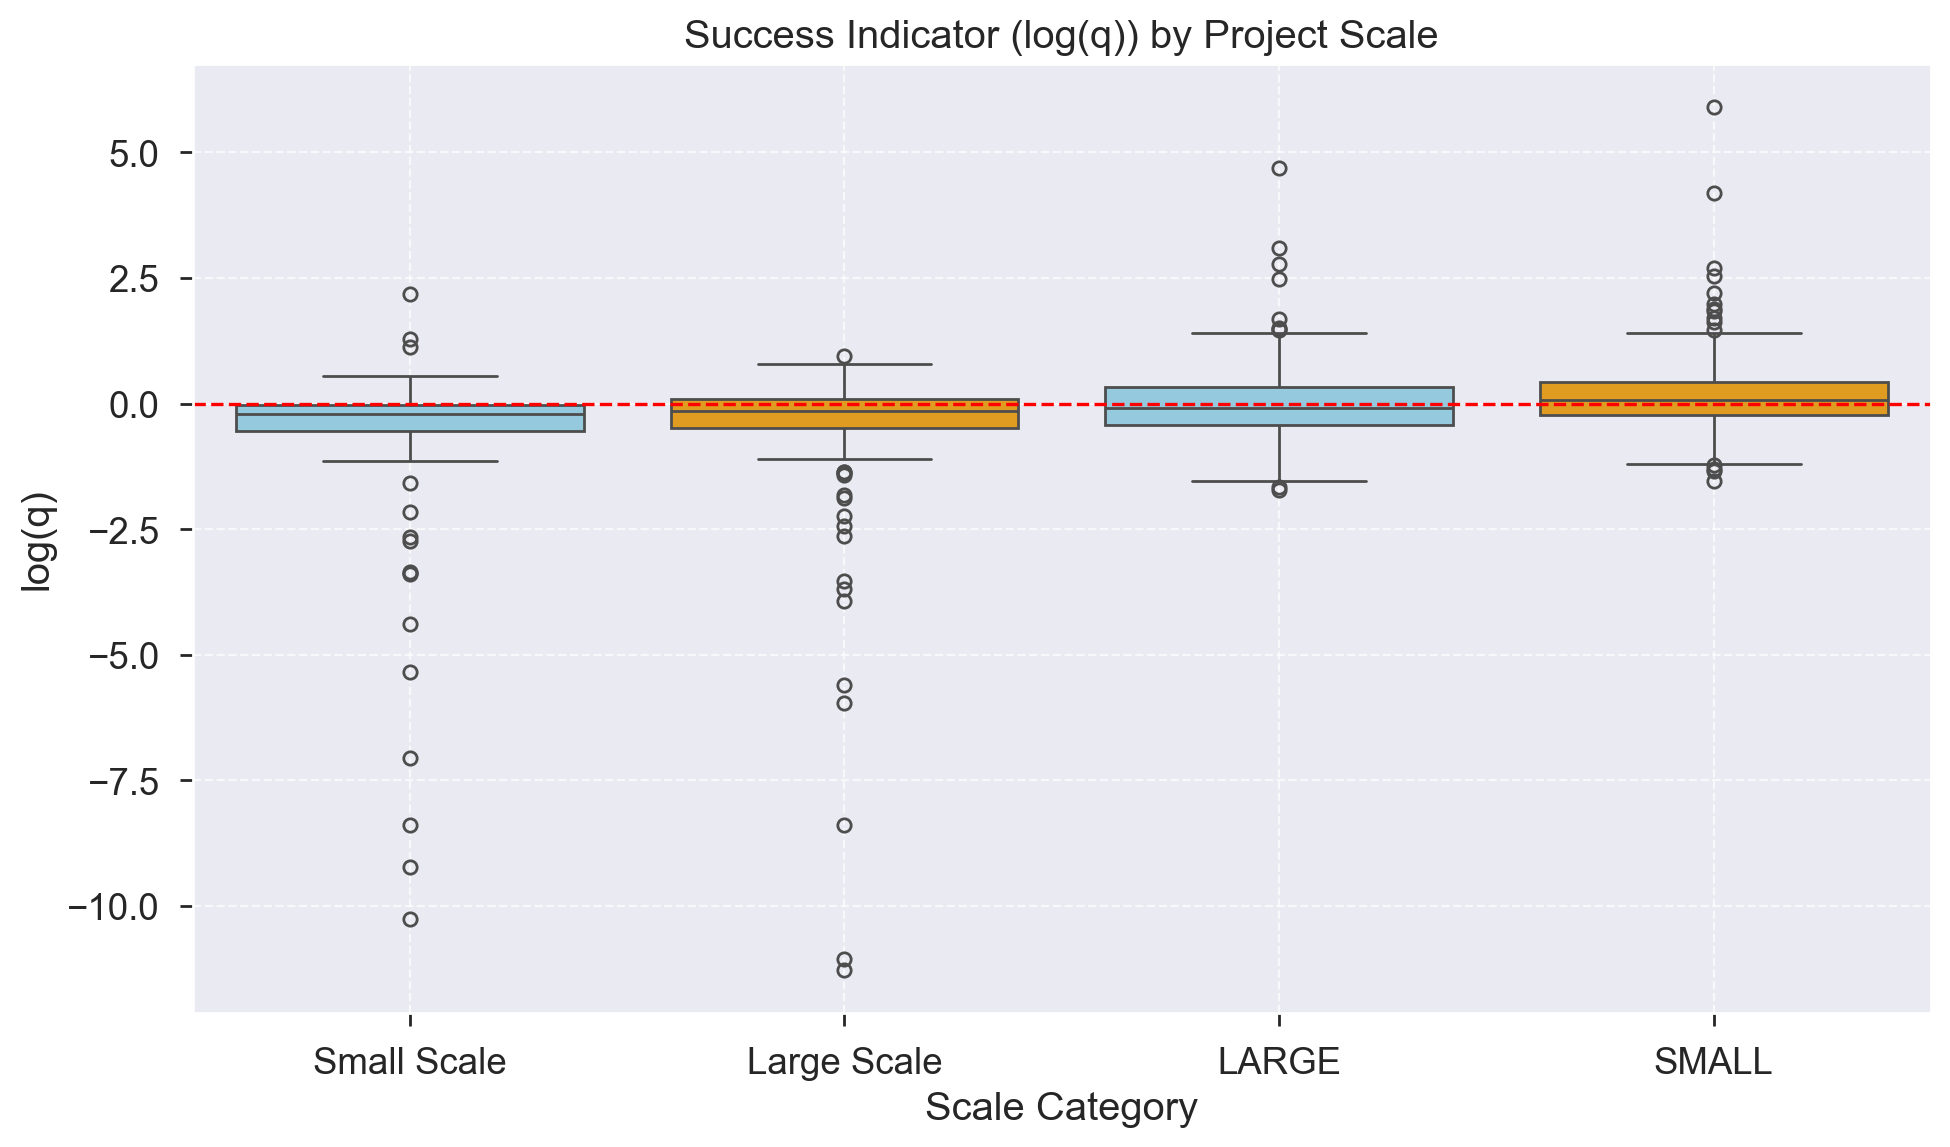

<Figure size 1200x700 with 0 Axes>

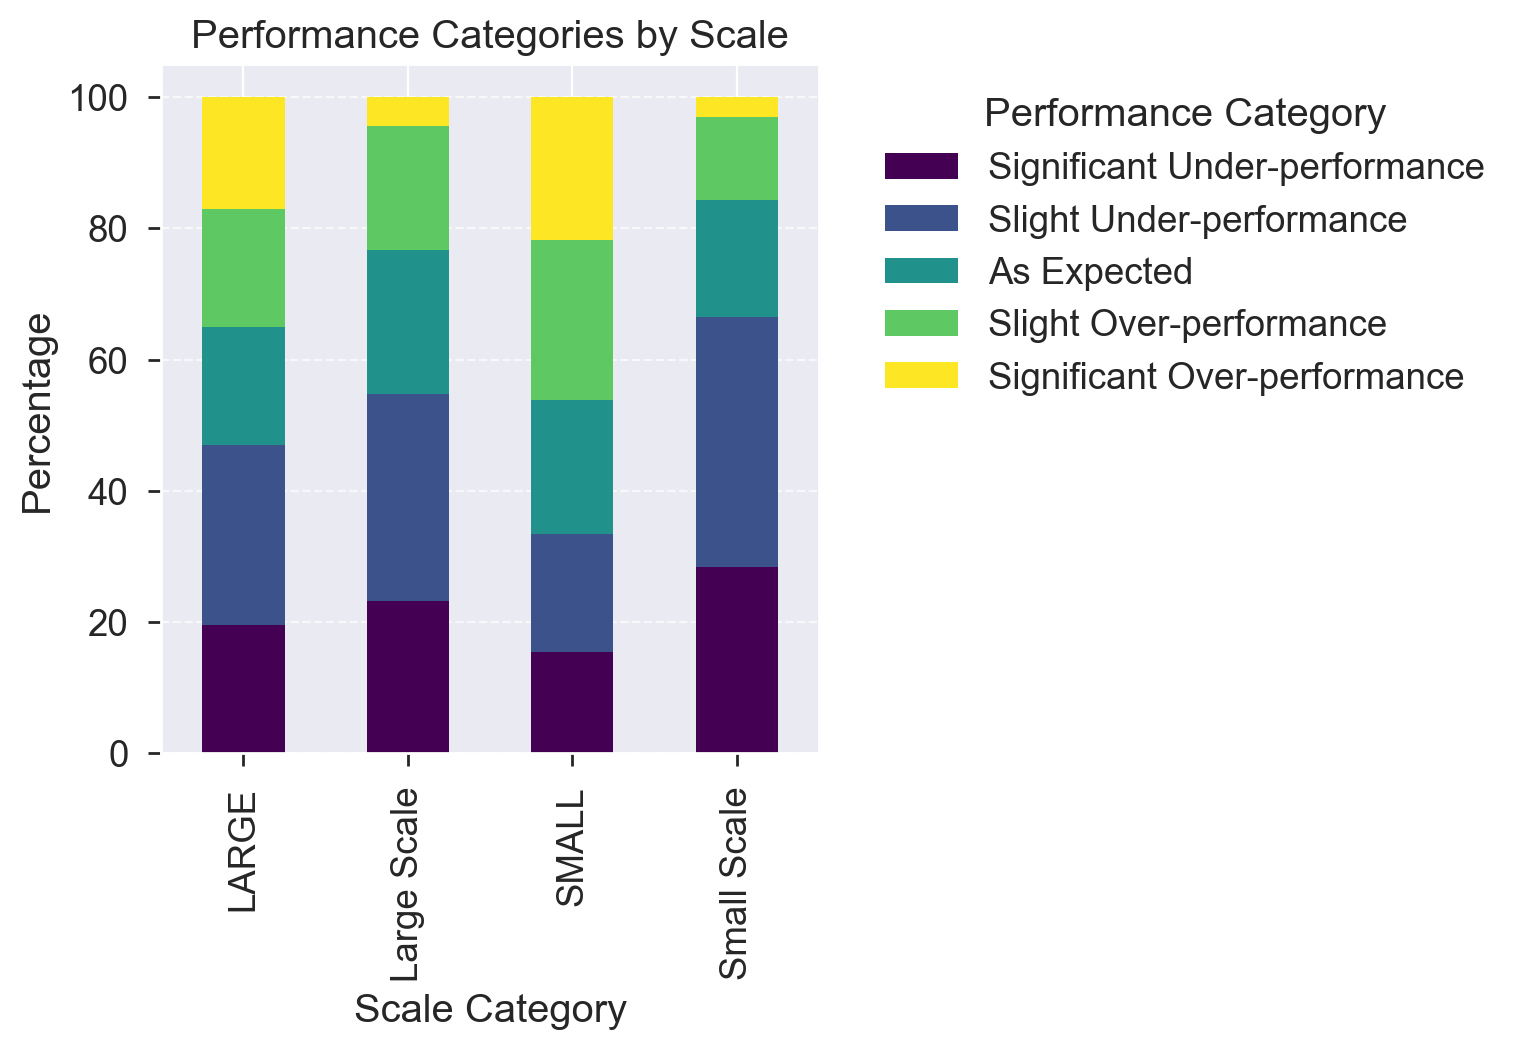

<Figure size 1000x600 with 0 Axes>

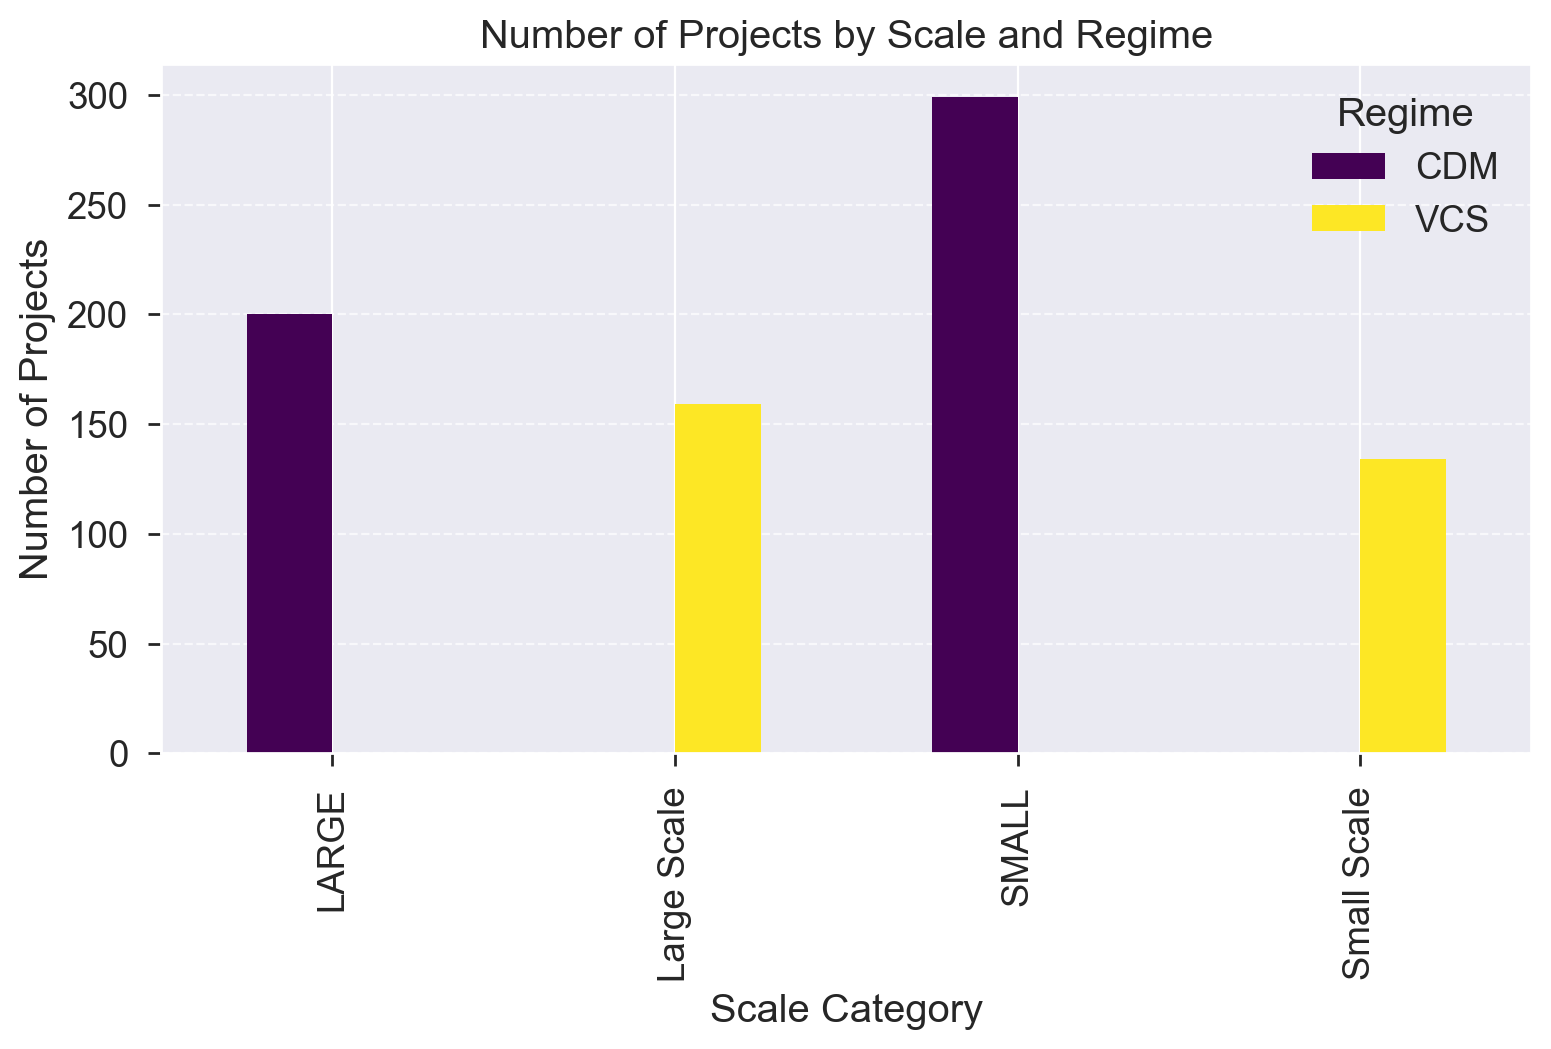

<Figure size 1000x600 with 0 Axes>

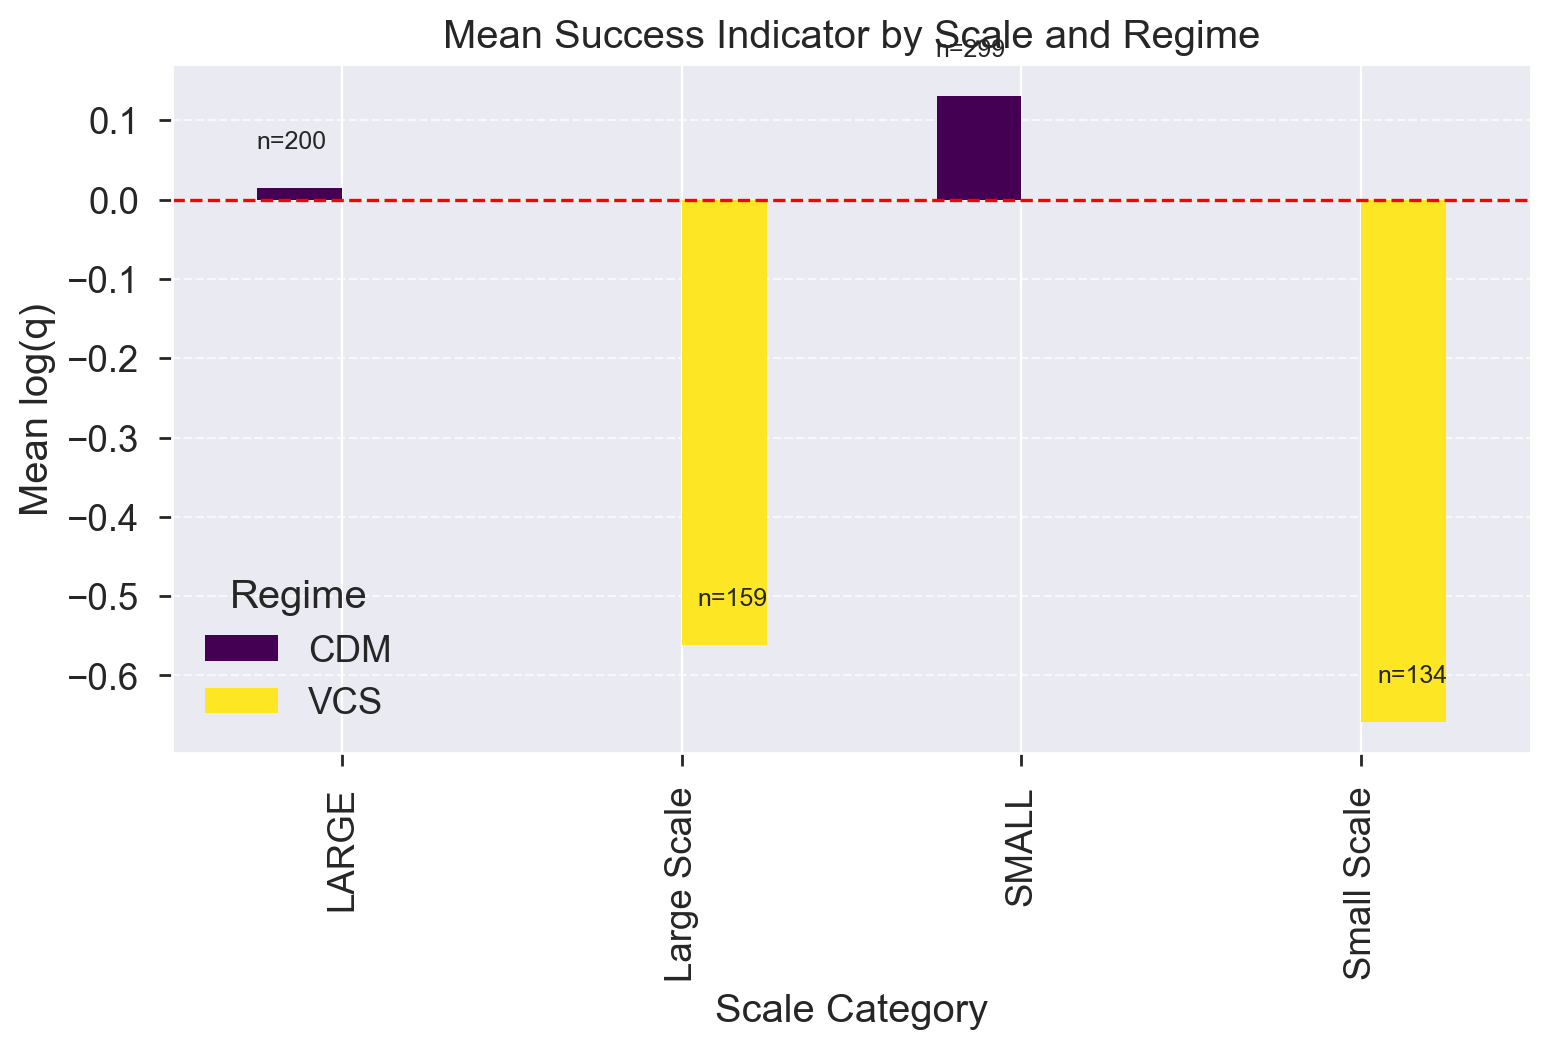

<Figure size 1200x700 with 0 Axes>

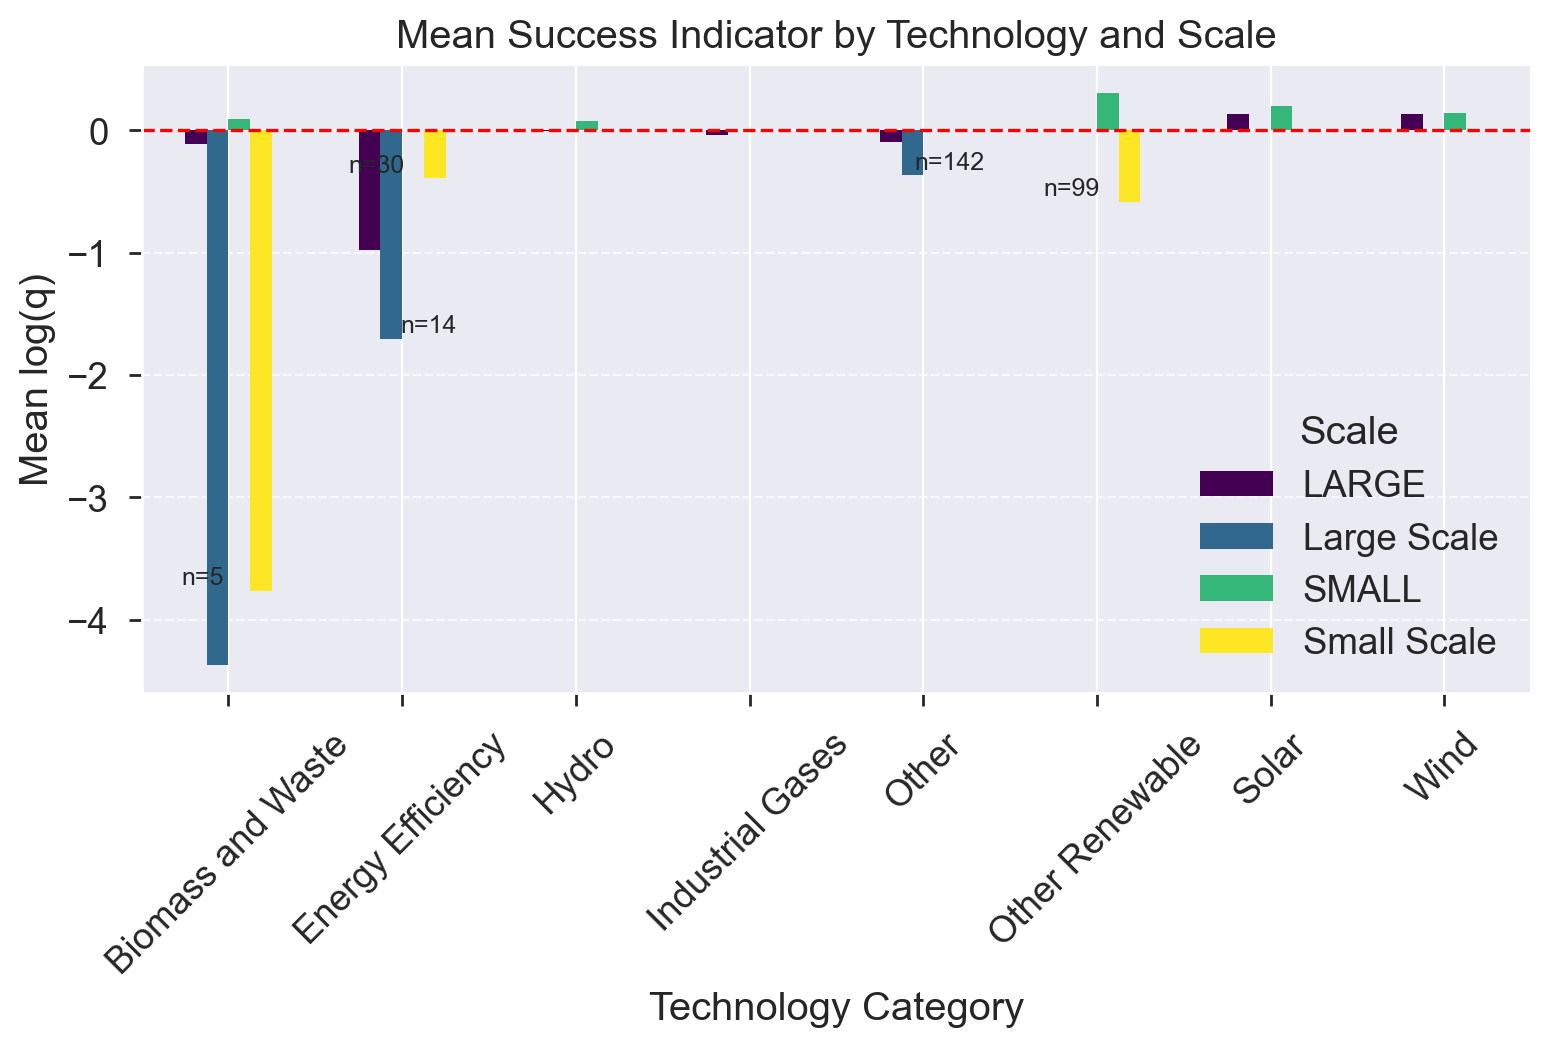

In [19]:
log_progress("Scale Analysis", "Starting")

# Figure: Success Indicator by Scale (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Scale_Category', y='log_q_success_indicator', data=df_valid, palette=['skyblue', 'orange'])
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Success Indicator (log(q)) by Project Scale')
plt.xlabel('Scale Category')
plt.ylabel('log(q)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(FIG_SUCCESS_BY_SCALE, dpi=300)

# Calculate summary statistics by scale
scale_summary = df_valid.groupby('Scale_Category')['log_q_success_indicator'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median',
    lambda x: (x > 0).mean() * 100  # % over-performing
]).rename(columns={'<lambda_0>': 'pct_over'})

# Add variance and percentage under-performing
scale_summary['variance'] = df_valid.groupby('Scale_Category')['log_q_success_indicator'].var()
scale_summary['pct_under'] = df_valid.groupby('Scale_Category')['log_q_success_indicator'].apply(
    lambda x: (x < 0).mean() * 100)

# Round values for better readability
scale_summary = scale_summary.round(4)

print("\nPerformance by Scale Category:")
print(scale_summary)

# T-test for scale differences
small_data = df_valid[df_valid['Scale_Category'] == 'Small Scale']['log_q_success_indicator']
large_data = df_valid[df_valid['Scale_Category'] == 'Large Scale']['log_q_success_indicator']

if len(small_data) >= MIN_COUNT_FOR_CATEGORY and len(large_data) >= MIN_COUNT_FOR_CATEGORY:
    # Levene's test for equal variances
    levene_stat, levene_p = stats.levene(small_data, large_data)
    equal_var = levene_p > 0.05
    
    # T-test
    t_stat, p_val = stats.ttest_ind(small_data, large_data, equal_var=equal_var)
    
    print("\nT-test for Scale Differences:")
    print(f"Small Scale: n={len(small_data)}, mean={small_data.mean():.4f}")
    print(f"Large Scale: n={len(large_data)}, mean={large_data.mean():.4f}")
    print(f"T-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("The difference in success between small and large scale projects is statistically significant")
    else:
        print("No statistically significant difference in success between small and large scale projects")

# Analyze scale and performance category relationship
scale_perf = pd.crosstab(df_valid['Scale_Category'], df_valid['Performance_Category'], normalize='index') * 100
print("\nPerformance Categories by Scale (%):")
print(scale_perf.round(1))

# Plot as a stacked bar chart
plt.figure(figsize=(12, 7))
scale_perf.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Performance Categories by Scale')
plt.xlabel('Scale Category')
plt.ylabel('Percentage')
plt.legend(title='Performance Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'performance_category_by_scale.png'), dpi=300)

# Scale distribution by regime
scale_by_regime = pd.crosstab(df_valid['Scale_Category'], df_valid['Regime'])
scale_by_regime_pct = pd.crosstab(df_valid['Scale_Category'], df_valid['Regime'], normalize='index') * 100

print("\nScale Distribution by Regime:")
print(scale_by_regime)
print("\nScale Distribution by Regime (%):")
print(scale_by_regime_pct.round(1))

# Plot scale distribution by regime
plt.figure(figsize=(10, 6))
scale_by_regime.plot(kind='bar', colormap='viridis')
plt.title('Number of Projects by Scale and Regime')
plt.xlabel('Scale Category')
plt.ylabel('Number of Projects')
plt.legend(title='Regime')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'scale_by_regime_count.png'), dpi=300)

# Calculate success by scale and regime
scale_regime_success = df_valid.groupby(['Scale_Category', 'Regime'])['log_q_success_indicator'].agg([
    'count', 'mean', 'std'
]).reset_index()

# Create pivot tables for easier visualization
success_by_scale_regime = scale_regime_success.pivot(index='Scale_Category', 
                                                   columns='Regime', 
                                                   values='mean')
counts_by_scale_regime = scale_regime_success.pivot(index='Scale_Category', 
                                                  columns='Regime', 
                                                  values='count')

print("\nMean Success Indicator by Scale and Regime:")
print(success_by_scale_regime.round(4))
print("\nSample Sizes by Scale and Regime:")
print(counts_by_scale_regime)

# Plot success by scale and regime
plt.figure(figsize=(10, 6))
success_by_scale_regime.plot(kind='bar', colormap='viridis')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Mean Success Indicator by Scale and Regime')
plt.xlabel('Scale Category')
plt.ylabel('Mean log(q)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Regime')

# Add sample size annotations
for i, scale in enumerate(success_by_scale_regime.index):
   for j, regime in enumerate(['CDM', 'VCS']):
       if regime in counts_by_scale_regime.columns and scale in counts_by_scale_regime.index:
           count = counts_by_scale_regime.loc[scale, regime]
           mean = success_by_scale_regime.loc[scale, regime]
           if not pd.isna(count) and not pd.isna(mean):
               plt.text(i - 0.15 + j*0.3, mean + 0.05, f"n={int(count)}", 
                      ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'success_by_scale_and_regime.png'), dpi=300)

# Look at interaction between technology and scale
tech_scale_success = df_valid.groupby(['Technology_Category', 'Scale_Category'])['log_q_success_indicator'].agg([
   'count', 'mean', 'std'
]).reset_index()

# Only include technology-scale combinations with sufficient data
tech_scale_counts = tech_scale_success.pivot(index='Technology_Category', 
                                          columns='Scale_Category', 
                                          values='count')
tech_scale_means = tech_scale_success.pivot(index='Technology_Category', 
                                         columns='Scale_Category', 
                                         values='mean')

print("\nProject Counts by Technology and Scale:")
print(tech_scale_counts)
print("\nMean Success by Technology and Scale:")
print(tech_scale_means.round(4))

# Plot for combinations with sufficient data
valid_tech_scale = tech_scale_counts.copy()
valid_tech_scale[tech_scale_counts < MIN_COUNT_FOR_CATEGORY] = np.nan
valid_techs = valid_tech_scale.dropna(how='all').index

if len(valid_techs) > 0:
   plt.figure(figsize=(12, 7))
   tech_scale_means.loc[valid_techs].plot(kind='bar', colormap='viridis')
   plt.axhline(y=0, color='r', linestyle='--')
   plt.title('Mean Success Indicator by Technology and Scale')
   plt.xlabel('Technology Category')
   plt.ylabel('Mean log(q)')
   plt.xticks(rotation=45)
   plt.grid(axis='y', linestyle='--', alpha=0.7)
   plt.legend(title='Scale')
   
   # Add sample size annotations
   for i, tech in enumerate(valid_techs):
       for j, scale in enumerate(['Small Scale', 'Large Scale']):
           if scale in tech_scale_counts.columns and tech in tech_scale_counts.index:
               count = tech_scale_counts.loc[tech, scale]
               if pd.notna(count) and count >= MIN_COUNT_FOR_CATEGORY:
                   mean = tech_scale_means.loc[tech, scale]
                   plt.text(i - 0.15 + j*0.3, mean + 0.05, f"n={int(count)}", 
                          ha='center', fontsize=9)
   
   plt.tight_layout()
   plt.savefig(FIG_TECH_BY_SCALE, dpi=300)
else:
   print("\nInsufficient data to analyze technology-scale combinations")

log_progress("Scale Analysis", "Completed")

## 5. International Participation Analysis

This section examines the relationship between international participation and project performance.

[2025-05-09 22:32:16] International Participation Analysis: Starting


C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\2437882678.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Int_Participation', y='log_q_success_indicator', data=df_valid, palette=['lightblue', 'orange'])



Performance by International Participation:
                             count    mean     std      min     max  median  \
Domestic Only                  271 -0.6132  1.7069 -11.2757  2.1909 -0.1847   
International Participation    521  0.0590  0.7892  -5.3545  5.9048 -0.0053   

                             pct_over  variance  pct_under  
Domestic Only                 27.6753    2.9136    72.3247  
International Participation   49.7121    0.6228    50.2879  

T-test for International Participation Differences:
Domestic Only: n=271, mean=-0.6132
International Participation: n=521, mean=0.0590
T-statistic: -6.1498, p-value: 0.0000
The difference in success between domestic and international projects is statistically significant

International Participation by Regime:
Regime                       CDM  VCS
Domestic Only                  0  271
International Participation  499   22

International Participation by Regime (%):
Regime                         CDM   VCS
Domestic Only         

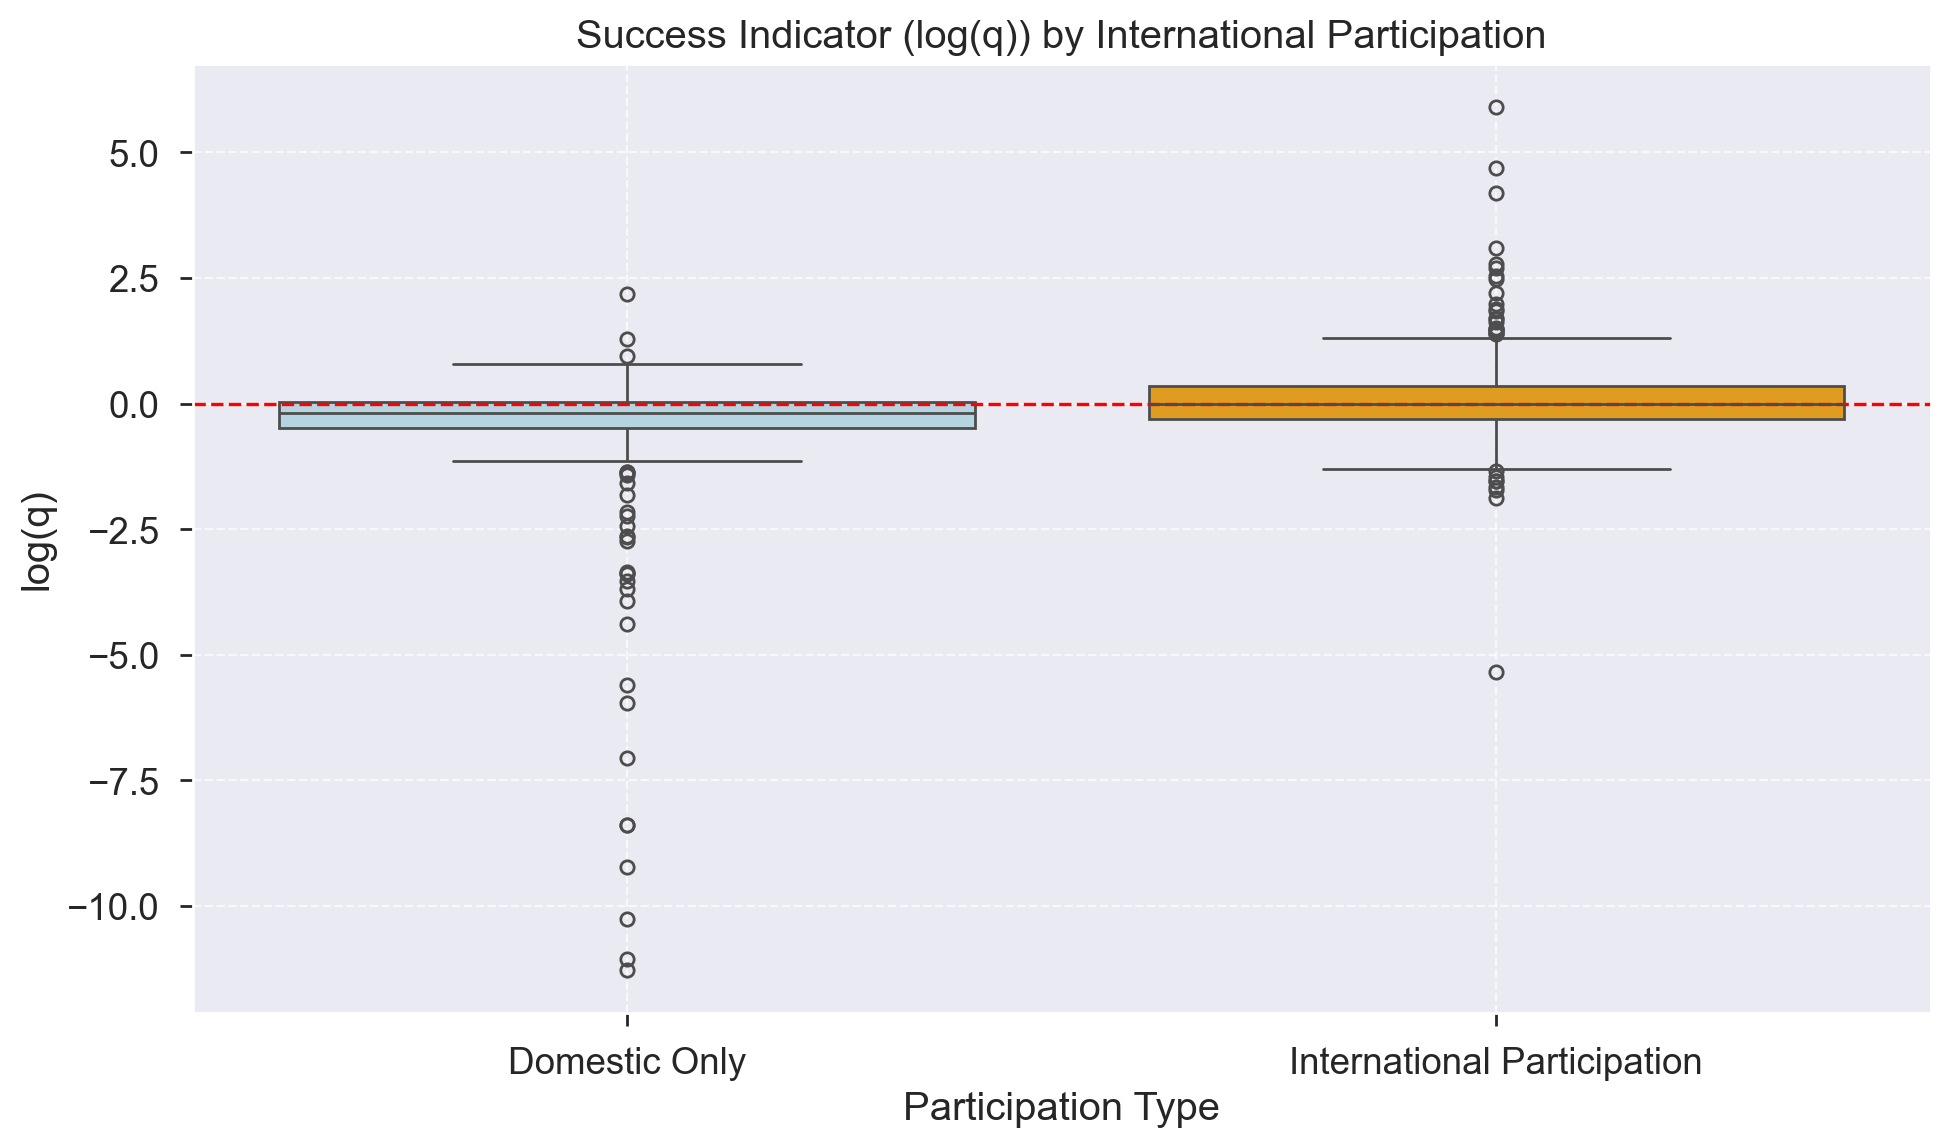

<Figure size 1000x600 with 0 Axes>

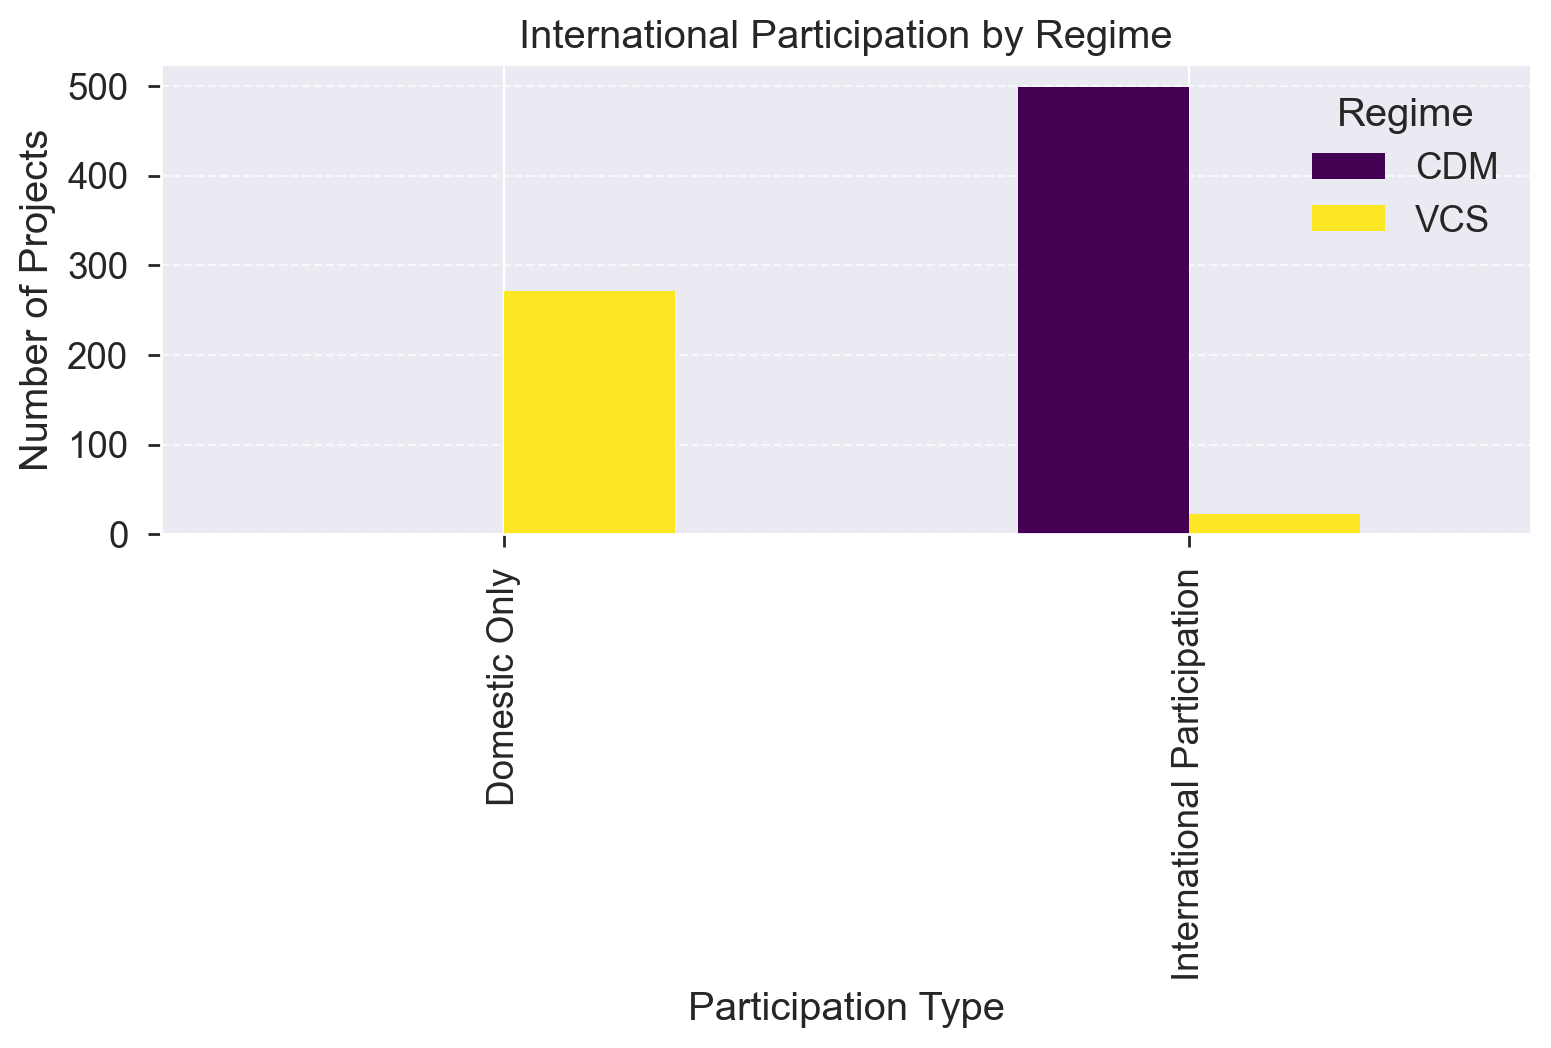

<Figure size 1000x600 with 0 Axes>

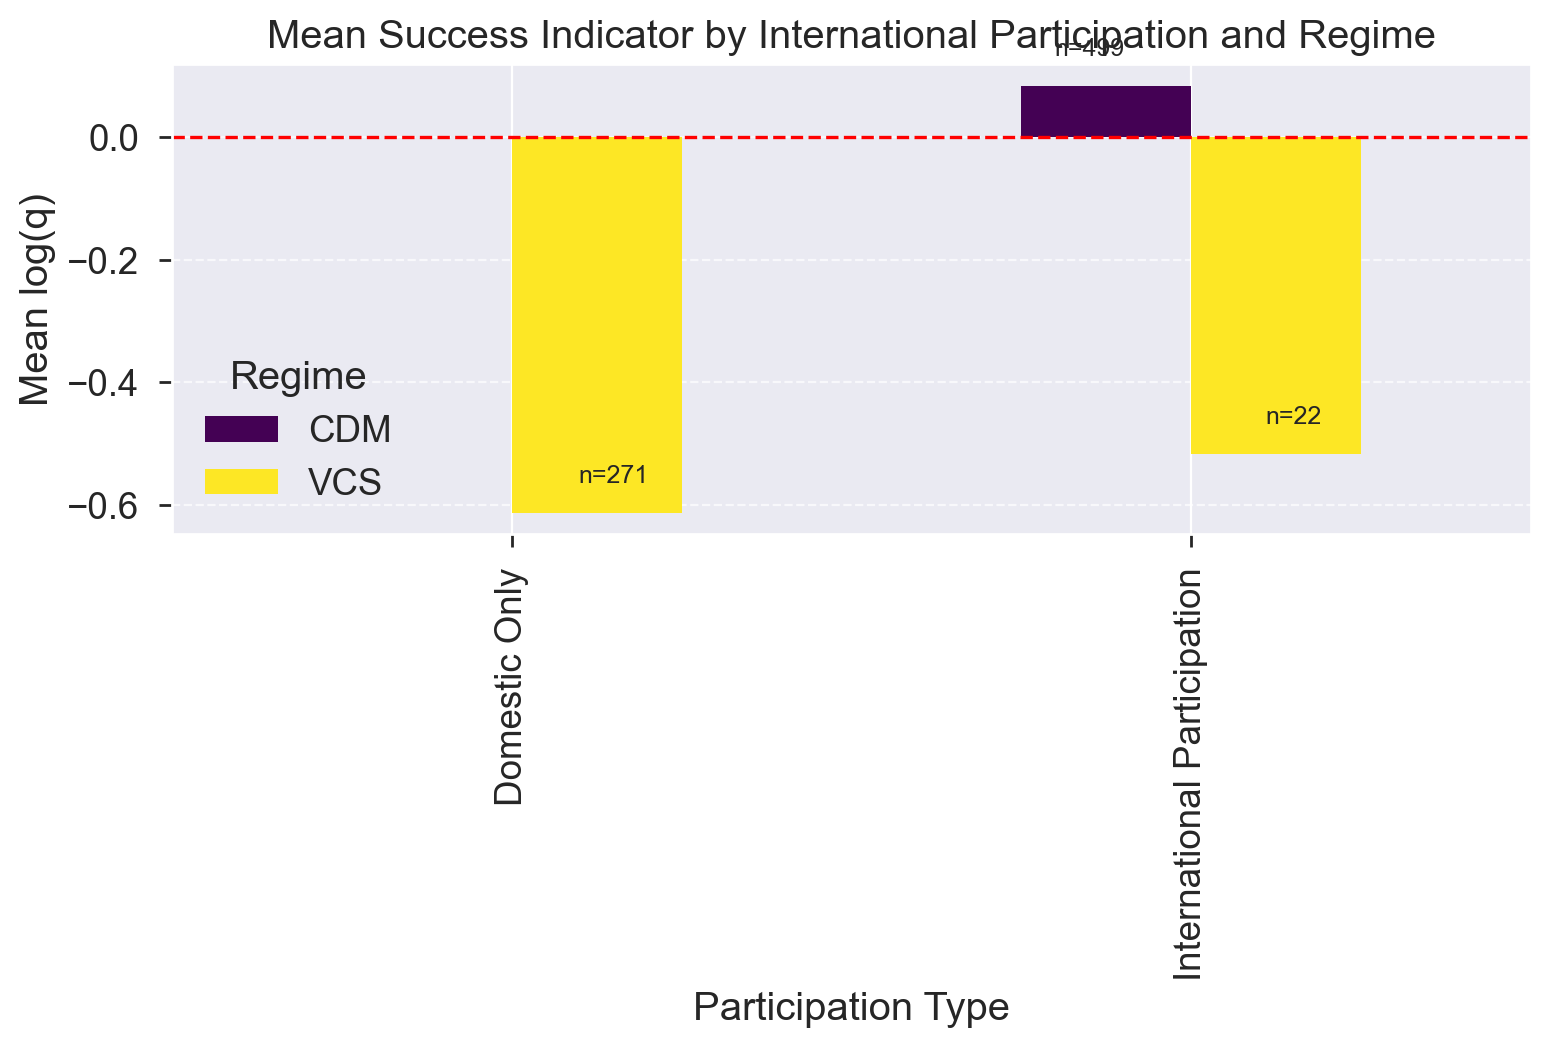

In [20]:
log_progress("International Participation Analysis", "Starting")

# Figure: Success Indicator by International Participation (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Int_Participation', y='log_q_success_indicator', data=df_valid, palette=['lightblue', 'orange'])
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Success Indicator (log(q)) by International Participation')
plt.xlabel('Participation Type')
plt.ylabel('log(q)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(FIG_SUCCESS_BY_INTL, dpi=300)

# Calculate summary statistics by international participation
int_summary = df_valid.groupby('Is_International')['log_q_success_indicator'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median',
    lambda x: (x > 0).mean() * 100  # % over-performing
]).rename(columns={'<lambda_0>': 'pct_over'})

# Add variance and percentage under-performing
int_summary['variance'] = df_valid.groupby('Is_International')['log_q_success_indicator'].var()
int_summary['pct_under'] = df_valid.groupby('Is_International')['log_q_success_indicator'].apply(
    lambda x: (x < 0).mean() * 100)

# Rename index for clarity
int_summary.index = ['Domestic Only', 'International Participation']

# Round values for better readability
int_summary = int_summary.round(4)

print("\nPerformance by International Participation:")
print(int_summary)

# T-test for international participation differences
domestic_data = df_valid[df_valid['Is_International'] == 0]['log_q_success_indicator']
intl_data = df_valid[df_valid['Is_International'] == 1]['log_q_success_indicator']

if len(domestic_data) >= MIN_COUNT_FOR_CATEGORY and len(intl_data) >= MIN_COUNT_FOR_CATEGORY:
    # Levene's test for equal variances
    levene_stat, levene_p = stats.levene(domestic_data, intl_data)
    equal_var = levene_p > 0.05
    
    # T-test
    t_stat, p_val = stats.ttest_ind(domestic_data, intl_data, equal_var=equal_var)
    
    print("\nT-test for International Participation Differences:")
    print(f"Domestic Only: n={len(domestic_data)}, mean={domestic_data.mean():.4f}")
    print(f"International Participation: n={len(intl_data)}, mean={intl_data.mean():.4f}")
    print(f"T-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("The difference in success between domestic and international projects is statistically significant")
    else:
        print("No statistically significant difference in success between domestic and international projects")

# Analyze international participation by regime
int_by_regime = pd.crosstab(df_valid['Is_International'], df_valid['Regime'])
int_by_regime.index = ['Domestic Only', 'International Participation']
int_by_regime_pct = pd.crosstab(df_valid['Is_International'], df_valid['Regime'], normalize='columns') * 100
int_by_regime_pct.index = ['Domestic Only', 'International Participation']

print("\nInternational Participation by Regime:")
print(int_by_regime)
print("\nInternational Participation by Regime (%):")
print(int_by_regime_pct.round(1))

# Plot international participation by regime
plt.figure(figsize=(10, 6))
int_by_regime.plot(kind='bar', colormap='viridis')
plt.title('International Participation by Regime')
plt.xlabel('Participation Type')
plt.ylabel('Number of Projects')
plt.legend(title='Regime')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'international_by_regime_count.png'), dpi=300)

# Calculate success by international participation and regime
int_regime_success = df_valid.groupby(['Is_International', 'Regime'])['log_q_success_indicator'].agg([
    'count', 'mean', 'std'
]).reset_index()
int_regime_success['Participation'] = int_regime_success['Is_International'].map({0: 'Domestic Only', 1: 'International Participation'})

# Create pivot tables for easier visualization
success_by_int_regime = int_regime_success.pivot(index='Participation', 
                                               columns='Regime', 
                                               values='mean')
counts_by_int_regime = int_regime_success.pivot(index='Participation', 
                                              columns='Regime', 
                                              values='count')

print("\nMean Success Indicator by International Participation and Regime:")
print(success_by_int_regime.round(4))
print("\nSample Sizes by International Participation and Regime:")
print(counts_by_int_regime)

# Plot success by international participation and regime
plt.figure(figsize=(10, 6))
success_by_int_regime.plot(kind='bar', colormap='viridis')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Mean Success Indicator by International Participation and Regime')
plt.xlabel('Participation Type')
plt.ylabel('Mean log(q)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Regime')

# Add sample size annotations
for i, participation in enumerate(success_by_int_regime.index):
    for j, regime in enumerate(['CDM', 'VCS']):
        if regime in counts_by_int_regime.columns and participation in counts_by_int_regime.index:
            count = counts_by_int_regime.loc[participation, regime]
            mean = success_by_int_regime.loc[participation, regime]
            if not pd.isna(count) and not pd.isna(mean):
                plt.text(i - 0.15 + j*0.3, mean + 0.05, f"n={int(count)}", 
                       ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'success_by_international_and_regime.png'), dpi=300)

log_progress("International Participation Analysis", "Completed")

## 6. Duration Analysis

This section examines the relationship between project duration and performance.

[2025-05-09 22:32:18] Duration Analysis: Starting

Project Duration Statistics (years):
count    792.000000
mean       6.004625
std        3.763797
min        0.010951
25%        2.997947
50%        5.544148
75%        8.835044
max       21.483915
Name: t_actual_years, dtype: float64

Project Duration by Regime:
        count  mean  median   std   min    max
Regime                                        
CDM       499  5.85    5.37  3.71  0.01  16.98
VCS       293  6.26    5.72  3.85  0.23  21.48


C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\202586565.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Regime_Display', y='t_actual_years', data=df_valid, palette=[REGIME_COLORS['VCS'], REGIME_COLORS['CDM']])
C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\202586565.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['log_t_actual_years'] = np.log(df_valid['t_actual_years'])
C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\202586565.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu


Correlations with Success Indicator:
t_actual_years       -0.102613
log_t_actual_years   -0.139711
Name: log_q_success_indicator, dtype: float64

Correlations between log(t) and log(q) by Regime:
  VCS: 0.3395
  CDM: -0.7351

Performance by Duration Bin:
              count    mean     std  median
Duration_Bin                               
0-2 years       128 -0.1354  2.6483  0.5068
2-4 years       146 -0.0610  0.6837  0.0511
4-6 years       167 -0.0568  0.4935 -0.0201
6-8 years       120 -0.0634  0.4737 -0.0247
8-10 years      112 -0.3026  0.3499 -0.2531
10+ years       119 -0.4891  1.0590 -0.4138
[2025-05-09 22:32:21] Duration Analysis: Completed


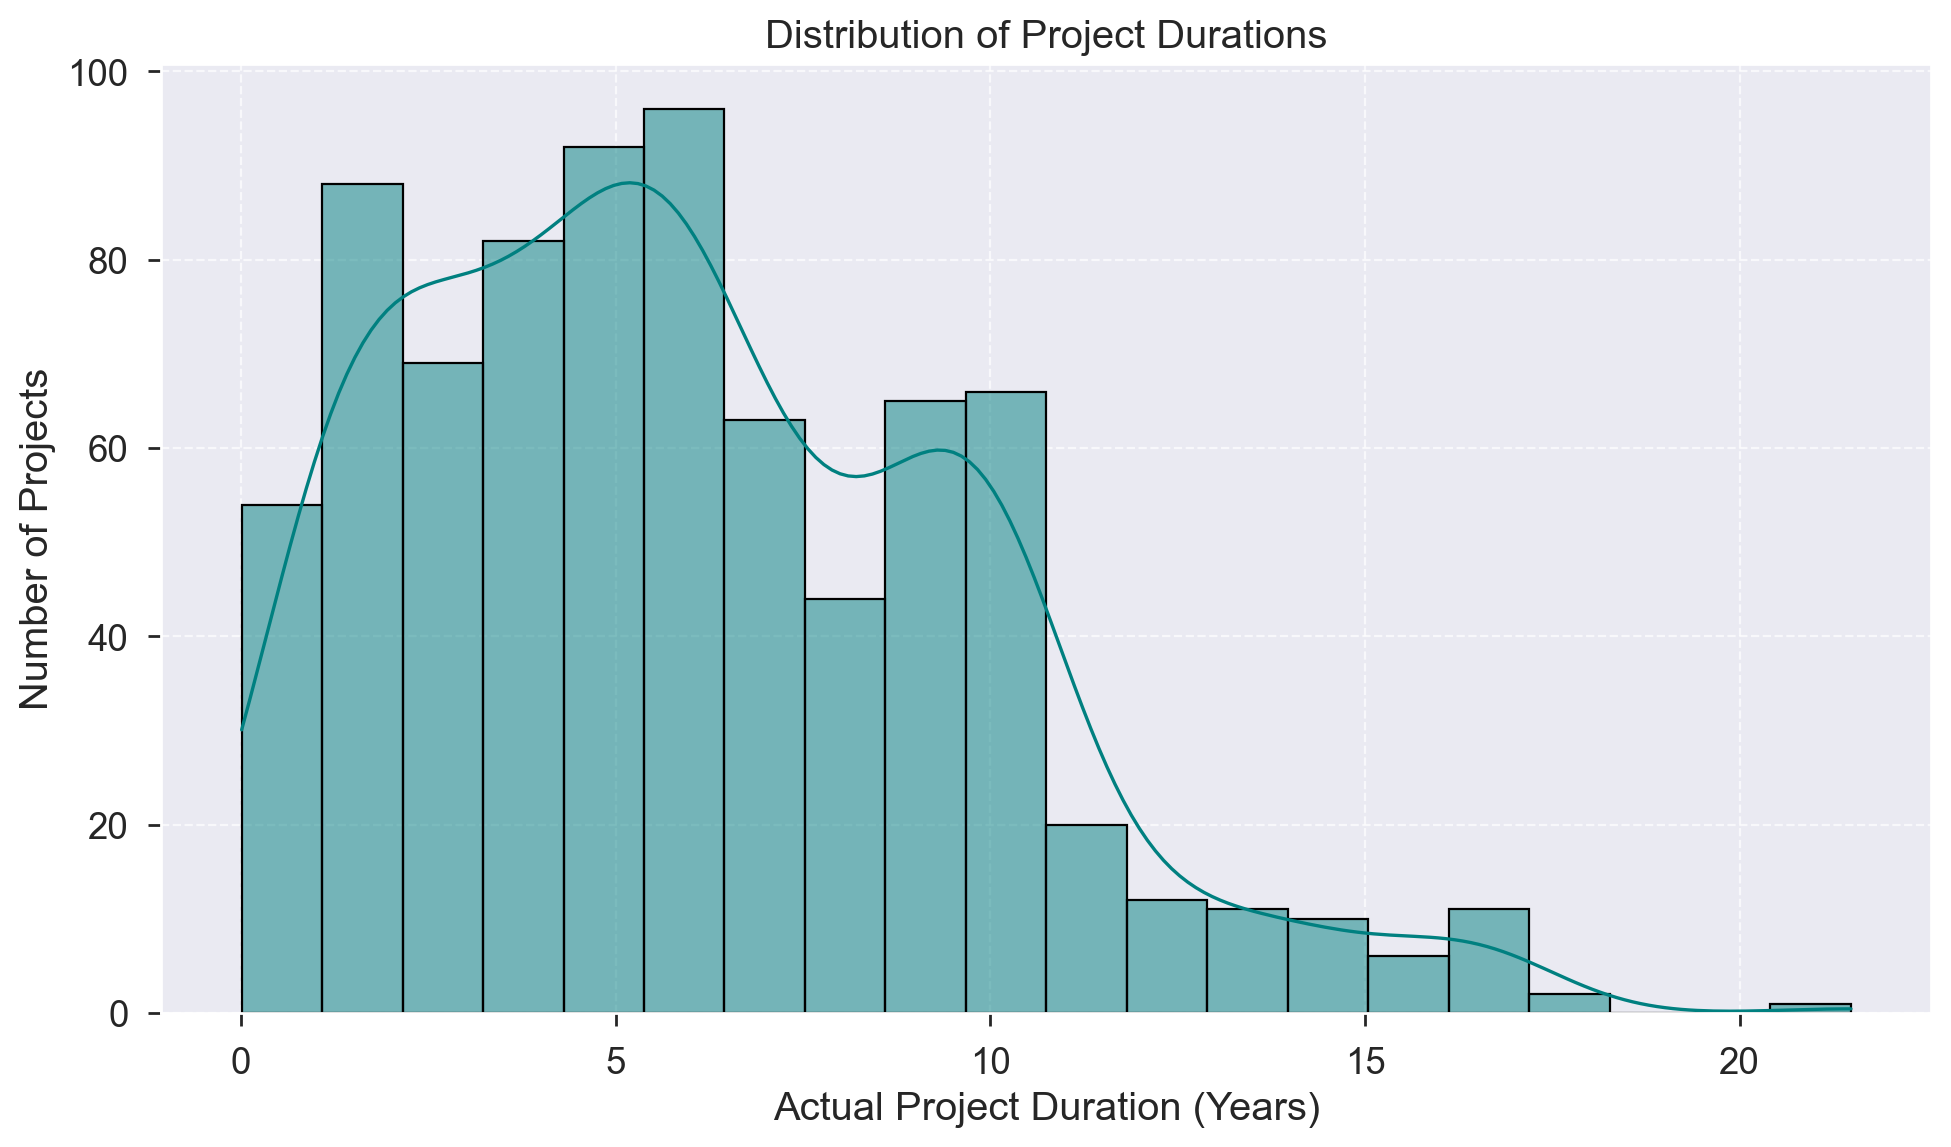

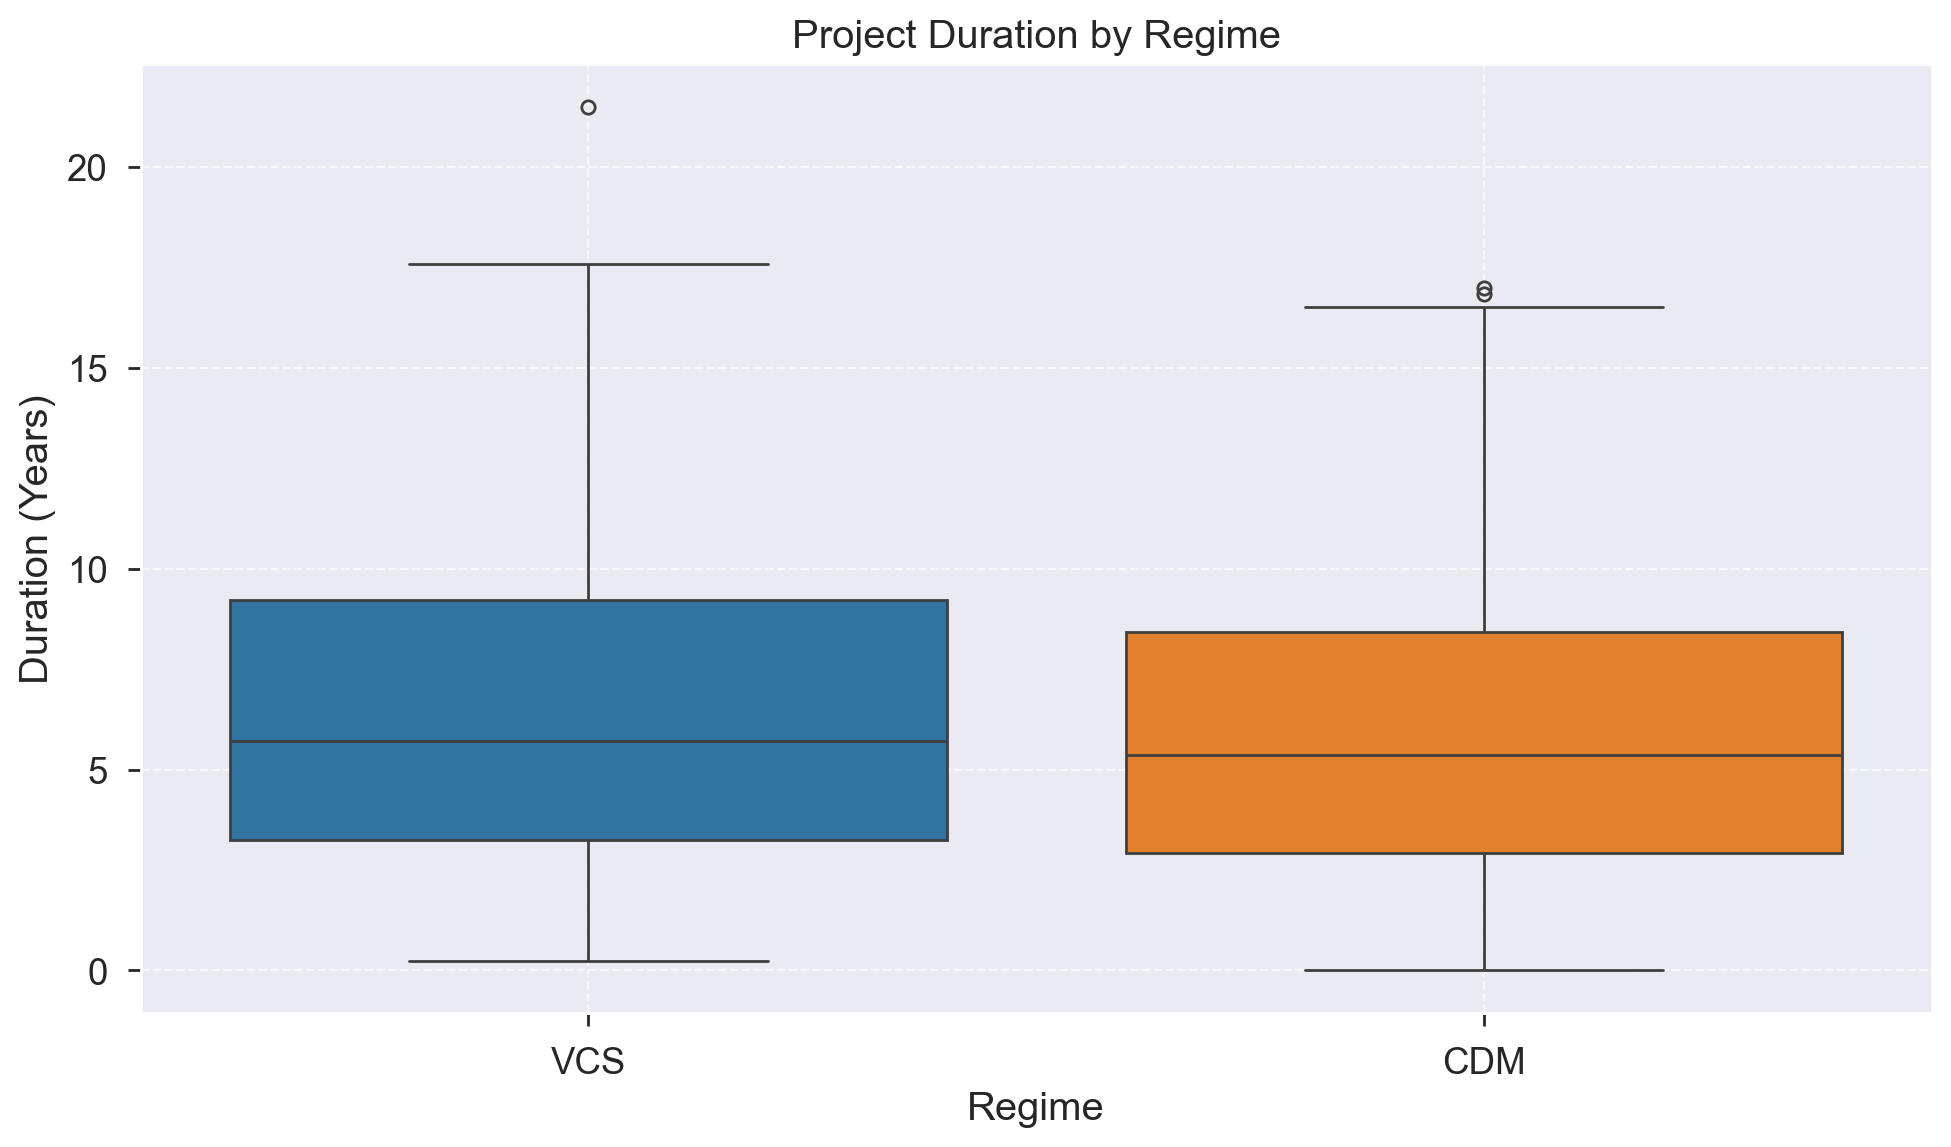

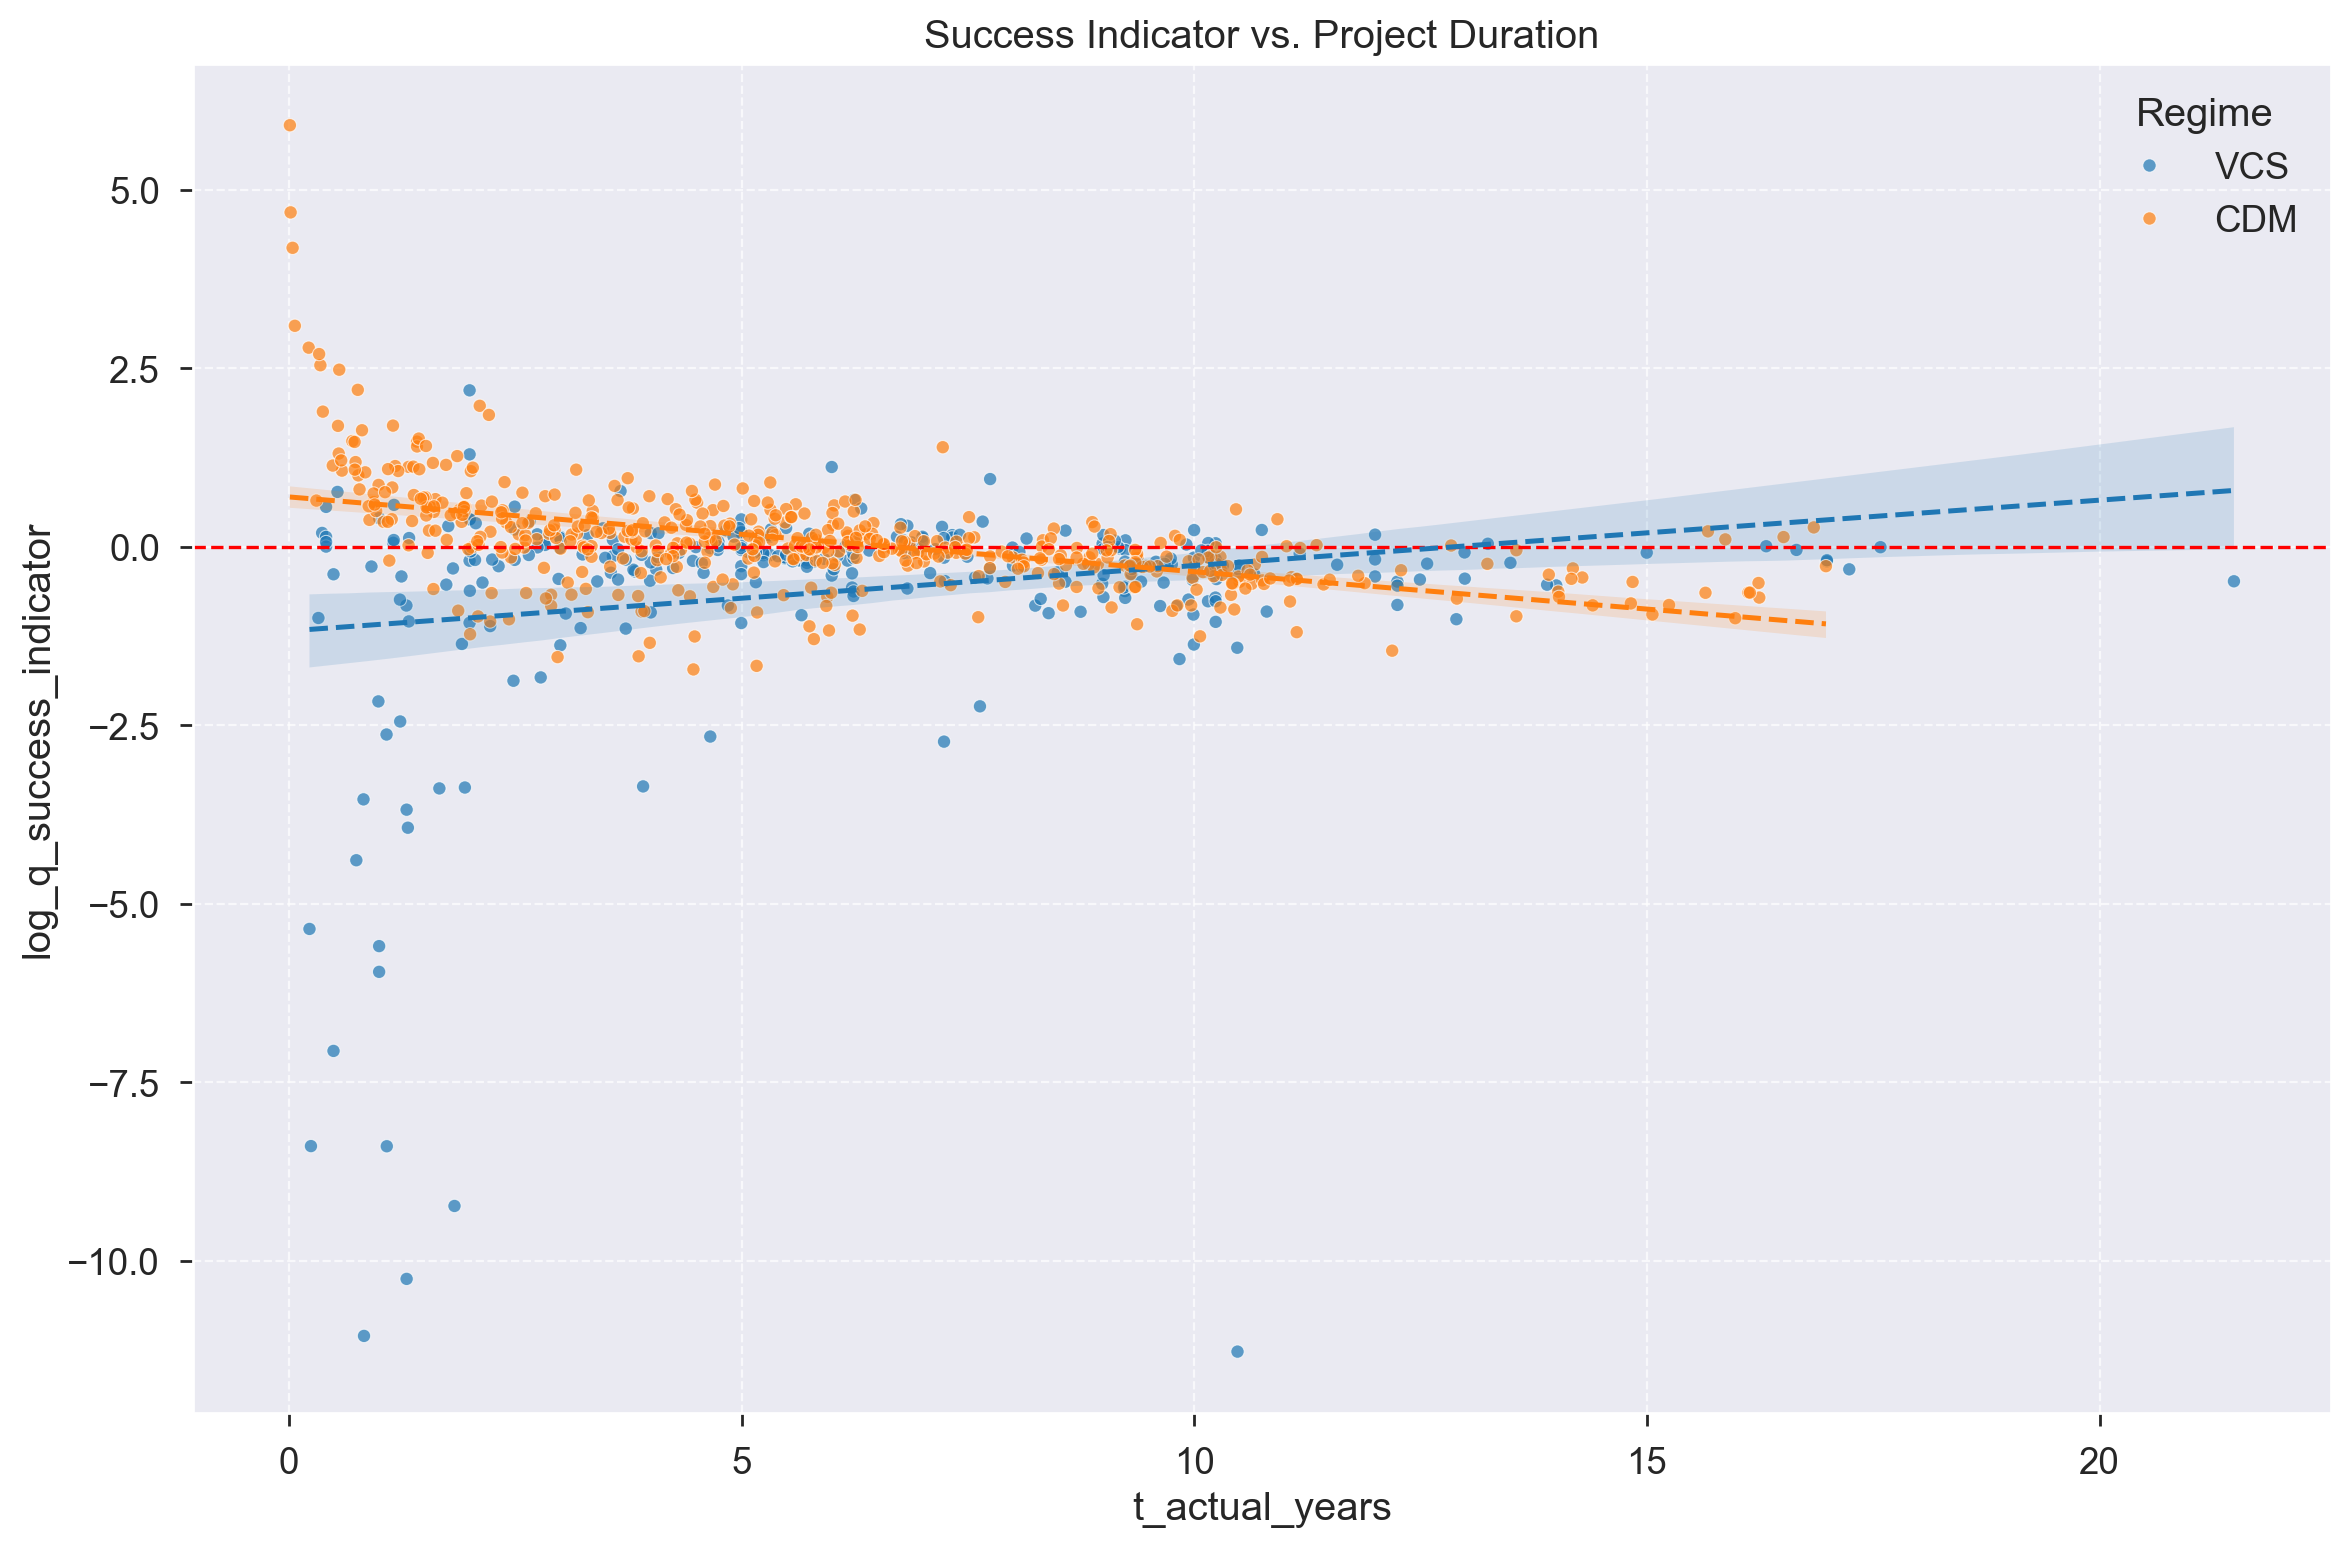

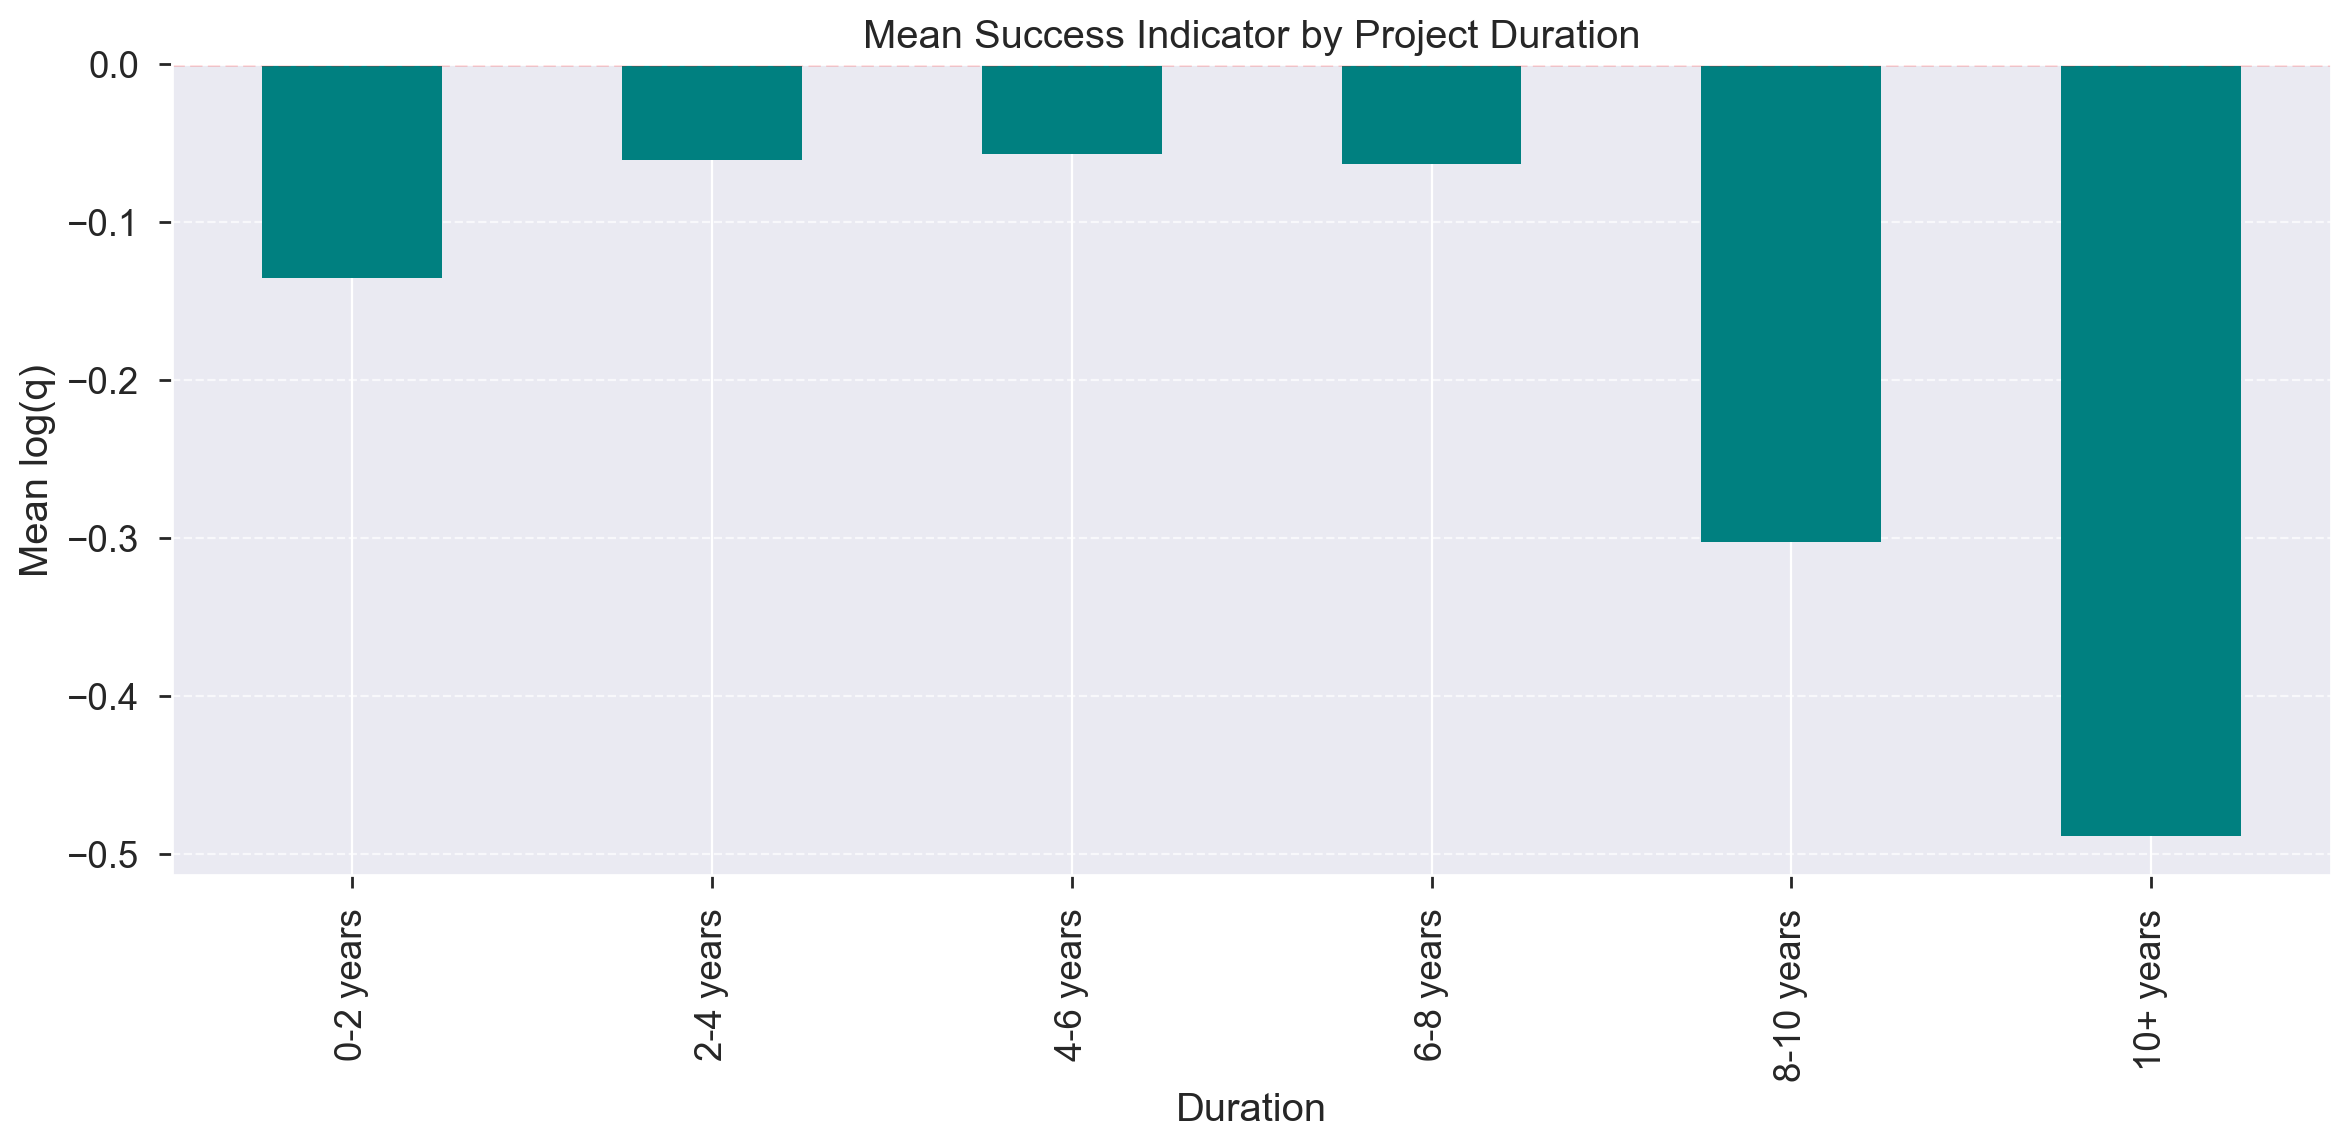

In [21]:
log_progress("Duration Analysis", "Starting")

# Figure: Project Duration Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_valid['t_actual_years'], bins=20, kde=True, color='teal')
plt.title('Distribution of Project Durations')
plt.xlabel('Actual Project Duration (Years)')
plt.ylabel('Number of Projects')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(FIG_DURATION_DIST, dpi=300)

# Calculate summary statistics for duration
duration_stats = df_valid['t_actual_years'].describe()
print("\nProject Duration Statistics (years):")
print(duration_stats)

# Compare duration by regime
duration_by_regime = df_valid.groupby('Regime')['t_actual_years'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
print("\nProject Duration by Regime:")
print(duration_by_regime.round(2))

# Plot duration by regime
plt.figure(figsize=(10, 6))
sns.boxplot(x='Regime_Display', y='t_actual_years', data=df_valid, palette=[REGIME_COLORS['VCS'], REGIME_COLORS['CDM']])
plt.title('Project Duration by Regime')
plt.xlabel('Regime')
plt.ylabel('Duration (Years)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(FIG_DURATION_BY_REGIME, dpi=300)

# Figure: Success vs Duration (Scatter plot)
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='t_actual_years', y='log_q_success_indicator', 
                        hue='Regime', data=df_valid, 
                        palette=[REGIME_COLORS['VCS'], REGIME_COLORS['CDM']], 
                        alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Success Indicator vs. Project Duration')
plt.xlabel('Project Duration (Years)')
plt.ylabel('log(q)')
plt.grid(True, linestyle='--', alpha=0.7)

# Add regression lines for each regime
for regime, color in REGIME_COLORS.items():
    regime_data = df_valid[df_valid['Regime'] == regime]
    if len(regime_data) >= MIN_COUNT_FOR_CATEGORY:
        sns.regplot(x='t_actual_years', y='log_q_success_indicator', 
                   data=regime_data, scatter=False, 
                   line_kws={'color': color, 'linestyle': '--'})

plt.legend(title='Regime')
plt.tight_layout()
plt.savefig(FIG_SUCCESS_VS_DURATION, dpi=300)

# Create log(t) for additional analysis
df_valid['log_t_actual_years'] = np.log(df_valid['t_actual_years'])

# Calculate correlation between duration and success
overall_corr = df_valid[['t_actual_years', 'log_t_actual_years', 'log_q_success_indicator']].corr()
print("\nCorrelations with Success Indicator:")
print(overall_corr['log_q_success_indicator'].drop('log_q_success_indicator'))

# Calculate correlations by regime
regime_correlations = {}
for regime in df_valid['Regime'].unique():
    regime_df = df_valid[df_valid['Regime'] == regime]
    if len(regime_df) >= MIN_COUNT_FOR_CATEGORY:
        regime_corr = regime_df[['t_actual_years', 'log_t_actual_years', 'log_q_success_indicator']].corr()
        regime_correlations[regime] = regime_corr['log_q_success_indicator']['log_t_actual_years']

print("\nCorrelations between log(t) and log(q) by Regime:")
for regime, corr in regime_correlations.items():
    print(f"  {regime}: {corr:.4f}")

# Bin projects by duration and analyze performance
df_valid['Duration_Bin'] = pd.cut(df_valid['t_actual_years'], 
                               bins=[0, 2, 4, 6, 8, 10, float('inf')],
                               labels=['0-2 years', '2-4 years', '4-6 years', 
                                      '6-8 years', '8-10 years', '10+ years'])

duration_bin_stats = df_valid.groupby('Duration_Bin')['log_q_success_indicator'].agg([
    'count', 'mean', 'std', 'median'
]).round(4)

print("\nPerformance by Duration Bin:")
print(duration_bin_stats)

# Plot mean success by duration bin
plt.figure(figsize=(12, 6))
duration_bin_stats['mean'].plot(kind='bar', color='teal')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Mean Success Indicator by Project Duration')
plt.xlabel('Duration')
plt.ylabel('Mean log(q)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'mean_success_by_duration.png'), dpi=300)

log_progress("Duration Analysis", "Completed")

## 7. Correlation Analysis

This section examines correlations between key variables to identify potential relationships.

[2025-05-09 22:32:22] Correlation Analysis: Starting

Correlation Matrix:
                                      log_q_success_indicator  t_actual_years  \
log_q_success_indicator                                 1.000          -0.103   
t_actual_years                                         -0.103           1.000   
log_t_actual_years                                     -0.140           0.860   
Scale_Large                                            -0.052           0.016   
Is_International                                        0.260          -0.072   
Is_CDM                                                  0.272          -0.053   
Total_Actual_VCUs_Issued                                0.025           0.151   
Estimated Annual Emission Reductions                   -0.152          -0.061   

                                      log_t_actual_years  Scale_Large  \
log_q_success_indicator                           -0.140       -0.052   
t_actual_years                                    

C:\Users\DELL\AppData\Local\Temp\ipykernel_29644\3079629189.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Is_CDM'] = (df_valid['Regime'] == 'CDM').astype(int)



Correlations with Success Indicator (sorted):
Is_CDM                                  0.272
Is_International                        0.260
Total_Actual_VCUs_Issued                0.025
Scale_Large                            -0.052
t_actual_years                         -0.103
log_t_actual_years                     -0.140
Estimated Annual Emission Reductions   -0.152
Name: log_q_success_indicator, dtype: float64

Correlations with Success Indicator by Regime:

VCS:
log_t_actual_years                      0.339477
t_actual_years                          0.210107
Total_Actual_VCUs_Issued                0.097925
Scale_Large                             0.028924
Is_International                        0.015100
Estimated Annual Emission Reductions   -0.129892
Name: log_q_success_indicator, dtype: float64

CDM:
Total_Actual_VCUs_Issued               -0.010369
Scale_Large                            -0.076119
Estimated Annual Emission Reductions   -0.081307
t_actual_years                        

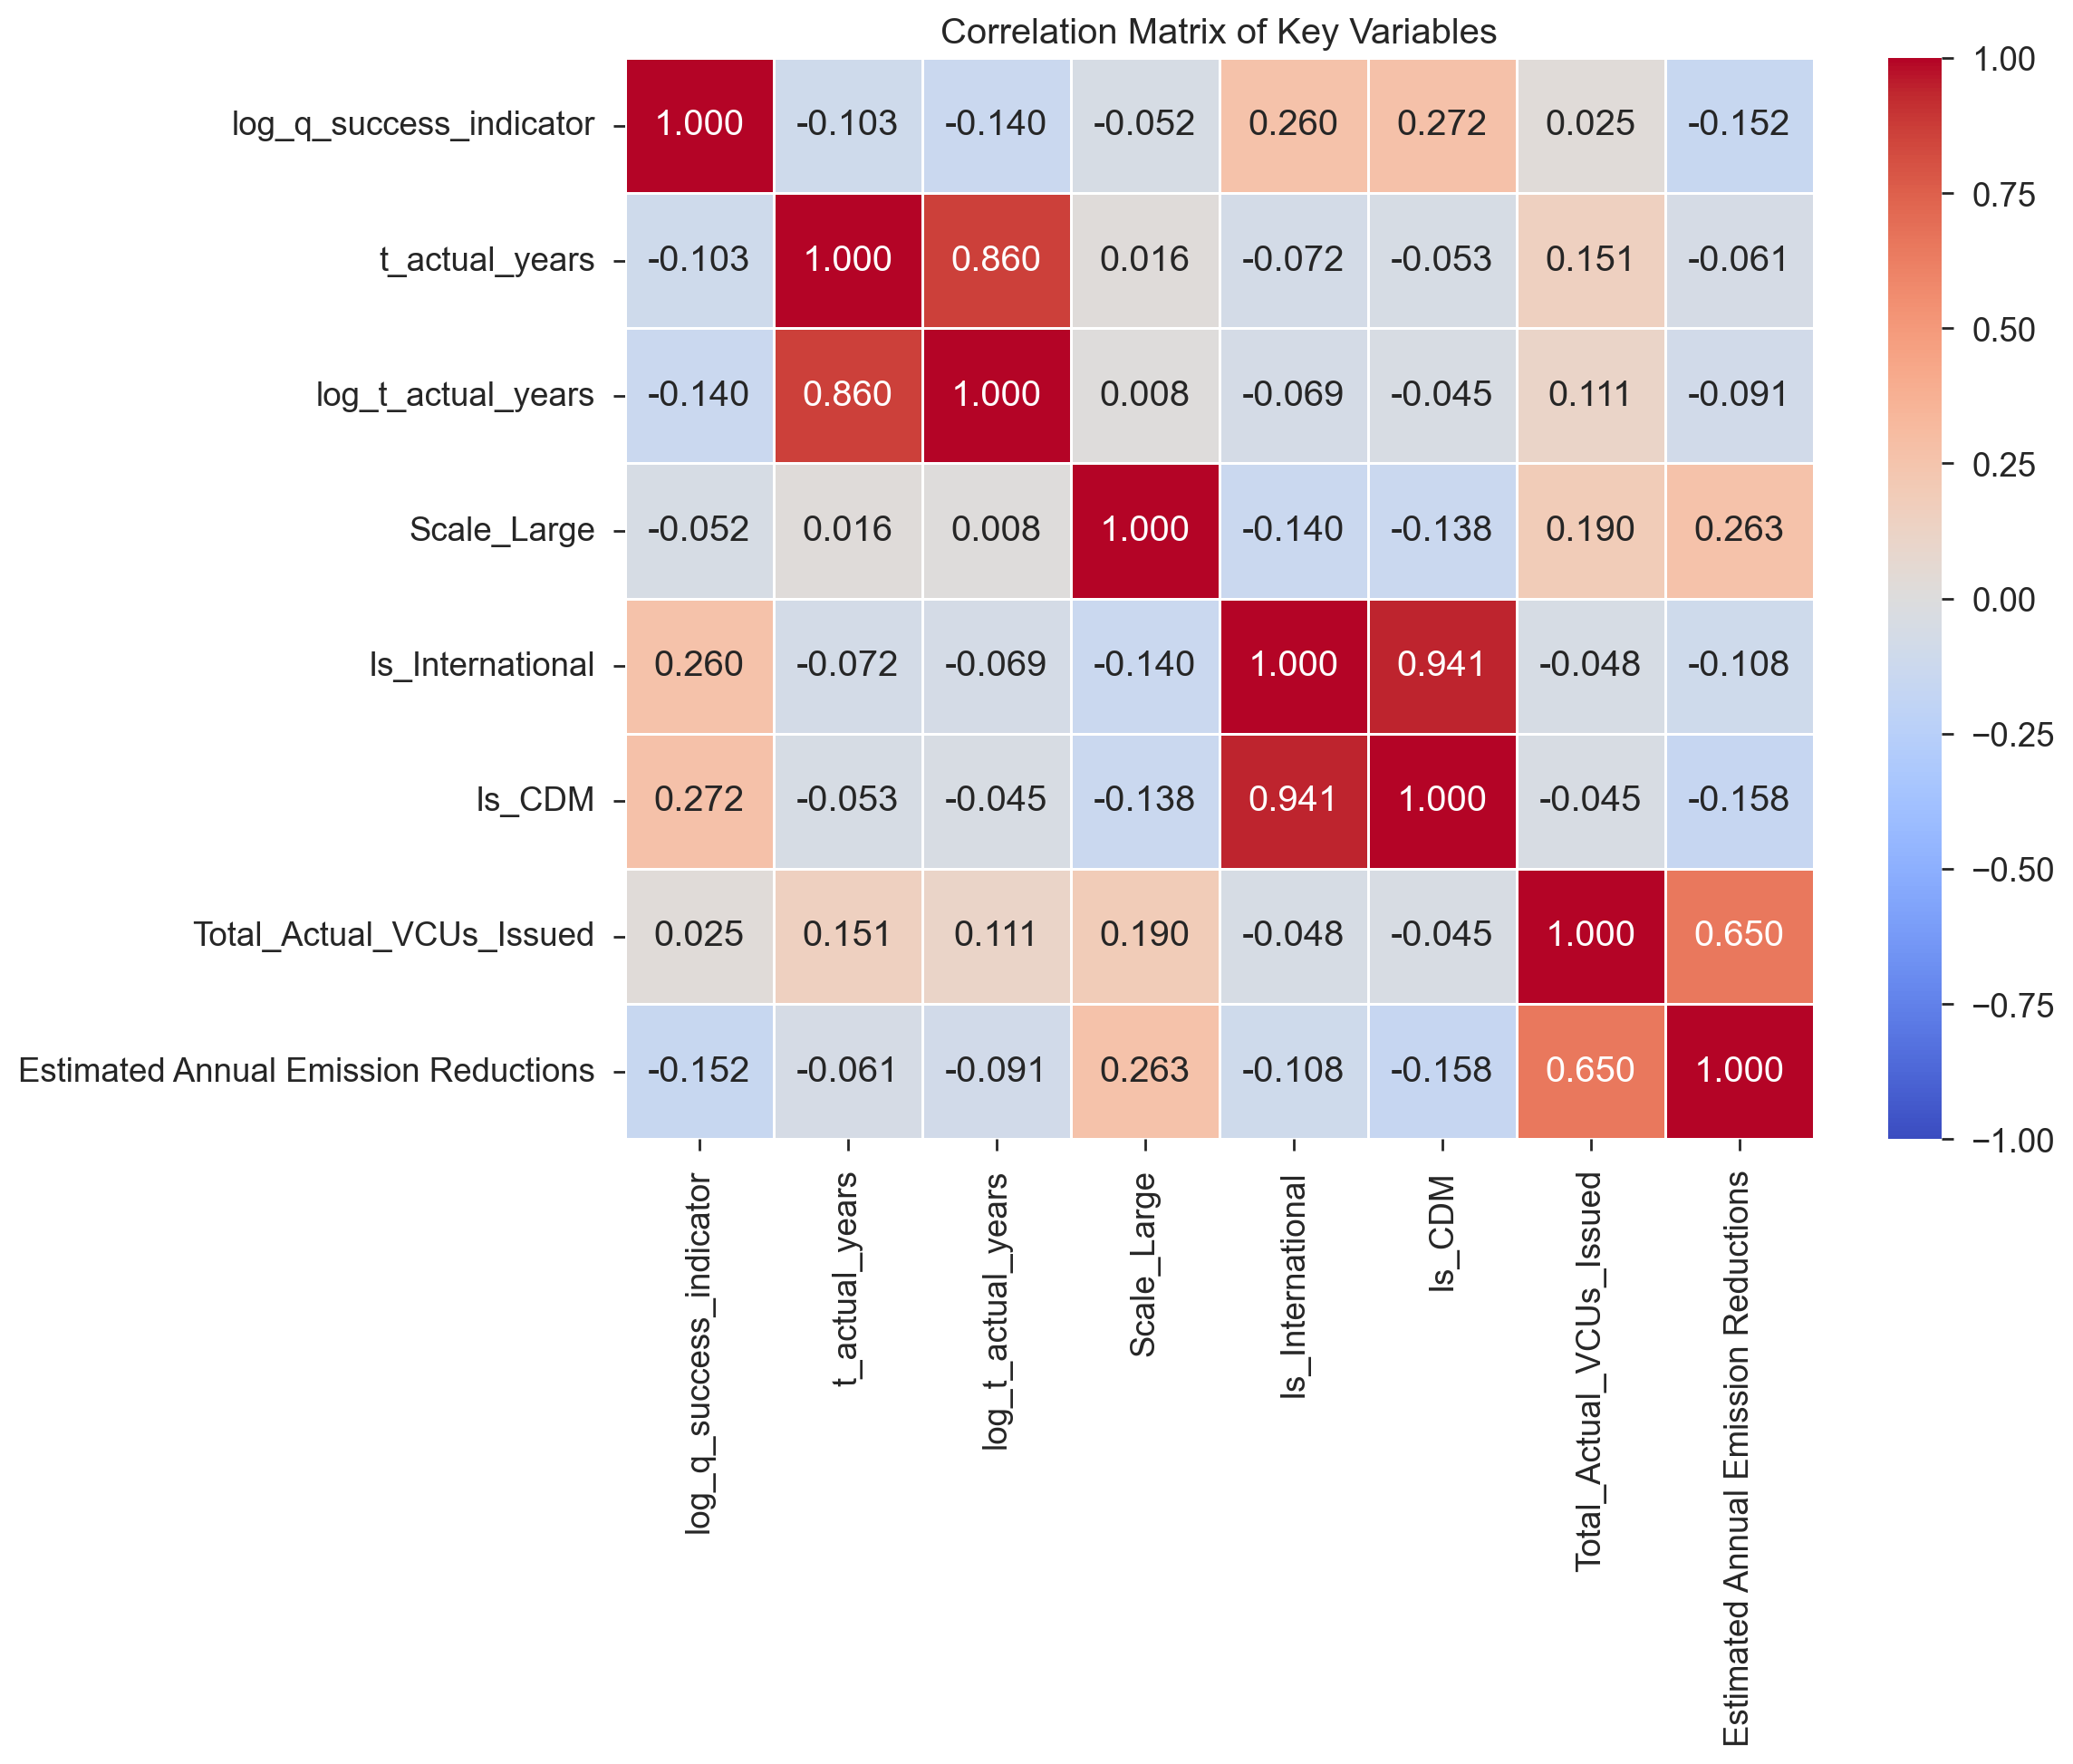

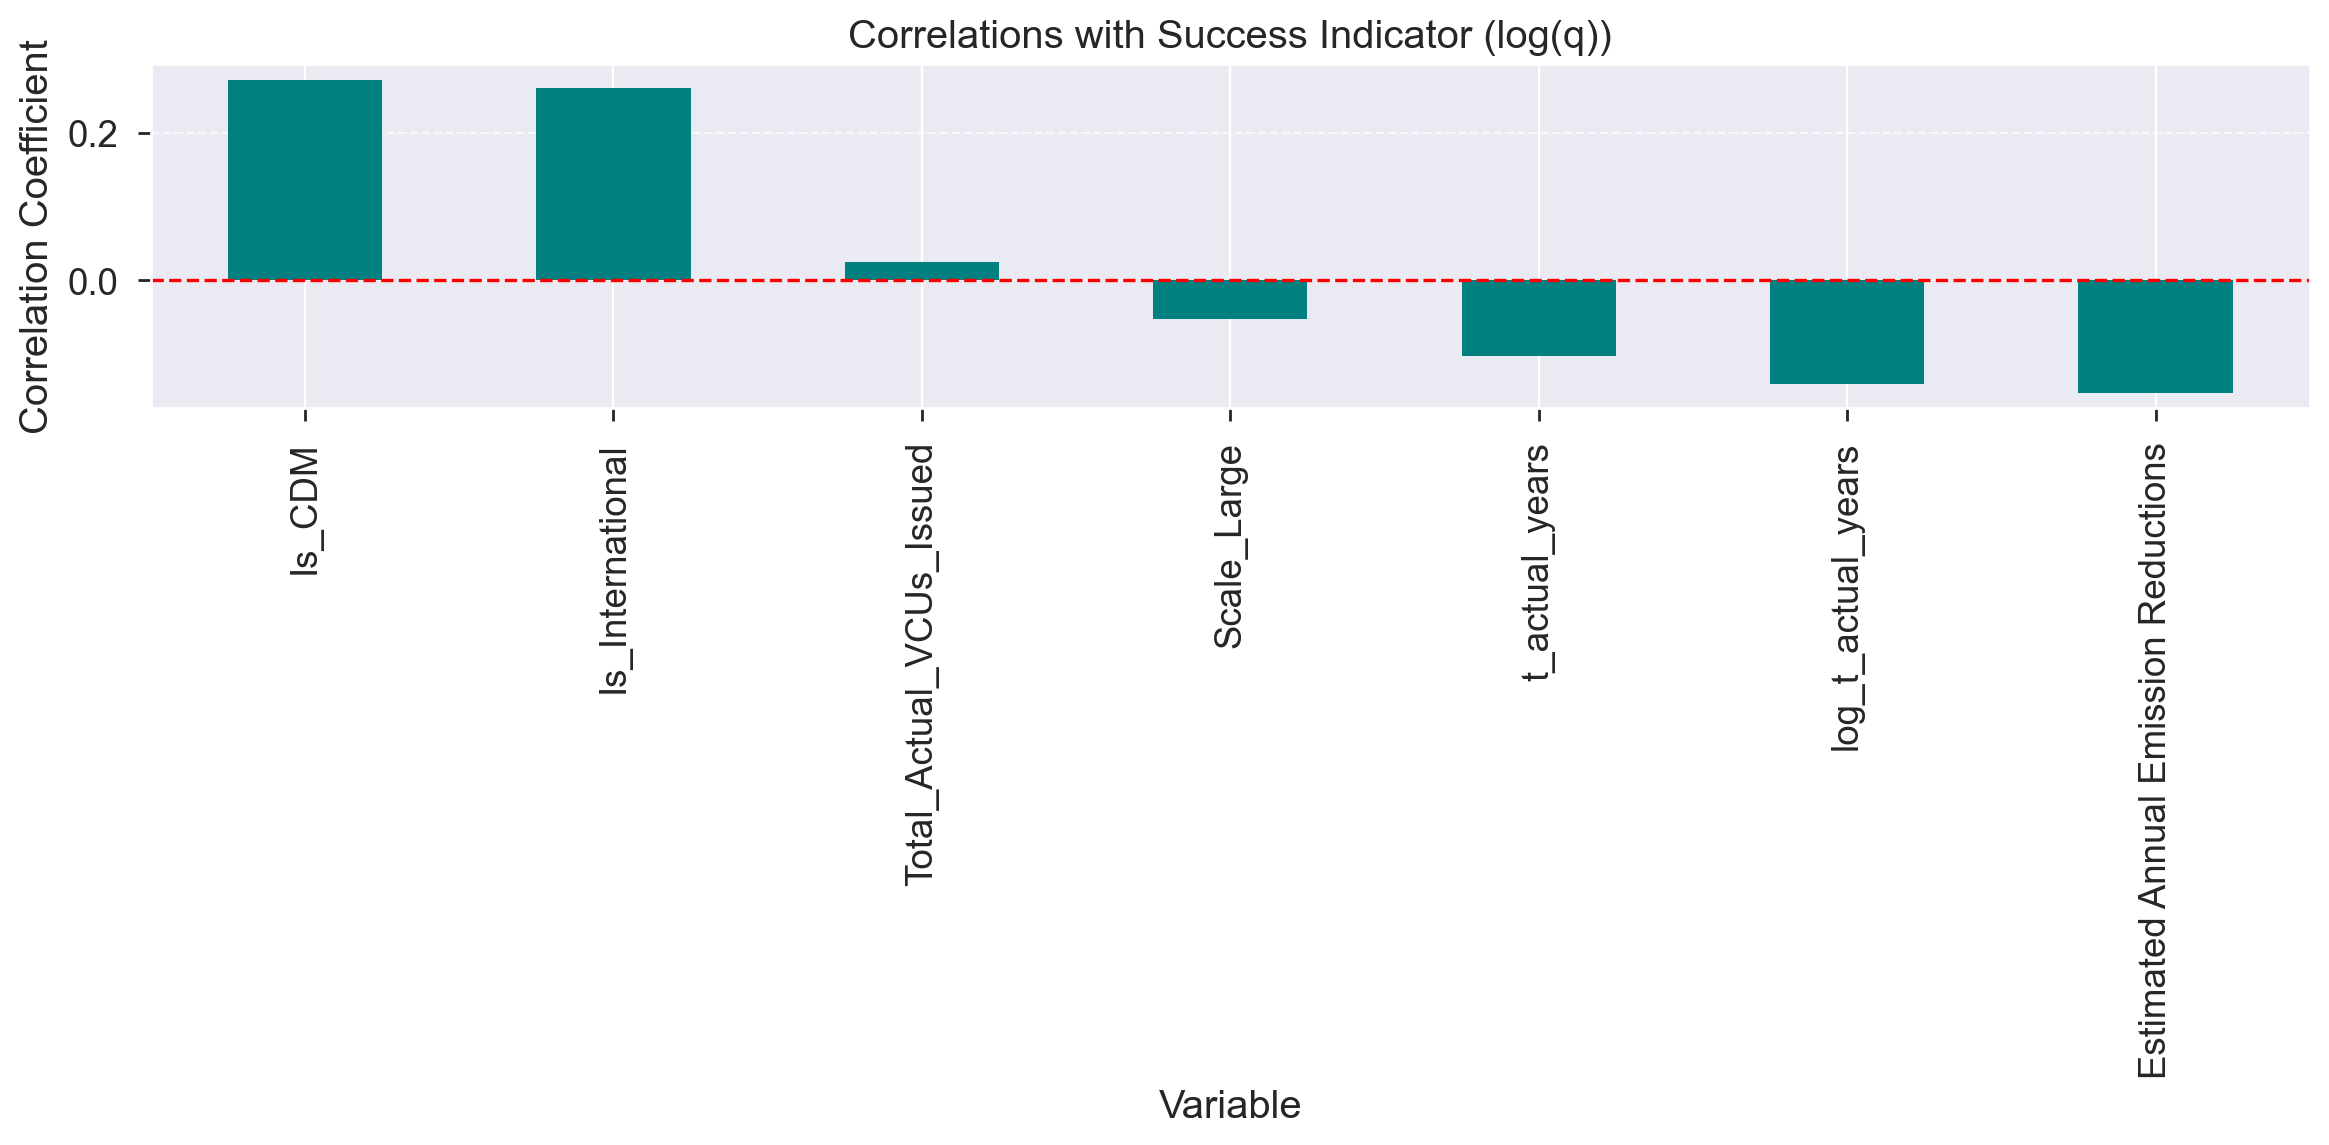

<Figure size 1000x600 with 0 Axes>

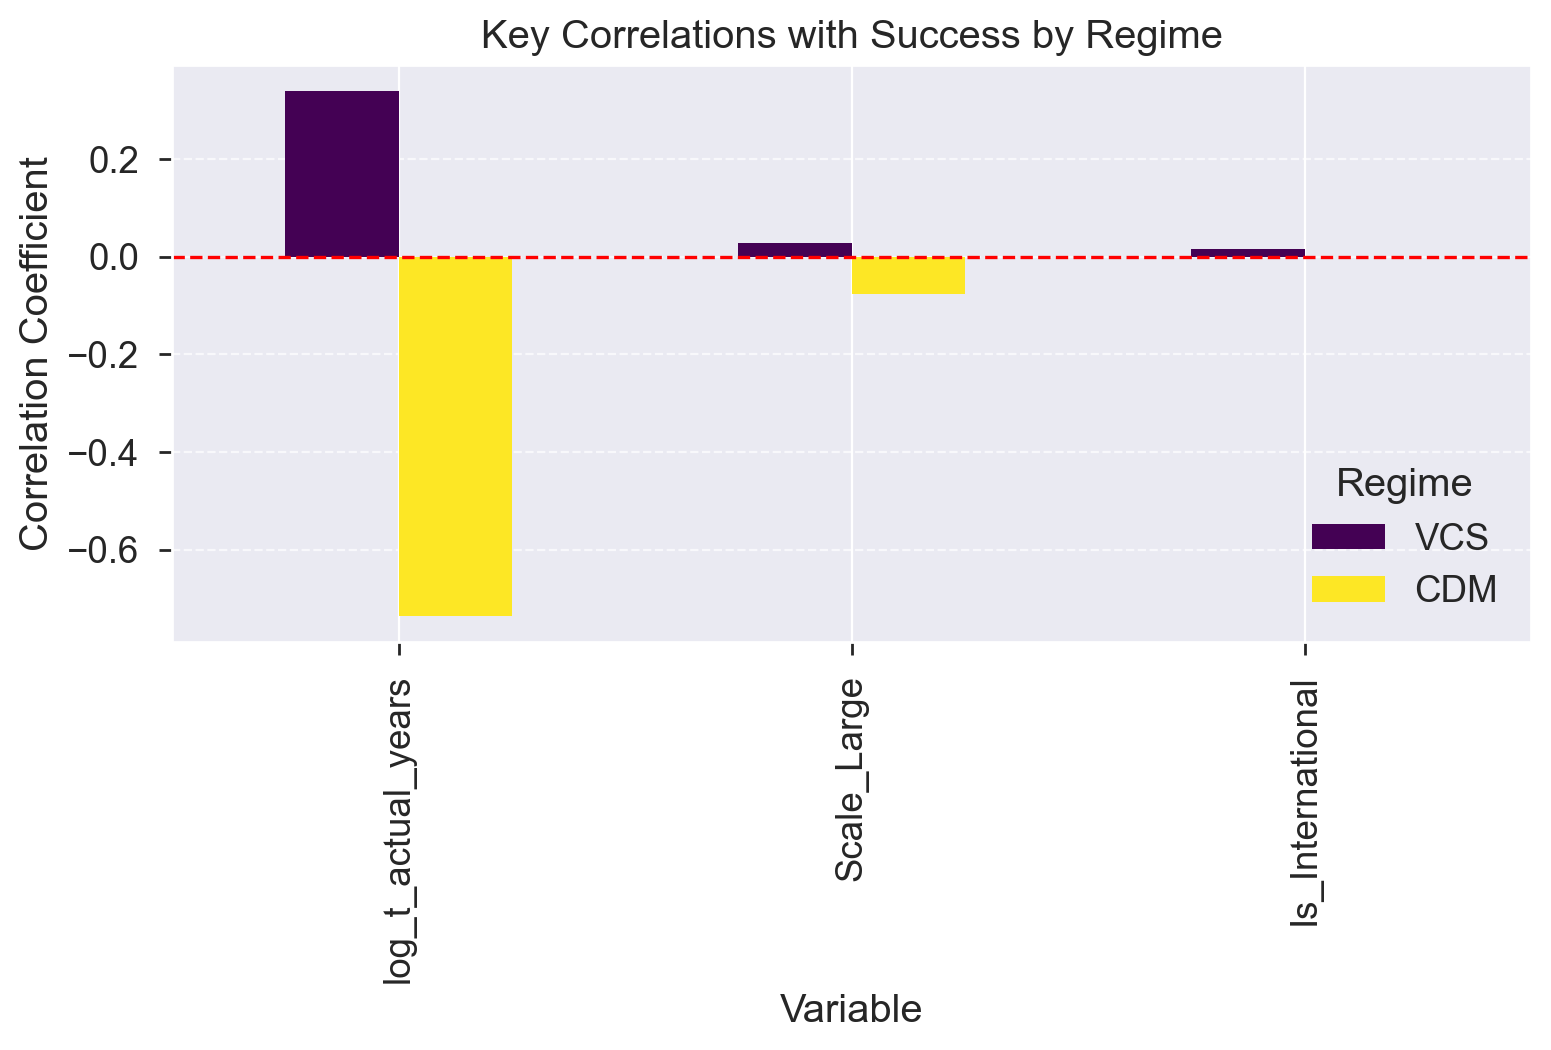

In [22]:
log_progress("Correlation Analysis", "Starting")

# Select key variables for correlation analysis
corr_vars = ['log_q_success_indicator', 't_actual_years', 'log_t_actual_years', 
             'Scale_Large', 'Is_International', 'Is_CDM', 
             'Total_Actual_VCUs_Issued', 'Estimated Annual Emission Reductions']

# Create dummy variable for CDM
df_valid['Is_CDM'] = (df_valid['Regime'] == 'CDM').astype(int)

# Calculate correlation matrix
corr_matrix = df_valid[corr_vars].corr().round(3)
print("\nCorrelation Matrix:")
print(corr_matrix)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.savefig(FIG_CORRELATION_MATRIX, dpi=300)

# Focus on correlations with success indicator
success_corr = corr_matrix['log_q_success_indicator'].drop('log_q_success_indicator').sort_values(ascending=False)
print("\nCorrelations with Success Indicator (sorted):")
print(success_corr)

# Create a bar chart of correlations with success indicator
plt.figure(figsize=(12, 6))
success_corr.plot(kind='bar', color='teal')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Correlations with Success Indicator (log(q))')
plt.xlabel('Variable')
plt.ylabel('Correlation Coefficient')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'correlations_with_success.png'), dpi=300)

# Calculate correlations by regime
regime_correlations = {}
for regime in df_valid['Regime'].unique():
    regime_df = df_valid[df_valid['Regime'] == regime]
    if len(regime_df) >= MIN_COUNT_FOR_CATEGORY:
        # Exclude Is_CDM as it's constant within a regime
        regime_vars = [var for var in corr_vars if var != 'Is_CDM']
        regime_corr = regime_df[regime_vars].corr()
        regime_correlations[regime] = regime_corr['log_q_success_indicator'].drop('log_q_success_indicator')

print("\nCorrelations with Success Indicator by Regime:")
for regime, corrs in regime_correlations.items():
    print(f"\n{regime}:")
    print(corrs.sort_values(ascending=False))

# Create side-by-side comparison of key correlations by regime
if len(regime_correlations) >= 2:
    # Select variables to compare
    compare_vars = ['log_t_actual_years', 'Scale_Large', 'Is_International']
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({regime: corrs[compare_vars] 
                                 for regime, corrs in regime_correlations.items()})
    
    print("\nKey Correlation Comparison by Regime:")
    print(comparison_df.round(3))
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    comparison_df.plot(kind='bar', colormap='viridis')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Key Correlations with Success by Regime')
    plt.xlabel('Variable')
    plt.ylabel('Correlation Coefficient')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Regime')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'correlation_comparison_by_regime.png'), dpi=300)

log_progress("Correlation Analysis", "Completed")

## 8. Summary and Compilation

This section compiles the key findings into a comprehensive report.

In [23]:
log_progress("Summary Compilation", "Starting")

# Compile all factor summaries
factor_summaries = pd.concat([
    tech_summary.assign(Factor='Technology'),
    scale_summary.assign(Factor='Scale'),
    int_summary.assign(Factor='International')
])

# Save factor summaries
factor_summaries.to_csv(FACTOR_SUMMARY_OUTPUT)

# Create regime summary
regime_summary = df_valid.groupby('Regime')['log_q_success_indicator'].agg([
    'count', 'mean', 'std', 'median', 'min', 'max',
    lambda x: (x > 0).mean() * 100,  # % over-performing
    lambda x: (x < 0).mean() * 100   # % under-performing
]).rename(columns={'<lambda_0>': 'pct_over', '<lambda_1>': 'pct_under'})

regime_summary.to_csv(REGIME_SUMMARY_OUTPUT)

# Create a comprehensive descriptive analysis report
with open(REPORT_OUTPUT, 'w') as f:
    f.write("DESCRIPTIVE ANALYSIS REPORT FOR CARBON CREDIT PROJECTS IN INDIA\n")
    f.write("="*60 + "\n\n")
    
    f.write("1. OVERVIEW AND DATA SUMMARY\n")
    f.write("-"*60 + "\n")
    f.write(f"Total projects analyzed: {len(df_valid)}\n")
    f.write(f"  VCS projects: {(df_valid['Regime'] == 'VCS').sum()}\n")
    f.write(f"  CDM projects: {(df_valid['Regime'] == 'CDM').sum()}\n\n")
    
    f.write("2. OVERALL SUCCESS INDICATOR (log(q)) STATISTICS\n")
    f.write("-"*60 + "\n")
    f.write(success_stats.to_string() + "\n")
    f.write(f"Variance: {df_valid['log_q_success_indicator'].var():.4f}\n\n")
    
    f.write(f"Performance relative to estimates:\n")
    f.write(f"  Over-performance (log(q) > 0): {over_performance:.1f}%\n")
    f.write(f"  Under-performance (log(q) < 0): {under_performance:.1f}%\n")
    f.write(f"  As expected (log(q) = 0): {as_expected:.1f}%\n\n")
    
    f.write("3. REGIME COMPARISON\n")
    f.write("-"*60 + "\n")
    f.write("Success indicator statistics by regime:\n")
    f.write(regime_summary.to_string() + "\n\n")
    
    if 'p_val' in locals():
        f.write(f"T-test for difference in means between regimes:\n")
        f.write(f"  t-statistic: {t_stat:.4f}, p-value: {p_val:.4f}\n")
        if p_val < 0.05:
            f.write("  The difference in success between VCS and CDM projects is statistically significant\n\n")
        else:
            f.write("  No statistically significant difference in success between VCS and CDM projects\n\n")
    
    f.write("4. TECHNOLOGY ANALYSIS\n")
    f.write("-"*60 + "\n")
    f.write("Success indicator by technology category:\n")
    f.write(tech_summary_sorted.to_string() + "\n\n")
    
    f.write("Technology distribution across regimes:\n")
    f.write(tech_by_regime.to_string() + "\n\n")
    
    f.write("Mean success indicator by technology and regime:\n")
    f.write(success_by_tech_regime.round(4).to_string() + "\n\n")
    
    f.write("5. SCALE ANALYSIS\n")
    f.write("-"*60 + "\n")
    f.write("Success indicator by scale category:\n")
    f.write(scale_summary.to_string() + "\n\n")
    
    f.write("Scale distribution across regimes:\n")
    f.write(scale_by_regime.to_string() + "\n\n")
    
    f.write("Mean success indicator by scale and regime:\n")
    f.write(success_by_scale_regime.round(4).to_string() + "\n\n")
    
    f.write("6. INTERNATIONAL PARTICIPATION ANALYSIS\n")
    f.write("-"*60 + "\n")
    f.write("Success indicator by international participation:\n")
    f.write(int_summary.to_string() + "\n\n")
    
    f.write("International participation across regimes:\n")
    f.write(int_by_regime.to_string() + "\n\n")
    
    f.write("Mean success indicator by international participation and regime:\n")
    f.write(success_by_int_regime.round(4).to_string() + "\n\n")
    
    f.write("7. DURATION ANALYSIS\n")
    f.write("-"*60 + "\n")
    f.write("Project duration statistics (years):\n")
    f.write(duration_stats.to_string() + "\n\n")
    
    f.write("Duration by regime:\n")
    f.write(duration_by_regime.round(2).to_string() + "\n\n")
    
    f.write("Performance by duration bin:\n")
    f.write(duration_bin_stats.to_string() + "\n\n")
    
    f.write("Correlations between duration and success:\n")
    f.write(f"  Correlation between t_actual_years and log(q): {overall_corr['log_q_success_indicator']['t_actual_years']:.4f}\n")
    f.write(f"  Correlation between log(t) and log(q): {overall_corr['log_q_success_indicator']['log_t_actual_years']:.4f}\n\n")
    
    f.write("8. CORRELATION ANALYSIS\n")
    f.write("-"*60 + "\n")
    f.write("Correlations with success indicator (sorted):\n")
    f.write(success_corr.to_string() + "\n\n")
    
    f.write("Key correlations by regime:\n")
    for regime, corrs in regime_correlations.items():
        f.write(f"\n{regime}:\n")
        f.write(corrs.sort_values(ascending=False).to_string() + "\n")
    
    f.write("\n\n9. KEY FINDINGS\n")
    f.write("-"*60 + "\n")
    
    # Overall performance
    f.write("9.1. Overall Performance\n")
    if over_performance > under_performance:
        f.write(f"Carbon projects in India tend to over-perform relative to their estimated emission reductions, with {over_performance:.1f}% of projects achieving higher reductions than estimated.\n\n")
    else:
        f.write(f"Carbon projects in India tend to under-perform relative to their estimated emission reductions, with {under_performance:.1f}% of projects achieving lower reductions than estimated.\n\n")
    
    # Regime differences
    f.write("9.2. Regime Differences\n")
    if 'p_val' in locals() and p_val < 0.05:
        regime_diff = regime_summary.loc['VCS', 'mean'] - regime_summary.loc['CDM', 'mean']
        better_regime = 'VCS' if regime_diff > 0 else 'CDM'
        f.write(f"There is a statistically significant difference in performance between regimes. {better_regime} projects perform better on average (mean log(q) difference of {abs(regime_diff):.4f}).\n\n")
    else:
        f.write(f"There is no statistically significant difference in performance between VCS and CDM projects, suggesting that the carbon market regime itself may not be a determining factor in project success.\n\n")
    
    # Technology effects
    f.write("9.3. Technology Effects\n")
    best_tech = tech_summary_sorted.index[0]
    worst_tech = tech_summary_sorted.index[-1]
    f.write(f"{best_tech} projects show the strongest performance with a mean log(q) of {tech_summary_sorted.loc[best_tech, 'mean']:.4f}, while {worst_tech} projects show the weakest performance with a mean log(q) of {tech_summary_sorted.loc[worst_tech, 'mean']:.4f}.\n\n")
    
    # Scale effects
    f.write("9.4. Scale Effects\n")
    if scale_summary.loc['Large Scale', 'mean'] > scale_summary.loc['Small Scale', 'mean']:
        scale_diff = scale_summary.loc['Large Scale', 'mean'] - scale_summary.loc['Small Scale', 'mean']
        f.write(f"Large-scale projects tend to perform better than small-scale projects, with mean log(q) values of {scale_summary.loc['Large Scale', 'mean']:.4f} vs. {scale_summary.loc['Small Scale', 'mean']:.4f} (difference of {scale_diff:.4f}), suggesting economies of scale.\n\n")
    else:
        scale_diff = scale_summary.loc['Small Scale', 'mean'] - scale_summary.loc['Large Scale', 'mean']
        f.write(f"Small-scale projects tend to perform better than large-scale projects, with mean log(q) values of {scale_summary.loc['Small Scale', 'mean']:.4f} vs. {scale_summary.loc['Large Scale', 'mean']:.4f} (difference of {scale_diff:.4f}), suggesting diseconomies of scale or other factors affecting large projects.\n\n")
    
    # International participation effects
    f.write("9.5. International Participation Effects\n")
    if int_summary.loc['International Participation', 'mean'] > int_summary.loc['Domestic Only', 'mean']:
        int_diff = int_summary.loc['International Participation', 'mean'] - int_summary.loc['Domestic Only', 'mean']
        f.write(f"Projects with international participation tend to perform better than purely domestic projects, with mean log(q) values of {int_summary.loc['International Participation', 'mean']:.4f} vs. {int_summary.loc['Domestic Only', 'mean']:.4f} (difference of {int_diff:.4f}).\n\n")
    else:
        int_diff = int_summary.loc['Domestic Only', 'mean'] - int_summary.loc['International Participation', 'mean']
        f.write(f"Purely domestic projects tend to perform better than projects with international participation, with mean log(q) values of {int_summary.loc['Domestic Only', 'mean']:.4f} vs. {int_summary.loc['International Participation', 'mean']:.4f} (difference of {int_diff:.4f}).\n\n")

    # Duration effects
    f.write("9.6. Duration Effects\n")
    log_t_corr = overall_corr['log_q_success_indicator']['log_t_actual_years']
    if abs(log_t_corr) > 0.1:
        if log_t_corr > 0:
            f.write(f"There is a positive correlation ({log_t_corr:.4f}) between project duration (log(t)) and performance (log(q)), suggesting economies of time or learning effects as projects mature.\n\n")
        else:
            f.write(f"There is a negative correlation ({log_t_corr:.4f}) between project duration (log(t)) and performance (log(q)), suggesting potential project degradation over time or initial overestimation of emission reductions.\n\n")
    else:
       f.write(f"There is only a weak correlation ({log_t_corr:.4f}) between project duration (log(t)) and performance (log(q)), suggesting duration has limited impact on project performance.\n\n")
   
    # Correlation insights
    f.write("9.7. Key Correlations\n")
    top_corrs = success_corr.head(3)
    bottom_corrs = success_corr.tail(3)
   
    f.write("Strongest positive correlations with success indicator:\n")
    for var, corr in top_corrs.items():
        if corr > 0:
            f.write(f"  - {var}: {corr:.4f}\n")
   
    f.write("\nStrongest negative correlations with success indicator:\n")
    for var, corr in bottom_corrs.items():
        if corr < 0:
            f.write(f"  - {var}: {corr:.4f}\n")

log_progress("Summary Compilation", "Completed")

[2025-05-09 22:32:25] Summary Compilation: Starting
[2025-05-09 22:32:25] Summary Compilation: Completed


## Summary of Outcomes

This notebook has successfully:

1. **Analyzed Success Indicator Distribution**: Examined how carbon projects in India perform relative to their estimated emission reductions
2. **Compared CDM and VCS Regimes**: Identified similarities and differences between mandatory and voluntary carbon market mechanisms
3. **Explored Technology Differences**: Analyzed how different technology types perform in terms of achieving emission reduction targets
4. **Examined Scale Effects**: Determined whether large-scale or small-scale projects tend to be more successful
5. **Assessed International Participation Impact**: Evaluated how international involvement affects project outcomes
6. **Explored Duration Effects**: Examined the relationship between project longevity and performance

## Key Findings

1. **Overall Performance**: Carbon projects in India show significant variability in performance, with many projects underperforming relative to their estimated emission reductions.

2. **Regime Comparison**: There are notable differences between CDM and VCS projects in terms of technology distribution, scale, and success factors.

3. **Technology Impact**: Different technologies show varying levels of success, with some consistently outperforming others across both regimes.

4. **Scale Effects**: Project scale is an important factor in determining success, with evidence of economies of scale in certain technology categories.

5. **International Participation**: Projects with international participation show different performance patterns compared to purely domestic initiatives.

6. **Duration Effects**: Project duration appears to influence success, suggesting learning effects or other time-dependent factors.

## Next Steps

The comprehensive descriptive analysis provides a foundation for the next stage of analysis:

1. **Regression Analysis (Notebook 3)**: Formal statistical modeling to identify significant determinants of success while controlling for multiple factors simultaneously
2. **Model Development**: Building models to predict project success based on key characteristics
3. **Policy Recommendations**: Developing evidence-based suggestions for improving carbon offset projects in India

The detailed report and visualizations from this notebook will guide the regression modeling approach in Notebook 3.